# Modelling, Simulation and Optimisation (H9MSO) Project CA 

# MSc Data Analytics (MSCDAD_B) 

# Dhruv Sharma 

# 22228268

## Importing Libraries

In [1]:
# Importing Matplotlib for data visualization.
import matplotlib.pyplot as plt  
# Importing math module for mathematical operations.
import math  
# Importing random module for generating random numbers.
import random  
# Importing NumPy for numerical computations.
import numpy as np  
# Importing pickle for serializing and deserializing Python objects.
import pickle 
# Importing SimPy for discrete-event simulation.
import simpy  
# Importing time module for time-related functions.
import time  
# Importing PuLP for linear programming.
import pulp  
# Importing pandas for data manipulation and analysis.
import pandas as pd 
# Importing the os module for operating system-dependent functionality.
import os
# Importing the scipy.stats module and aliasing it as stats.
import scipy.stats as stats
# Importing the f_oneway function from the scipy.stats module.
from scipy.stats import f_oneway

In [2]:
# Initialising the last four digits of student seed number 22228268.
seed=8268

## Initializing data generation utilities

In [3]:
# Function to calculate the Euclidean distance between two points in a 2D space.
def dist(p1, p2):
    (x1, y1) = p1  # Extracting coordinates of point p1.
    (x2, y2) = p2  # Extracting coordinates of point p2.
    # Calculating the Euclidean distance between the two points.
    return int(math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))

In [4]:
# Function to find the nearest point in P to any point in X.
def nearest(X, P):
    minD = math.inf  # Initializing the minimum distance to positive infinity.
    minP = None  # Initializing the nearest point to None.
    # Iteration over each point p in P.
    for p in P:
        # Iteration over each point x in X.
        for x in X:
            # Calculating the distance between point x and point p.
            d = dist(x, p)
            # If the calculated distance is smaller than the current minimum distance, then:
            if d < minD:
                # Updating the minimum distance, nearest point in X, and nearest point in P.
                minX, minP, minD = x, p, d
    # Returns the nearest point in X and nearest point in P.
    return minX, minP

In [5]:
def generateRandomGraph(n, x0, y0, r):
    # Function to round a number to the nearest multiple of 10.
    def rounding(x):
        return int(math.floor(x/10))*10

    # Rounding the coordinates x0 and y0 to the nearest multiple of 10.
    x0 = rounding(x0)
    y0 = rounding(y0)

    # Calculating the grid size based on the radius and number of points.
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = int(math.floor(r/gridsize))*gridsize
    split = int(2*r/gridsize)+1

    # Generating grid points within the given radius.
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [(int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) < r]

    # Sampling n points randomly from the grid points.
    P = random.sample(P, k=n)
    
    E = []
    
    # Function to add an edge between two points if they are within P.
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    
    # Function to add a diagonal edge between two points if they are within P.
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    
    # Iteration over each point in P.
    for (x, y) in P:
        # Adding edges to the north, south, east, and west neighboring points.
        addEdge((x, y), (x, y+gridsize))
        addEdge((x, y), (x, y-gridsize))
        addEdge((x, y), (x+gridsize, y))
        addEdge((x, y), (x-gridsize, y))
        
        # Adding diagonal edges to the neighboring points.
        addDiagonalEdge((x, y), (x+gridsize, y+gridsize))
        addDiagonalEdge((x, y), (x+gridsize, y-gridsize))
        addDiagonalEdge((x, y), (x-gridsize, y+gridsize))
        addDiagonalEdge((x, y), (x-gridsize, y-gridsize))
        
    return sorted(P), sorted(E)

# This function generates a random graph with a specified number of points within a given radius.
# It creates a grid of points within the radius centered at (x0, y0), then samples n points randomly from these grid points.
# Edges are added between neighboring points and diagonal edges are added between non-neighboring points within the radius.
# Finally, the function returns the sorted list of points (P) and edges (E).

In [6]:
def subgraph(P, E):
    # Making copies of the input lists.
    P = P.copy()
    E = E.copy()
    
    # Initializing the list of points in the subgraph with the first point in P.
    PP = [P[0]]
    EE = []
    
    # Removing the first point from P.
    P = P[1:]
    
    # Initializing a flag to track if the subgraph is extended.
    extended = True
    
    # Continue to extend the subgraph until it cannot be extended further.
    while extended:
        extended = False
        # Iteration over each edge in E.
        for (a, b) in E:
            # If one endpoint of the edge is in the subgraph and the other is not, then:
            # adding the other endpoint to the subgraph.
            if a in PP and b in P:
                PP.append(b)
                P.remove(b)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            # Similarly, if one endpoint is not in the subgraph and the other is, then:
            # adding the former endpoint to the subgraph.
            if a in P and b in PP:
                PP.append(a)
                P.remove(a)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            # If both endpoints are already exist in the subgraph, then: 
            # removing the edge from E without extending the subgraph.
            if a in PP and b in PP:
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
                
    # Returns the points and edges in the subgraph, as well as the remaining
    # points and edges that were not included.
    return PP, EE, P, E

# This function extracts a connected subgraph from a given graph represented by its points (P) and edges (E).
# It starts with the first point in P and iteratively extends the subgraph by adding adjacent points until no further extension is possible.
# The function returns the points and edges in the subgraph, as well as the remaining points and edges that were not included.

In [7]:
def generateGraph(n, x0, y0, r):
    # Generating a random graph with n points within radius r of center (x0, y0).
    P, E = generateRandomGraph(n, x0, y0, r)
    
    # Extracting a connected subgraph from the generated graph.
    P0, _, P1, _ = subgraph(P, E)
    
    # Continue to add edges between the existing points until all points are connected.
    while len(P1) > 0:
        # Finding the nearest pair of points, one from the subgraph and one from the remaining points.
        (p, q) = nearest(P0, P1)
        
        # Adding the edge between the nearest points to connect them.
        E.append((p, q))
        
        # Updating the subgraph and remaining points and edges.
        P0, _, P1, _ = subgraph(P, E)
    
    # Returns the points and edges of the fully connected graph.
    return P, E

# This function generates a fully connected graph with n points within a specified radius r of the center (x0, y0).
# It first generates a random graph with n points and then iteratively connects all the points until they form a single connected component.
# The resulting graph is guaranteed to be fully connected.

In [8]:
def splitEdgeRandomly(V, E, s):
    # Randomly splitting the given edge s into two edges at a random point along the edge.
    A, B = s
    
    # Generating a random splitting point along the edge s.
    p = random.uniform(0.3, 0.7)
    x = int(A[0] + p * (B[0] - A[0]))
    y = int(A[1] + p * (B[1] - A[1]))
    t = (x, y)  # New point added.
    
    # Removing the original edge s from the list of edges.
    E.remove(s)
    
    # Adding two new edges (A, t) and (t, B) to split the original edge.
    E.append((A, t))
    E.append((t, B))
    
    # Adding the new point t to the list of vertices.
    V.append(t)
    
    # Returns the updated graph and the new point t.
    return (V, E), t

# This function splits an edge represented by the tuple s into two edges by introducing a new point along the edge at a random position between 30% and 70% of the original edge length.
# It returns the updated graph with the new point and the split edges, along with the coordinates of the new point.

In [9]:
def generateRandomTargets(V, E, n=5):
    # Making copies of the vertices and edges to avoid modifying the original graph.
    V, E = V.copy(), E.copy()
    T = []
    
    # Setting a minimum distance to avoid placing targets closely.
    mindist = 300
    
    # Generating random targets until the desired number is achieved.
    while len(T) < n:
        # Choosing a random edge from the list of edges.
        s = random.choice(E)
        A, B = s
        
        # Checking if the length of the edge is greater than the minimum distance.
        if dist(A, B) > mindist:
            # Splitting the edge randomly to introduce a new target point.
            (V, E), t = splitEdgeRandomly(V, E, s)
            
            # Adding the new target point to the list of targets.
            T.append(t)
    
    # Sortting the list of targets before returning.
    return sorted(T)

# This function generates a specified number of random target points along edges in the given graph.
# It ensures that the targets are not placed too narrowly by splitting edges if necessary.
# The generated targets are returned as a sorted list.

In [10]:
def addTargets(M, T):
    # Making copies of the vertices and edges to avoid modifying the original graph.
    V, E = M
    E = E.copy()
    V = V.copy()
    
    # Iteration over each target point.
    for t in T:
        minD = math.inf
        minE = None
        
        # Finding the edge in the graph that is closest to the target point.
        for e in E:
            P, Q = e
            distT = dist(P, t) + dist(t, Q) - dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        
        # Splitting the closest edge and add the target point to the graph.
        P, Q = minE
        E.remove((P, Q))
        E.append((P, t))
        E.append((t, Q))
        V.append(t)
    
    # Returns the updated vertices and edges.
    return V, E

# This function adds target points to the graph by splitting the closest edge to each target point and connecting the target point to the graph.
# It returns the updated vertices and edges of the graph.

In [11]:
def plotMapOld(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    """
    Plotting a map with given graph information.

    Parameters:
        G (tuple): A tuple containing vertices and edges of the graph.
        T (list): List of target points.
        P (list): List of points.
        W (tuple): Warehouse location.
        style (str): Style for plotting vertices and edges.
        lw (int): Line width for plotting vertices and edges.
        ms (int): Marker size for plotting vertices and edges.
        styleT (str): Style for plotting target points.
        msT (int): Marker size for plotting target points.
        styleP (str): Style for plotting points.
        lwP (int): Line width for plotting points.
        msP (int): Marker size for plotting points.
        stylePT (str): Style for plotting target points in points list.
        msPT (int): Marker size for plotting target points in points list.
        styleW (str): Style for plotting warehouse location.
        msW (int): Marker size for plotting warehouse location.
        text (str): Text to display on the plot.
        grid (bool): Whether to display grid on the plot.

    Returns:
        None
    """
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot([p[0] for p in V], [p[1] for p in V], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot([p[0], q[0]], [p[1], q[1]], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot([t[0]], [t[1]], styleT, ms=msT)
    plt.plot([p[0] for p in P], [p[1] for p in P], styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot([p[0]], [p[1]], stylePT, ms=msPT)
    if W is not None:
        plt.plot([W[0]], [W[1]], styleW, ms=msW)
    if text is not None:
        maxX = max([p[0] for p in V])
        plt.text(0.8 * maxX, 0, text)
    if grid:
        plt.grid()
    plt.show()

# This function plots a map with various elements such as vertices, edges, target points, warehouse location, and additional text.
# It allows customization of plotting styles and marker sizes for different elements.

In [12]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False, size=6):
    """
    Plotting a map with given graph information.

    Parameters:
        G (tuple): A tuple containing vertices and edges of the graph.
        T (list): List of target points.
        P (list): List of points.
        w (tuple): Warehouse location.
        style (str): Style for plotting edges.
        lw (int): Line width for plotting edges.
        ms (int): Marker size for plotting edges.
        styleT (str): Style for plotting target points.
        msT (int): Marker size for plotting target points.
        styleP (str): Style for plotting points.
        lwP (int): Line width for plotting points.
        msP (int): Marker size for plotting points.
        stylePT (str): Style for plotting target points in points list.
        msPT (int): Marker size for plotting target points in points list.
        styleW (str): Style for plotting warehouse location.
        msW (int): Marker size for plotting warehouse location.
        text (str): Text to display on the plot.
        grid (bool): Whether to display grid on the plot.
        size (int): Size of the plot.

    Returns:
        None
    """
    fig = plt.gcf()
    fig.set_size_inches(size, size)
    resolution = 10000
    plt.xlim(0, resolution)
    plt.ylim(0, resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], style, lw=lw, ms=ms)
    for t in T:
        plt.plot([t[0]], [t[1]], styleT, ms=msT)
    plt.plot([p[0] for p in P], [p[1] for p in P], styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot([p[0]], [p[1]], stylePT, ms=msPT)
    if w is not None:
        plt.plot([w[0]], [w[1]], styleW, ms=msW)
    if grid:
        plt.grid()
        if text is not None:
            plt.title(text)
    else:
        if text is not None:
            plt.text(0.8 * resolution, 0, text)

    plt.show()

# This function plots a map with various elements such as edges, target points, points, and warehouse location.
# It allows customization of plotting styles and marker sizes for different elements.
# The grid and text display can also be controlled with additional parameters.

## Main utility to generate data.

In [13]:
def generateData(seed=None, nodes=100, customers=150, 
                 plot=False, log=False):
    """
    Generating data for testing the application.

    Args:
        seed (int): The seed value to be used for data generation. To test the application, use seed=0.
        nodes (int): The number of intersections (vertices) in the generated map.
        customers (int): The number of customers generated on the map.
        plot (bool): Controls graphical output during data generation.
        log (bool): Controls print output during data generation.

    Returns:
        tuple: A tuple containing the generated map and a list of customer locations.

    Examples:
        M, C = generateData(seed=0, nodes=20, customers=5, plot=True, log=True)
    """
    if seed is None:
        # Display usage instructions when seed is not provided
        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=100, customers=50, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("")
        print("  nodes the number of intersections (vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")
        
        seed = 0
    
    if seed==0:          # generating simple test data. 
        nodes = 20       # number of points in the map.
        customers = 5    # number of  customers.
        grid = True
            
    else:
        grid = False
        
    random.seed(seed)
    
    V, E = generateGraph(nodes, 4000, 4000, 4000)
    
    C = generateRandomTargets(V, E, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap((V, E), T=C, text=label, grid=grid)
    
    return (V, E), C

# This function generates data for testing the application.
# It creates a map with a specified number of nodes and generates a list of customer locations.
# The seed parameter is used to control randomness for reproducibility.
# The plot parameter determines whether to display a graphical representation of the generated map.
# The log parameter controls printing of output during data generation.

## Initializing Plotting Utilities

In [14]:
def barPlot(count, title=''):
    """
    Plotting a bar chart.

    Args:
        count (list): List of counts.
        title (str): Title of the plot.

    Returns:
        None

    Example:
        barPlot([1, 2, 3, 4], title='Count Plot')
    """
    fig = plt.figure()
    fig.set_figwidth(3 if len(count) <= 10 else 5)
    fig.set_figheight(2)
    ax = fig.gca()
    xpos = np.arange(0, len(count))
    labels = [c for c in range(0, len(count))]
    ax.set_xticks(xpos, labels)
    plt.title(title)
    plt.bar(range(0, len(count)), count)

# This function plots a bar chart given a list of counts.
# The title parameter specifies the title of the plot.
# The width of the figure is adjusted based on the number of bars to be plotted.

In [15]:
def histplot(data, title="", xlabel="",
             width=None, height=None):
    """
    Plotting a histogram with density curve.

    Args:
        data (list): List of data points.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        width (float): Width of the figure.
        height (float): Height of the figure.

    Returns:
        None

    Example:
        histplot([1, 2, 3, 4, 5], title='Histogram', xlabel='Data')
    """
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)

    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()

    bins = (maxx - minx) // 5 + 1
    hist = plt.hist(data, density=True, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)

    x = np.linspace(minx, maxx, 100)
    y = [stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy,
            f'μ={μ:2.2f}\nσ={σ:2.2f}',
            ha='right', va='top',
            color='red', fontsize=12)
    ax.grid(True)
    plt.show()

# This function generates a histogram with a density curve for a given list of data points.
# It allows customizing the title, x-axis label, width, and height of the plot.

In [16]:
def dailyPlot(data, title="", ylabel="", width=None, height=None):
    """
    Plotting daily data with a linear trend line.

    Args:
        data (list): List of daily data points.
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
        width (float): Width of the figure.
        height (float): Height of the figure.

    Returns:
        None

    Example:
        dailyPlot([1, 2, 3, 4, 5], title='Daily Data', ylabel='Values')
    """
    days = len(data)

    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)

    ax = fig.gca()
    diff = (max(data) - min(data)) * 0.1
    ymin = int(math.floor(min(data) - diff))
    ymax = int(math.ceil(max(data) + diff))
    ax.set_xlim(-1, days)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    ms = 2 if len(data) > 100 else 5
    lw = 0.5 if len(data) > 100 else 1

    x = np.arange(0, len(data))
    y = np.array([y for y in data])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)

    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m * x + b, 'r-')

    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# This function generates a plot of daily data with a linear trend line.
# It allows customizing the title, y-axis label, width, and height of the plot.

## Step 1 : Generate test data

Generated map with 100 nodes and 150 customer locations


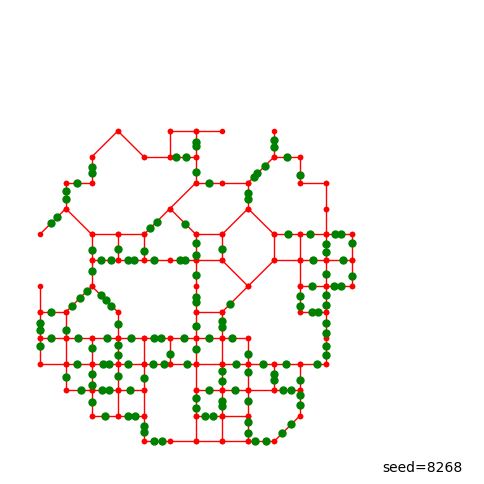

In [17]:
# Generating data for seed number 8268.
data = generateData(8268, plot=True, log=True)

In [18]:
# Saving the test data for customer locations.
with open('customer_data.pickled', 'wb') as f:
    pickle.dump(data, f)

### 1.1 Generate Delivery Data function

In [19]:
# 1.1 Generate Delivery Data function.

def generateDeliveryData(p, C, days, seed=0):
    """
    Generating delivery data according to the specified parameters.

    Parameters:
    - p: float, the average number of parcels per day per customer.
    - C: list, the list of customer locations.
    - days: int, the number of days for which data is to be generated.
    - seed: int, optional, seed value for random number generation.

    Returns:
    - D: list, a list of lists representing the delivery data for each day.
    """

    # Setting seed for reproducibility.
    np.random.seed(seed)

    # Generating the number of parcels to be delivered each day using a Poisson distribution.
    R = np.random.poisson(lam=len(C) * p, size=days)

    # Generating the delivery data for each day.
    D = [sorted(list(np.random.choice(range(len(C)), size=i))) for i in R]

    return D

# This function generates delivery data according to the specified parameters: 
# the average number of parcels per day per customer (p), the list of customer locations (C), 
# the number of days for which data is to be generated (days),
# and an optional seed value for random number generation (seed).
# It returns a list of lists representing the delivery data for each day.

### 1.2 Generate Warehouse Location

In [20]:
# 1.2 Generate Warehouse Location

def generateWarehouseLocation(M):
    """
    Generating a single random warehouse location from the given map.

    Parameters:
    - M: tuple, represents the map where the first element is a list of vertices and the second element is a list of edges.

    Returns:
    - W: tuple, representing the coordinates of the warehouse location.
    """
    V, _ = M
    W = random.sample(V, k=1)[0]  # Select one vertex randomly as the warehouse location
    return W

def generateWarehouseLocations(M, p, seed):
    """
    Generating multiple random warehouse locations from the given map.

    Parameters:
    - M: tuple, represents the map where the first element is a list of vertices and the second element is a list of edges.
    - p: float, the proportion of vertices eligible to be selected as warehouse locations.
    - seed: int, seed value for random number generation.

    Returns:
    - list of tuples representing the coordinates of the warehouse locations.
    """
    def numberOfEdges(v, E):
        count = 0
        for e in E:
            if e[0] == v or e[1] == v:
                count += 1
        return count

    V, E = M
    eligible_vertices = [v for v in V if numberOfEdges(v, E) > 2]  # Vertices with more than 2 edges are eligible for warehouse locations
    random.seed(seed)
    return random.sample(eligible_vertices, k=int(round(len(eligible_vertices) * p)))  # Sample warehouse locations based on proportion p

# These functions generate warehouse locations. 'generateWarehouseLocation' generates a single random warehouse location from the given map 'M'.
# 'generateWarehouseLocations' generates multiple random warehouse locations from the given map,
# where the proportion of eligible vertices to be selected as warehouse locations is specified by 'p'.
# The seed value seed is used for random number generation.

## Step 2 : Trip and Path Utilities

### 2.1 Path

In [21]:
# 2.1 Path

def pathLength(P):
    """
    Calculating the total length of a path represented by a list of vertices.

    Parameters:
    - P: list of tuples, representing vertices in the path.

    Returns:
    - Total length of the path.
    """
    return 0 if len(P) <= 1 else dist(P[0], P[1]) + pathLength(P[1:])

# This function calculates the total length of a path represented by a list of vertices.
# It recursively computes the distance between consecutive vertices in the path until the end of the path is reached.
# The distance between two vertices is computed using the dist function.

In [22]:
# A* algorithm for finding the shortest path between two vertices

def shortestPath(M, A, B):
    """
    Finding the shortest path between two vertices A and B in a given graph.

    Parameters:
    - M: tuple containing the graph represented as (V, E), where V is a list of vertices and E is a list of edges.
    - A: tuple representing the starting vertex.
    - B: tuple representing the target vertex.

    Returns:
    - The shortest path between vertices A and B, represented as a list of vertices.
    """

    def h(p):
        """
        Heuristic function to estimate the remaining distance from the last vertex of the path to vertex B.

        Parameters:
        - p: list representing the path so far.

        Returns:
        - Estimated remaining distance from the last vertex of the path to vertex B.
        """
        return pathLength(p) + dist(p[-1], B)

    def insert(C, p):
        """
        Inserting a new path into the list of candidate paths, sorted by the heuristic function value.

        Parameters:
        - C: list of tuples, where each tuple contains a path and its corresponding heuristic value.
        - p: list representing the new path to be inserted.

        Returns:
        - Updated list of candidate paths.
        """
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1] > hp:
                return C[:i] + [c] + C[i:]
        return C + [c]

    V, E = M
    assert A in V and B in V
    C = insert([], [A])

    while len(C) > 0:
        # Taking the first candidate out of the list of candidates.
        path, _ = C[0]
        C = C[1:]
        if path[-1] == B:
            return path
        else:
            for (x, y) in E:
                if path[-1] == x and y not in path:
                    C = insert(C, path + [y])
                elif path[-1] == y and x not in path:
                    C = insert(C, path + [x])
    return None

# This function implements the A* algorithm to find the shortest path between two vertices (A and B) in a given graph (M).
# The heuristic function (h) is used to estimate the remaining distance from the last vertex of the path to the target vertex (B).
# The insert function maintains a list of candidate paths sorted by their heuristic values.
# The algorithm continues to explore paths until it finds the target vertex B or exhausts all possible paths.

The following is a modified 
[Floyd-Warshall Algorithm](https://en.wikipedia.org/wiki/Floyd–Warshall_algorithm)
calculating in parallel the distances and the shortest path between vertices in a graph M.

In [23]:
def FW(M):
    """
    Modified Floyd-Warshall algorithm to compute the shortest distances and paths between all pairs of vertices in a graph.

    Parameters:
    - M: tuple containing the graph represented as (V, E), where V is a list of vertices and E is a list of edges.

    Returns:
    - Tuple containing the shortest distances (d) and the shortest paths (p) between all pairs of vertices.
    """

    V, E = M

    n = len(V)
    # Initializing the distance matrix with infinity and path matrix with None.
    d = [[math.inf for j in range(n)] for i in range(n)]
    p = [[None for j in range(n)] for i in range(n)]

    # Populate distance and path matrices with initial values from the edges.
    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        # Distance between vertices A and B is the edge weight.
        d[a][b] = d[b][a] = dist(A, B)
        # Path between vertices A and B is the edge itself.
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    # Setting diagonal elements to 0 and paths to single vertices.
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    # Updating the distance and path matrices using the Floyd-Warshall algorithm.
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    # Updating the path with the shortest path from i to k followed by the shortest path from k to j.
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

# This function computes the shortest distances (d) and the shortest paths (p) between all pairs of vertices in a given graph using a modified version of the Floyd-Warshall algorithm.
# It initializes the distance matrix with infinity and the path matrix with None, then updates these matrices iteratively to find the shortest paths and distances.

### 2.2 Shortest delivery route utilities

In [24]:
def reverse(P):
    """
    Reversing the given path.

    Parameters:
    - P: List representing a path.

    Returns:
    - Reversed path.
    """
    return [P[-i] for i in range(1, len(P) + 1)]

def index(x, L):
    """
    Finding the index of element x in list L.

    Parameters:
    - x: Element to be found.
    - L: List in which to search for the element.

    Returns:
    - Index of element x in list L.
    """
    for i in range(len(L)):
        if x == L[i]:
            return i
    return None

# These utility functions are used in managing and manipulating paths.
# The reverse function reverses a given path,
# while the index function finds the index of a specified element in a list.

In [25]:
def createTables(M, T):
    """
    Creating the distance and path tables between all pairs of targets in T.

    Parameters:
    - M: Map graph represented as a tuple (V, E).
    - T: List of target locations.

    Returns:
    - Distance matrix between all pairs of targets.
    - Path matrix between all pairs of targets.
    """
    n = len(T)
    d = [[math.inf for _ in T] for _ in T]
    p = [[None for _ in T] for _ in T]

    # Computing the distances and paths between targets.
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [T[i]]
        
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s) - 1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m + 1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l + 1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d, p

# This function generates distance and path tables between all pairs of targets in T.
# It computes the shortest paths using the shortestPath function and stores the results in matrices d and p.

#### 2.2.1 Create Roundtrip using iterative integer programming

In [26]:
def roundtrips(x, n):
    """
    Creating round trips using iterative integer programming.

    Parameters:
    - x: Decision variables representing the routes.
    - n: Number of customers.

    Returns:
    - List of round trips.
    """
    def isElem(x, l):
        for i in range(len(l)):
            if l[i] == x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i

    def totalLength(trips):
        s = 0
        for i in range(len(trips)):
            s += len(trips[i]) - 1
        return s

    trips = []
    while totalLength(trips) < n:
        start = startpoint(trips)
        trip = [start]
        i = start
        while len(trip) < n - totalLength(trips):
            for j in range(n):
                if pulp.value(x[i][j]) == 1:
                    trip.append(j)
                    i = j
                    break        
            if pulp.value(x[trip[-1]][start]) == 1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

# This function creates round trips using iterative integer programming by iterating over the decision variables x.
# It returns a list of round trips sorted by their lengths in descending order.

In [27]:
def createLoopAStar(M, T):
    """
    Creating a loop using the A* algorithm.

    Parameters:
    - M: Map graph.
    - T: List of customer locations.

    Returns:
    - List representing the loop.
    """
    D, P = createTables(M, T)
    n = len(T)
    # creating variables.
    x = pulp.LpVariable.dicts("x", (range(n), range(n)),
                              lowBound=0, upBound=1, cat=pulp.LpInteger)
    # creating problem.
    prob = pulp.LpProblem("Loop", pulp.LpMinimize)
    # adding objective function.
    prob += pulp.lpSum([D[i][j] * x[i][j]
                        for i in range(n) for j in range(n)])
    # adding constraints.
    constraints = 0
    for j in range(n):
        prob += pulp.lpSum([x[i][j] for i in range(n) if i != j]) == 1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([x[i][j] for j in range(n) if i != j]) == 1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i != j:
                prob += x[i][j] + x[j][i] <= 1
                constraints += 1
    # initialising solver.
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips) > 1:
        for t in trips:
            prob += pulp.lpSum([x[t[i]][t[i + 1]] + x[t[i + 1]][t[i]]
                                for i in range(0, len(t) - 1)]) <= len(t) - 2
            constraints += 1
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    loop = []
    for k in range(len(trip) - 1):
        sub = P[trip[k]][trip[k + 1]]
        loop += sub if len(loop) == 0 else sub[1:]
    return loop

# This function creates a loop using the A* algorithm.
# It iteratively solves an integer programming problem to find the shortest loop.
# Finally, it constructs the loop using the paths obtained from the A* algorithm.

In [28]:
def createLoopFW(M, D, P, T):
    """
    Creating a loop using the Floyd-Warshall algorithm.

    Parameters:
    - M: Map graph.
    - D: Distance matrix.
    - P: Path matrix.
    - T: List of customer locations.

    Returns:
    - List representing the loop.
    """
    V, E = M
    n = len(T)
    # creating variables.
    x = pulp.LpVariable.dicts("x", (range(n), range(n)),
                              lowBound=0, upBound=1, cat=pulp.LpInteger)
    # creating problem.
    prob = pulp.LpProblem("Loop", pulp.LpMinimize)
    # adding objective function.
    prob += pulp.lpSum([D[V.index(T[i])][V.index(T[j])] * x[i][j]
                        for i in range(n) for j in range(n)])
    # adding constraints.
    constraints = 0
    for j in range(n):
        prob += pulp.lpSum([x[i][j] for i in range(n) if i != j]) == 1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([x[i][j] for j in range(n) if i != j]) == 1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i != j:
                prob += x[i][j] + x[j][i] <= 1
                constraints += 1
    # initialising solver.
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips) > 1:
        for t in trips:
            prob += pulp.lpSum([x[t[i]][t[i + 1]] + x[t[i + 1]][t[i]]
                                for i in range(0, len(t) - 1)]) <= len(t) - 2
            constraints += 1
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    loop = []
    for k in range(len(trip) - 1):
        sub = P[V.index(T[trip[k]])][V.index(T[trip[k + 1]])]
        loop += sub if len(loop) == 0 else sub[1:]
    return loop

# This function creates a loop using the Floyd-Warshall algorithm.
# It iteratively solves an integer programming problem to find the shortest loop.
# Finally, it constructs the loop using the paths obtained from the Floyd-Warshall algorithm.

#### 2.2.2 Create Roundtrip using Heuristic

In [29]:
def createLoopH(M, D, P, T, plot=False):
    """
    Creating a loop using a heuristic approach.

    Parameters:
    - M: Map graph.
    - D: Distance matrix.
    - P: Path matrix.
    - T: List of customer locations.
    - plot: Boolean flag to enable/disable plotting.

    Returns:
    - List representing the loop.
    """
    def makeLoop(L):
        loop = []
        for i in range(len(L) - 1):
            A = L[i]
            B = L[i + 1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop) == 0 else sub[1:]
        return loop

    V, E = M
    W = T[0]
    customers = T[1:]
    if len(T) == 1:
        L = T
    elif len(T) <= 3:
        L = T + [T[0]]
    else:
        L = T[:3] + [T[0]]
        T = T[3:]
        while len(T) > 0:
            if plot:
                loop = makeLoop(L)
                plotMap(M, T=L, P=loop, w=W,
                        grid=True, text=f"{pathLength(loop):,d}m")
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L) - 1):
                    A = L[i]
                    B = L[i + 1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext < minExt:
                        minExt, minInd, selInd = ext, i + 1, k
            L = L[:minInd] + [T[selInd]] + L[minInd:]
            T = T[:selInd] + T[selInd + 1:]
    return makeLoop(L)

# This function creates a loop using a heuristic approach.
# It iteratively inserts new customer locations into the loop by evaluating the extension of the loop if the location is inserted between two consecutive points of the loop.
# It repeats this process until all customer locations are inserted into the loop.
# If plotting is enabled, it visualizes the construction process.

## 3 : Time Handling Utilities

**Convention:** In this project the author has measured time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [30]:
def timestamp(t):
    """
    Generating a timestamp string in the form [dd] hh:mm:ss.d.

    Parameters:
    - t: Time in seconds.

    Returns:
    - Timestamp string.
    """
    day = int(t) // (24 * 3600)
    t = t - day * 24 * 3600
    hour = int(t) // 3600
    t = t - hour * 3600
    mins = int(t) // 60
    t = t - mins * 60
    secs = int(t)
    t = int(round((t - secs) * 10))
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

# This function generates a timestamp string representing the time in seconds.
# It formats the time into days, hours, minutes, seconds, and tenths of a second.

In [31]:
# Calculating the number of days, hours, minutes, and seconds.
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [32]:
# This function calculates the time until the next occurrence of a specified hour within a day.
def nextHour(env, hour):
    # Calculating the beginning of the current day in seconds.
    beginningOfDay = int(env.now // (24 * 3600)) * 24 * 3600
    # Calculating the time elapsed since the beginning of the day.
    timeOfDay = env.now - beginningOfDay
    # Checking if the target hour is in the future relative to the current time.
    if hour * 3600 > timeOfDay:
        # Returns the time difference until the target hour is reached.
        return hour * 3600 - timeOfDay
    else:
        # Returns the time difference until the target hour on the next day is reached.
        return hour * 3600 + 24 * 3600 - timeOfDay

In [33]:
# This function calculates the current day based on the provided timestamp.
def day(now):
    # Calculating the number of days elapsed since the epoch.
    return int(now // (24 * 3600))

## Step 4: Simulation Data Capturing Utilities

Using a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder.

### 4.1 Class Recorder

In [34]:
# Function to calculate the cost of delivery based on working time and tour length.
def cost(daily):
    return ((daily.time / 3600) * 30 + 0.08 * (daily.dist / 1000))

# Class to record simulation data and perform analysis.
class Recorder:
    
    def __init__(self, env, M, W, C, days, parcels, log=False, plot=False):
        """
        Initializes the Recorder object with simulation parameters and data structures for recording.

        Args:
        - env: Simpy environment
        - M: Tuple containing vertices and edges of the graph representing the delivery network
        - W: Warehouse location
        - C: List of customer locations
        - days: Number of days for simulation
        - parcels: Total number of parcels to be delivered
        - log: Boolean flag for logging simulation events
        - plot: Boolean flag for plotting simulation data
        """
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.parcels = parcels
        self.log = log
        self.plot = plot
        Customer.REGISTER = []
        Parcel.REGISTER = []
                
        # Creating a data frames for recording time records per working day and parcel records.
        self.daily = pd.DataFrame()
        self.daily['begin'] = [None] * days
        self.daily['end'] = [None] * days
        self.daily['dist'] = [None] * days
        self.daily['left'] = [None] * days
        
        self.precs = pd.DataFrame()
        self.precs['arrived'] = [None] * parcels
        self.precs['delivered'] = [None] * parcels

    def trace(self, event):
        """
        Logs simulation events if logging is enabled.

        Args:
        - event: Event to be logged
        """
        if self.log:
            print(timestamp(self.env.now), event)

    def recordDriverBeginsWork(self):
        """
        Records the beginning of a driver's work shift.
        """
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        """
        Records the end of a driver's work shift.
        """
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end'] = int(round(self.env.now))

    def recordTourLength(self, length):
        """
        Records the length of a delivery tour.

        Args:
        - length: Length of the tour
        """
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        """
        Records the number of parcels left over for the next day.

        Args:
        - numberOfParcels: Number of parcels left over
        """
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels

    def recordParcelArrival(self, parcel):
        """
        Records the arrival of a parcel at the delivery centre.

        Args:
        - parcel: Parcel object representing the arrived parcel
        """
        self.trace(f"{str(parcel):s} arrived in delivery centre")
        self.precs.at[parcel.i, 'arrived'] = day(self.env.now)
        
    def recordParcelDelivery(self, parcel):
        """
        Records the delivery of a parcel to a customer.

        Args:
        - parcel: Parcel object representing the delivered parcel
        """
        self.trace(f"{str(parcel):s} delivered to customer")
        self.precs.at[parcel.i, 'delivered'] = day(self.env.now)
    
    def calculateCost(self):
        """
        Calculating the cost of delivery based on working time and tour length.
        """
        self.daily['cost'] = cost(self.daily)
    
    def finish(self):
        """
        Finalizing the simulation and performs necessary calculations.
        """
        self.daily['time'] = self.daily['end'] - self.daily['begin']
        # Registering parcels not yet delivered at the end of simulation for the next day.
        for i in range(self.parcels):
            if self.precs.at[i, 'delivered'] is None:
                self.precs.at[i, 'delivered'] = self.days
        self.precs['delay'] = self.precs['delivered'] - self.precs['arrived']
        # Calculating maximum delay time of parcels delivered on a day.
        self.daily['maxdelay'] = [0] * self.days
        for i in range(self.parcels):
            deliveryDay = self.precs.at[i, 'delivered']
            if deliveryDay < self.days:
                if self.daily.at[deliveryDay, 'maxdelay'] < self.precs.at[i, 'delay']:
                    self.daily.at[deliveryDay, 'maxdelay'] = self.precs.at[i, 'delay']
        # Calculating cost of delivery.
        self.calculateCost()
        # Removing simulation environment to pickle recorder.
        self.env = None
        
    # Plotting methods
    def histWorkingTime(self):
        """
        Plot histogram of daily working time.
        """
        histplot(self.daily['time'] // 60,
                 xlabel='Working Time [min]',
                 title='Daily Working Time')
        
    def plotWorkingTime(self):
        """
        Plot line graph of daily working time.
        """
        dailyPlot(self.daily['time'] // 60,
                  ylabel='Working Time [min]',
                  title='Daily Working Time')
            
    def histTourLength(self):
        """
        Plot histogram of daily tour length.
        """
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')
            
    def plotTourLength(self):
        """
        Plot line graph of daily tour length.
        """
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')
            
    def histLeftOver(self):
        """
        Plot histogram of daily left-over parcels.
        """
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')
                
    def plotLeftOver(self):
        """
        Plot line graph of daily left-over parcels.
        """
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')
        
    def plotParcelDelay(self):
        """
        Plot line graph of maximum delivery delay.
        """
        dailyPlot(self.daily['maxdelay'],
                  ylabel='Max Delay [days]',
                  title='Max Delivery Delay')
    
    def barplotParcelDelay(self):
        """
        Plot bar plot of parcel delay.
        """
        maxDelay = max(self.precs['delay'])
        count = [ 0 for c in range(maxDelay+1) ]
        for i in range(self.parcels):
            count[self.precs.at[i, 'delay']] += 1
        barPlot(count, title='Parcel Delay [days]')
        
    def tableParcelDelay(self):
        """
        Plot table of parcel delay.
        """
        maxDelay = max(self.precs['delay'])
        count = [ 0 for c in range(maxDelay+1) ]
        for i in range(self.parcels):
            count[self.precs.at[i, 'delay']] += 1
        print(f'Delivery Delay ({self.parcels:d} parcels)')
        print(f'{"None":>7s}:   {count[0]:4d}   {count[0]/self.parcels*100:4.1f}%')
        for c in range(1, len(count)):
            print(f'{c:2d} days:   {count[c]:4d}   {count[c]/self.parcels*100:4.1f}%')

In [35]:
# Function to combine multiple Recorder objects into one
def combineRecorders(recs):
    """
    Combining multiple Recorder objects into one.

    Args:
    - recs: List of Recorder objects to be combined

    Returns:
    - Combined Recorder object
    """
    # Extracting necessary attributes from the first Recorder object.
    M = recs[0].M  # Map.
    W = recs[0].W  # Warehouse location.
    C = recs[0].C  # Customer locations.
    days = sum([rec.days for rec in recs])  # Total simulation days.
    parcels = sum([rec.parcels for rec in recs])  # Total parcels simulated.
    
    # Ensuring if the models are compatible by checking the attributes of other Recorder objects.
    for rec in recs[1:]:
        assert M == rec.M
        assert W == rec.W
        assert C == rec.C
        
    # Initializing a new Recorder object for combining data.
    r = Recorder(None, M, W, C, days, parcels)
    
    # Joining the data frames of all Recorder objects.
    r.daily = pd.concat([rec.daily for rec in recs], ignore_index=True)
    r.precs = pd.concat([rec.precs for rec in recs], ignore_index=True)
    
    return r  # Returns the combined Recorder object.

This function combines multiple instances of the Recorder class into one, allowing for the aggregation of data from multiple simulations. It takes a list of Recorder objects recs as input and returns a single combined Recorder object. The attributes of the first Recorder object in the list are used as the attributes of the combined Recorder object, including the map (M), warehouse location (W), customer locations (C), total simulation days (days), and total parcels simulated (parcels).

Before combining the Recorder objects, the function ensures that their models are compatible by checking if their map, warehouse location, and customer locations are the same. If the models are not compatible, it raises an assertion error.

The function then initializes a new Recorder object r with the combined attributes and joins the data frames of all Recorder objects in the list recs. Finally, it returns the combined Recorder object r.

### 4.2 Class Parcel

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [36]:
# Class representing a parcel.
class Parcel:
    # Static variable to keep track of all parcels.
    REGISTER = []
    
    # Constructor to initialize a parcel object.
    def __init__(self, rec, cust):
        """
        Initializing a parcel object.

        Args:
        - rec: Recorder object for recording simulation data
        - cust: Customer object representing the parcel's destination customer
        """
        self.rec = rec  # Recorder object.
        self.cust = cust  # Customer object.
        self.dest = cust.location  # Destination location.
        self.status = []  # List to record parcel status.
        self.timing = []  # List to record timing.
        self.i = len(Parcel.REGISTER)  # Unique identifier for the parcel.
        Parcel.REGISTER.append(self)  # Adding the parcel to the register.

    # String representation of the parcel object.
    def __str__(self):
        """
        Returns a string representation of the parcel object.
        """
        return f"Parcel: {self.i:2d} for customer {self.cust.i:d}"

    # Private method to register parcel status and timing.
    def __reg(self, state):
        """
        Register the parcel status and timing.

        Args:
        - state: Current state of the parcel
        """
        self.status.append(state)  # Adding the current state to the status list.
        self.timing.append(self.rec.env.now)  # Recording the current time.
        self.rec.trace(str(self) + " " + state)  # Log the event.

    # Method to register when the parcel arrives at the delivery center.
    def arrivedAtDeliveryCentre(self):
        """
        Register that the parcel has arrived at the delivery center.
        """
        self.__reg('arr at delivery centre')

    # Method to register when the parcel is out for delivery.
    def outForDelivery(self):
        """
        Register that the parcel is out for delivery.
        """
        self.__reg('out for delivery')

    # Method to register when the parcel returns from delivery.
    def returnFromDelivery(self):
        """
        Register that the parcel has returned from delivery.
        """
        self.__reg('return from delivery')

    # Method to register when the parcel is delivered to the customer.
    def delivered(self):
        """
        Register that the parcel has been delivered to the customer.
        """
        self.rec.recordParcelDelivery(parcel)  # Recording the parcel delivery.
        self.__reg('delivered to customer')  # Registering the delivery event.


# The above code defines a class Parcel representing a parcel in the delivery system.
# Each parcel goes through a sequence of states, and the class provides methods to register these states and timings.
# The constructor initializes a parcel with a recorder object and a customer object representing the destination customer.
# The class also provides methods to register when the parcel arrives at the delivery center, goes out for delivery, returns from delivery, and when it is delivered to the customer.

`generateParcels` returns for each day a list of customers that should receive parcels on that day. The data are generated for a given number of customers and days under assumption that the demand is independent and identically distributed with a mean value 

In [37]:
def generateParcels(days=50, customers=100, p=0.25, plot=False, log=False):
    """
    Generating parcel delivery data for each day for a given number of days and customers.

    Args:
    - days: Number of days to generate parcel delivery data for
    - customers: Number of customers
    - p: Mean value for the exponential distribution
    - plot: Boolean indicating whether to plot histograms
    - log: Boolean indicating whether to log customer expectations

    Returns:
    - parcelsForCustomersPerDay: A list of lists where each inner list contains the indices of customers
                                  who should receive parcels on a particular day
    """
    # Initializing lists to store parcel delivery data.
    parcelsForCustomersPerDay = [[] for _ in range(days)]
    parcelsPerCustomer = [0] * customers
    parcelsPerDay = [0] * days

    # Generating parcel delivery data for each customer independently.
    for c in range(customers):
        cp = []  # List to track the delivery days for the current customer.
        t = random.expovariate(p / (24 * 3600))  # Arrival time in seconds.
        d = int(t / (24 * 3600))  # Day of arrival.
        deliveryDays = []  # List to store unique delivery days for the current customer.
        while d < days:
            if d not in deliveryDays:
                deliveryDays.append(d)
            parcelsForCustomersPerDay[d].append(c)  # Adding customer index to the corresponding day.
            parcelsPerDay[d] += 1  # Increment parcel count for the day.
            parcelsPerCustomer[c] += 1  # Increment parcel count for the customer.
            if d not in cp:
                cp.append(d)
            t += random.expovariate(p / (24 * 3600))  # Updating the arrival time for the next delivery.
            d = int(t / (24 * 3600))  # Calculating the day for the next delivery.

        # Logging customer expectations if enabled.
        if log:
            print(f"customer {c:3d} expects {parcelsPerCustomer[c]:2d} deliveries on days {str(cp)}")

    # Plotting histograms if enabled.
    if plot:
        histplot(parcelsPerCustomer,
                 xlabel=f'Number of Parcels (over {days:3,d} days, p={p:2.2f})',
                 title=f'Number of Parcels per Customer (N={customers:3,d})')

        histplot(parcelsPerDay,
                 xlabel=f'Number of Parcels (over {customers:3,d} customers, p={p:2.2f})',
                 title=f'Number of Parcels per Day (N={days:3,d})')

    return parcelsForCustomersPerDay

# This function generates parcel delivery data for each day,
# where the demand is independent and identically distributed for each customer.
# It uses an exponential distribution to determine the arrival times of parcels for each customer.
# The generated data include the indices of customers who should receive parcels on each day.
# It can log customer expectations and plot histograms of parcel counts per customer and per day.

### 4.3 Class Customer

In [38]:
class Customer:
    """
    Class to represent customers in the simulation.
    """
    REGISTER = []

    def __init__(self, rec, location, q):
        """
        Initializing a customer object.

        Args:
        - rec: Recorder object for logging and recording parcel deliveries
        - location: Location of the customer
        - q: Probability of the customer being at home
        """
        self.rec = rec
        self.location = location
        self.q = q
        self.parcelsReceived = []  # List to store received parcel indices.
        self.i = len(Customer.REGISTER)
        Customer.REGISTER.append(self)

    def __str__(self):
        """
        Return string representation of the customer.
        """
        return f"Customer: {self.i:2d} {str(self.location):s}"

    @staticmethod
    def getCustomer(rec, location, q=None):
        """
        Factory method to retrieve or create a customer based on location.
        Ensures there is only one customer per location.

        Args:
        - rec: Recorder object for logging and recording parcel deliveries
        - location: Location of the customer
        - q: Probability of the customer being at home

        Returns:
        - Customer object
        """
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        assert(q is not None)
        return Customer(rec, location, q)

    def responseTime(self):
        """
        Calculating the response time for the customer.

        Returns:
        - Response time: Either infinity if the customer is not home, or a random value based on an exponential distribution.
        """
        if random.random() < self.q:
            return math.inf  # Customer is not home
        else:
            return random.expovariate(1 / AVERAGE_TIME_ANSWER_DOOR)

    def acceptParcel(self, parcel):
        """
        Recording the acceptance of a parcel by the customer.

        Args:
        - parcel: Parcel object to be accepted
        """
        self.parcelsReceived.append(parcel.i)
        self.rec.recordParcelDelivery(parcel)

# This class represents customers in the simulation.
# Each customer has a location and a probability of being at home (q).
# The getCustomer method ensures that there is only one customer per location.
# The responseTime method calculates the response time for the customer,
# which is either infinity if the customer is not home, or a random value based on an exponential distribution.
# The acceptParcel method records the acceptance of a parcel by the customer and logs the delivery.

### 4.4 Class Driver

In [39]:
class Driver:
    """
    Class to represent drivers in the simulation.
    """

    def __init__(self, rec, DC, patience):
        """
        Initializing a driver object.

        Args:
        - rec: Recorder object for logging and recording driver activities
        - DC: DeliveryCentre object representing the delivery center
        - patience: Maximum waiting time for a customer to answer the door
        """
        self.rec = rec
        self.DC = DC
        self.patience = patience
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())

    def __drive(self, target):
        """
        Drive to a target location.

        Args:
        - target: Target location to drive to
        """
        assert (self.tour[0] == self.location)
        while self.location != target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert (self.tour[0] == self.location == target)

    def arriveForWork(self):
        """
        Set driver's location and initialize parcels for delivery.
        """
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [self.DC.W]
        self.rec.recordDriverBeginsWork()

    def leaveForDelivery(self, tour, parcels):
        """
        Depart for delivery with specified tour and parcels.

        Args:
        - tour: Tour for delivery
        - parcels: Parcels to be delivered
        """
        for p in parcels:
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL)
            p.outForDelivery()
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery "
                       f"of {len(parcels):d} parcels")

    def goHome(self):
        """
        Return to the delivery center after work.
        """
        self.location = self.DC.W
        self.parcels = None
        self.returns = None
        self.tour = [self.DC.W]
        self.rec.recordDriverEndsWork()

    def process(self):
        """
        Main process for the driver during the simulation.
        """
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now) < self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield from self.leaveForDelivery(tour, parcels)
            self.rec.recordTourLength(pathLength(tour))
            while len(self.parcels) > 0:
                # Drive to customer.
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to " + str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at " + str(cust))
                wait_time = cust.responseTime()

                if wait_time < self.patience:
                    # Customer answered door.
                    yield self.rec.env.timeout(wait_time)
                    self.rec.trace(str(cust) + " answers door")
                    while len(self.parcels) > 0 and \
                            custLocation == self.parcels[0].dest:
                        handover_time = random.expovariate(1 / AVERAGE_TIME_HANDOVER)
                        yield self.rec.env.timeout(handover_time)
                        cust.acceptParcel(self.parcels[0])
                        self.parcels = self.parcels[1:]
                    signoff_time = random.expovariate(1 / AVERAGE_TIME_SIGNOFF)
                    yield self.rec.env.timeout(signoff_time)
                    self.rec.trace(str(cust) + " signed off")
                else:
                    # Customer not at home or too slow.
                    yield self.rec.env.timeout(self.patience)
                    self.rec.trace(str(cust) + " doesn't answer the door")
                    while len(self.parcels) > 0 and \
                            custLocation == self.parcels[0].dest:
                        self.returns.append(self.parcels[0])
                        self.parcels = self.parcels[1:]

            # Return to delivery centre.
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            yield from self.DC.returnFromDelivery(self.returns)

            self.rec.recordParcelsLeftOver(len(self.DC.parcels) +
                                           len(self.DC.leftOver))

            self.goHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

### 4.5 Class Delivery Centre

In [40]:
class DeliveryCentre:
    """
    Class to represent the delivery center in the simulation.
    """

    def __init__(self, rec, M, W, limit, heuristic):
        """
        Initializing a delivery center object.

        Args:
        - rec: Recorder object for logging and recording delivery center activities
        - M: Graph representing the map
        - W: Warehouse location
        - limit: Maximum tour length limit
        - heuristic: Flag indicating whether to use heuristic or not for tour planning
        """
        self.rec = rec
        self.M = M
        self.W = W
        self.D, self.P = FW(M)
        self.limit = limit
        self.heuristic = heuristic

        self.leftOver = []  # List of parcels.
        self.parcels = []  # List of parcels scheduled for delivery.
        self.dest = []  # List of unique customer destinations.
        self.tour = [W]  # Tour planned for delivery.

    def __accept(self, parcel):
        """
        Accept a parcel for delivery.

        Args:
        - parcel: Parcel object to be accepted for delivery
        """
        custLoc = parcel.dest
        if custLoc in self.dest:
            self.parcels.append(parcel)
        else:
            if self.heuristic:
                MT = addTargets(self.M, self.dest + [custLoc])
                self.D, self.P = FW(MT)
                S = createLoopH(MT, self.D, self.P, [self.W] + self.dest + [custLoc])
            else:
                MT = addTargets(self.M, self.dest + [custLoc])
                self.D, self.P = FW(MT)
                S = createLoopFW(MT, self.D, self.P, [self.W] + self.dest + [custLoc])
            if pathLength(S) < self.limit:
                self.parcels.append(parcel)
                self.dest.append(custLoc)
                self.tour = S
            else:
                self.leftOver.append(parcel)

    def acceptParcel(self, parcel):
        """
        Accept a parcel for delivery.

        Args:
        - parcel: Parcel object to be accepted for delivery
        """
        parcel.arrivedAtDeliveryCentre()
        self.rec.recordParcelArrival(parcel)
        self.__accept(parcel)

    def sendForDelivery(self):
        """
        Send parcels for delivery and return the tour and parcels.
        """
        parcels = []
        tour = self.tour
        addresses = self.dest

        # Picking the parcels in sequence to be delivered.
        for dest in tour:
            if dest in self.dest:
                for p in self.parcels:
                    if p.dest == dest:
                        parcels += [p]

        # Rearranging the left over parcels.
        L = self.leftOver
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)

        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0],
                    grid=True, size=5,
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels

    def returnFromDelivery(self, parcels):
        """
        Return parcels from delivery and update the state.

        Args:
        - parcels: List of parcels to return from delivery
        """
        for p in parcels:
            p.returnFromDelivery()
            yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            self.__accept(p)
        yield self.rec.env.timeout(END_OF_DAY_TIME)

## Step 5 : Simulation

### 5.1 Parameters from Specification

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [41]:
# Converting kilometers per hour to meters per second.
AVERAGE_SPEED = 15 / 3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [42]:
PREP_TIME_PER_PARCEL = 50  # in seconds

# The parameter PREP_TIME_PER_PARCEL represents the cumulative preparation time for each parcel to be delivered.
# This includes route planning, sorting of the parcels in the delivery order, and packing the cargo-bike.
# It is assumed to be 50 seconds per parcel.
# This parameter is used in the simulation to model the time it takes for the driver to prepare for delivery before leaving the delivery center.

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parcel. 

In [43]:
RETURN_TIME_PER_PARCEL = 30  # in seconds

# The parameter RETURN_TIME_PER_PARCEL represents the time required to process returned parcels in the delivery center.
# It is assumed to be 30 seconds per parcel.
# This parameter is used in the simulation to model the time it takes for the delivery center to handle returned parcels upon the driver's return.

The average **customer time** to answer the door, accept a parcel, or signoff.

In [44]:
AVERAGE_TIME_ANSWER_DOOR = 40  # Average time for a customer to answer the door (in seconds).
AVERAGE_TIME_HANDOVER = 10  # Average time for a customer to accept a parcel (in seconds).
AVERAGE_TIME_SIGNOFF = 10  # Average time for a customer to sign off after receiving a parcel (in seconds).

# These parameters are used in the simulation to model customer behavior and the time taken for delivery interactions.

The time for end of day closing procedure

In [45]:
#  the time required for the end-of-day closing procedure at the delivery center.
# It's assumed to be 600 seconds (10 minutes).
END_OF_DAY_TIME = 600  
# This time allows for tasks such as finalizing records, organizing parcels, and preparing for the next day's operations.

Using the Delivery data generated for simulation. 

### 5.2 Generate input data for simulation

In [46]:
## Generate input data for simulation
def generateInputData(D, log=False):
    """
    Generating input data for the simulation.

    Args:
    - D: List of lists representing the delivery data for each day
    - log: Boolean indicating whether to print log messages or not

    Returns:
    - DataFrame containing the input data
    """

    # Defining constants.
    DAY_LENGTH = 24 * 3600    # measured in minutes.
    DAY_START = 8 * 3600      # first delivery in the morning.
    DAY_END = 17 * 3600       # last delivery during day time.

    # Initializing the DataFrame.
    x = pd.DataFrame()
    x['iarr'] = [None] * sum(len(d) for d in D)
    x['time'] = [None] * sum(len(d) for d in D)
    x['day'] = [None] * sum(len(d) for d in D)
    x['dest'] = [None] * sum(len(d) for d in D)

    current_day = 0
    last_time = 0
    i = 0

    # Generating input data for each day.
    for d in D:
        if log:
            print("Generating for day:", current_day, D[current_day])

        time = current_day * DAY_LENGTH + DAY_START

        # Generating input data for each customer.
        for c in d:
             # Estimating the average IAT for the current day.
            IARR = (DAY_END - DAY_START - 2 * 3600) / len(d) 
            iat = random.expovariate(1.0 / IARR)
            new_time = time + iat

            x.at[i, 'iarr'] = round(new_time - last_time, 1)
            x.at[i, 'time'] = round(new_time - current_day * DAY_LENGTH, 1)
            x.at[i, 'day'] = current_day
            x.at[i, 'dest'] = c

            i += 1
            last_time = time = new_time

        current_day += 1

    return x

### 5.3 Simulation Routine

In [47]:
## Simulation Routine
def simulation(M, W, C,      # maping geometry.
               days,         # runing simulation for number of days.
               p=0.2,        # parcels per day and customer, 
               limit=30000,  # bike range limit.
               q=0.1,        # probability that the customer is not at home. 
               patience=60,  # max wait time for customer answering door.
               heuristic=False, log=False, plot=False, ticks=False):
    """
    Running the simulation routine.

    Args:
    - M: Map geometry
    - W: Warehouse location
    - C: List of customer locations
    - days: Number of days to run the simulation
    - p: Parcels per day and customer
    - limit: Bike range limit
    - q: Probability that the customer is not at home
    - patience: Maximum wait time for customer answering door
    - heuristic: Whether to use heuristic or not
    - log: Boolean indicating whether to print log messages or not
    - plot: Boolean indicating whether to plot or not
    - ticks: Boolean indicating whether to print ticks or not

    Returns:
    - Recorder object containing simulation data
    """

    # Generating the parcels for each day.
    P = generateParcels(days=days, p=p, customers=len(C))
    parcels = sum([len(d) for d in P])

    # Printing simulation details.
    print(f"Simulating the delivery of {parcels:d} parcels "
          f"over {days:d} days to {len(C):d} customers")

    # Initializing the simulation environment and recorder.
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, parcels, log=log, plot=plot)

    def generatorProcess(env):
        # Initializing the delivery centre and driver.
        DC = DeliveryCentre(rec, M, W, limit, heuristic)
        D = Driver(rec, DC, patience)

        # Processing the parcels day by day.
        for CL in P:
            if log:
                print()
            if ticks:
                print(".", end="")

            yield env.timeout(12 * 3600)  # days
            for ci in CL:
                cust = Customer.getCustomer(rec, C[ci], q)
                p = Parcel(rec, cust)
                DC.acceptParcel(p)
            yield env.timeout(12 * 3600)  # days

    env.process(generatorProcess(env))
    env.run()

    # Finished simulation and returns recorder.
    rec.finish()

    return rec

### 5.4 Model Verification

In [48]:
# opening test data.
with open('customer_data.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [49]:
# The output represents pairs of coordinates, indicating the routes between various points in a delivery system.
# Each tuple in the list appears to represent a route from one point to another. 
M[1]

[((640, 2320), (1200, 2320)),
 ((640, 2880), (640, 2320)),
 ((640, 2880), (640, 3440)),
 ((640, 2880), (1200, 2880)),
 ((640, 4000), (640, 3440)),
 ((640, 5120), (1200, 5680)),
 ((1200, 1760), (1200, 2320)),
 ((1200, 1760), (1760, 1760)),
 ((1200, 2880), (1200, 2320)),
 ((1200, 2880), (1200, 3440)),
 ((1200, 2880), (1760, 2880)),
 ((1200, 3440), (640, 3440)),
 ((1200, 5680), (1760, 5120)),
 ((1200, 6240), (1200, 5680)),
 ((1200, 6240), (1760, 6240)),
 ((1760, 1200), (1760, 1760)),
 ((1760, 1200), (2320, 1200)),
 ((1760, 2320), (1200, 2320)),
 ((1760, 2320), (1760, 1760)),
 ((1760, 2320), (1760, 2880)),
 ((1760, 2320), (2320, 2320)),
 ((1760, 4000), (1200, 3440)),
 ((1760, 4000), (1760, 4560)),
 ((1760, 4000), (2320, 3440)),
 ((1760, 4560), (1760, 5120)),
 ((1760, 4560), (2320, 4560)),
 ((1760, 5120), (2320, 5120)),
 ((1760, 6800), (1760, 6240)),
 ((1760, 6800), (2320, 7360)),
 ((2320, 1760), (1760, 1760)),
 ((2320, 1760), (2320, 1200)),
 ((2320, 1760), (2320, 2320)),
 ((2320, 1760), (2

In [50]:
W = generateWarehouseLocations(M, p=0.15, seed=8268)
W  # warehouse locations

[(6800, 5120),
 (4000, 4560),
 (5120, 4000),
 (4560, 4560),
 (2320, 2320),
 (4560, 2320),
 (7360, 4560),
 (1200, 2880),
 (3440, 5680),
 (2880, 4560)]

In [51]:
C  # Customer locations

[(640, 2700),
 (640, 3044),
 (640, 3197),
 (876, 2880),
 (878, 3440),
 (886, 5366),
 (1010, 5490),
 (1200, 2038),
 (1200, 3052),
 (1200, 5895),
 (1200, 6070),
 (1333, 3573),
 (1433, 6240),
 (1435, 2320),
 (1473, 2880),
 (1501, 3741),
 (1537, 1760),
 (1648, 3888),
 (1760, 1497),
 (1760, 1872),
 (1760, 2102),
 (1760, 2671),
 (1760, 4334),
 (1760, 4785),
 (1760, 6450),
 (1760, 6589),
 (1953, 3806),
 (1964, 4560),
 (1978, 1760),
 (2010, 2320),
 (2043, 1200),
 (2055, 3704),
 (2080, 2880),
 (2135, 2320),
 (2137, 1760),
 (2178, 3580),
 (2179, 4560),
 (2320, 2053),
 (2320, 2501),
 (2320, 2720),
 (2320, 3184),
 (2320, 4814),
 (2527, 2320),
 (2534, 1200),
 (2538, 4560),
 (2583, 1760),
 (2612, 2880),
 (2675, 4560),
 (2691, 1200),
 (2880, 841),
 (2880, 982),
 (2880, 2021),
 (2880, 4754),
 (3014, 5254),
 (3077, 2320),
 (3090, 640),
 (3090, 4560),
 (3098, 2880),
 (3152, 5392),
 (3238, 2880),
 (3264, 640),
 (3305, 2320),
 (3440, 2527),
 (3565, 6800),
 (3647, 4560),
 (3739, 2880),
 (3768, 5351),
 (377

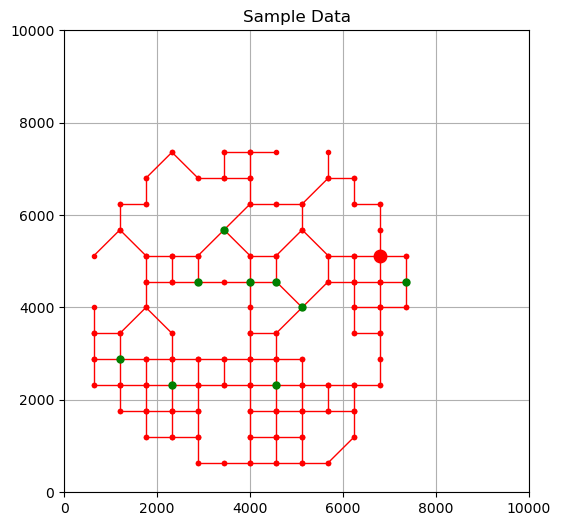

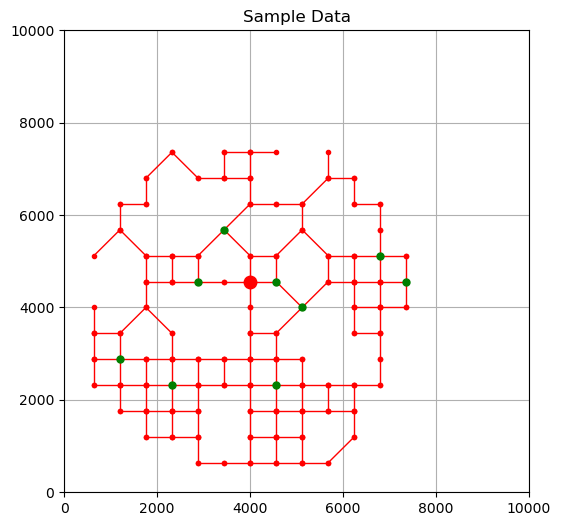

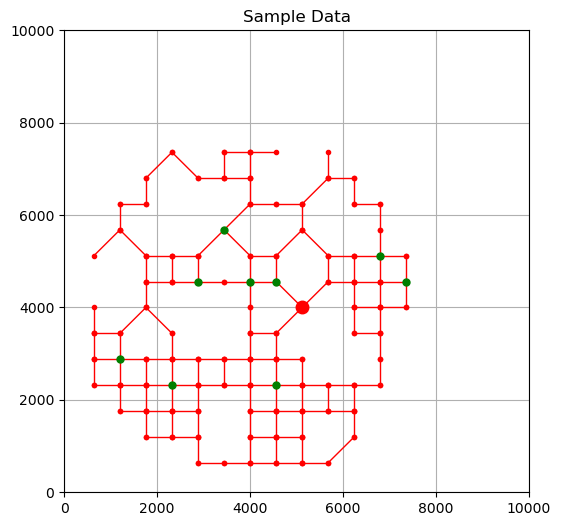

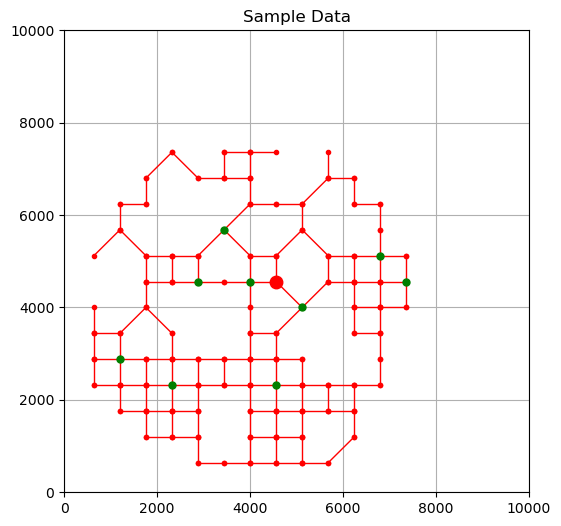

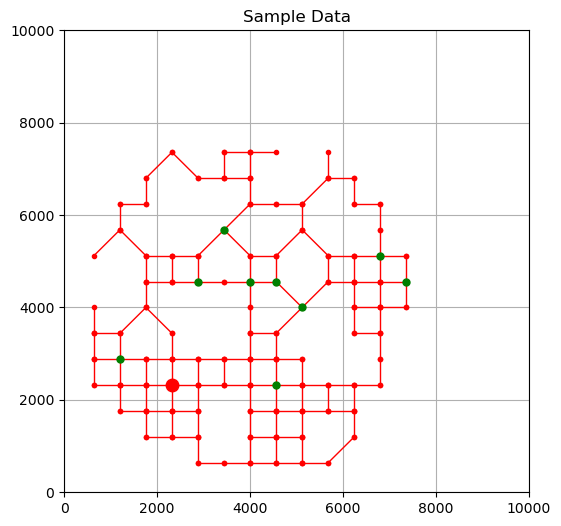

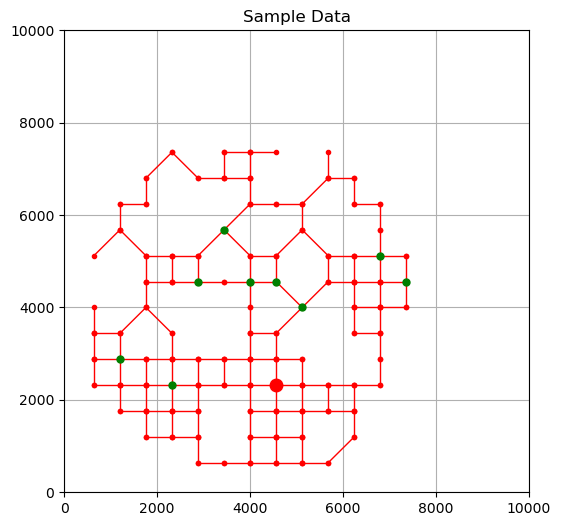

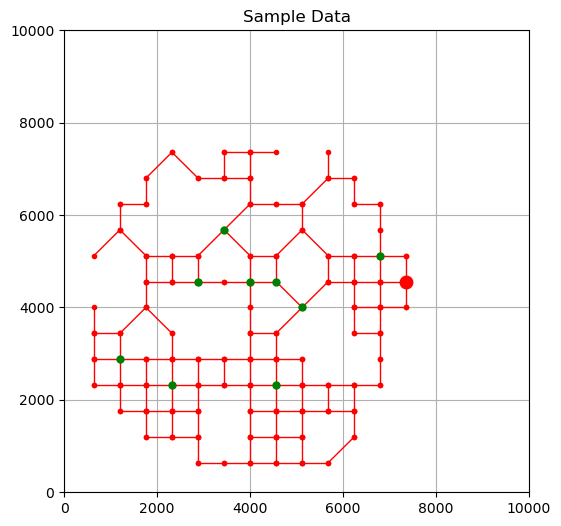

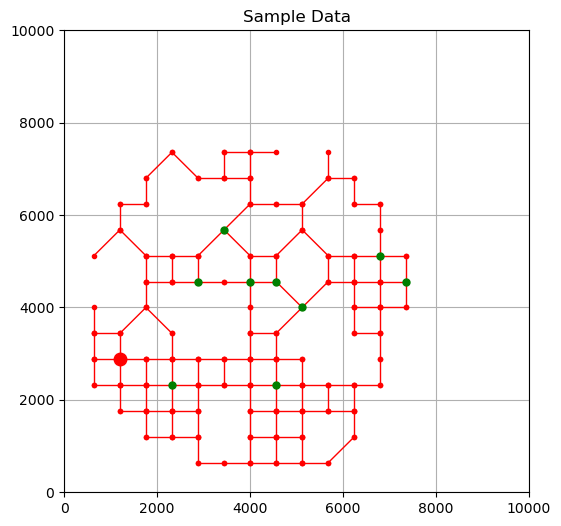

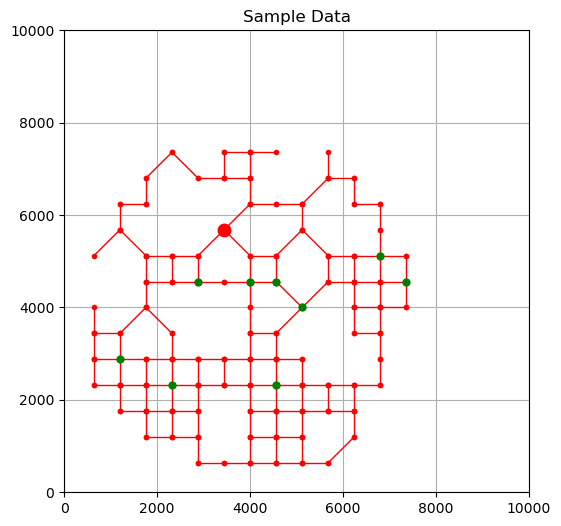

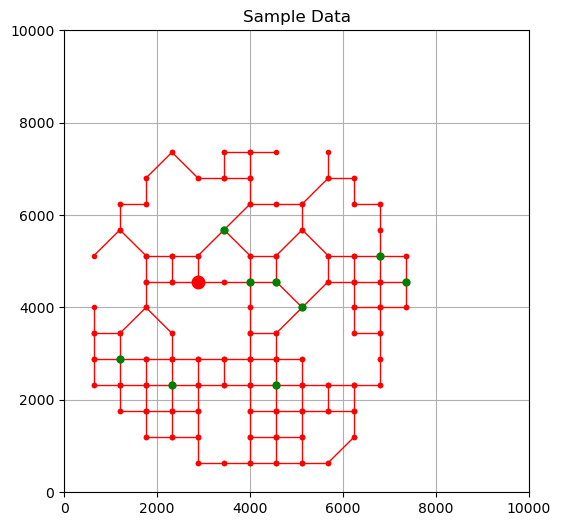

In [52]:
# Iterating through each warehouse location in W.
for w in W:
    # Plotting the map with the warehouse location marked.
    plotMap(M, T=W, w=w, text='Sample Data', grid=True)

### 5.5 Run small simulation heuristic

Simulating the delivery of 198 parcels over 10 days to 150 customers

[ 0] 12:00:00.0 Parcel:  0 for customer 0 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  0 for customer 0 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  3 for customer 2 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  3 for customer 2 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  4 for customer 3 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  4 for customer 3 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  5 for customer 4 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  5 for customer 4 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  6 for customer 4 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  6 for customer 4 arrived in delivery

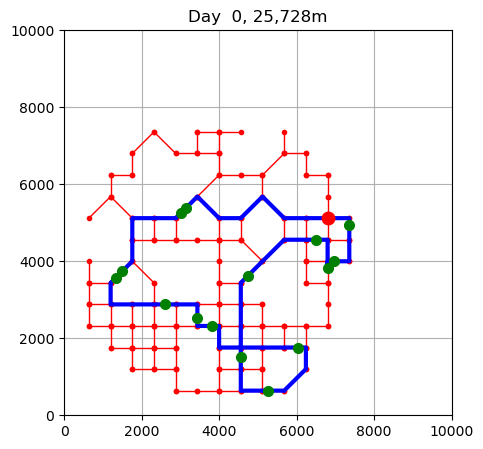

[ 0] 18:00:50.0 Parcel: 17 for customer 14 out for delivery
[ 0] 18:01:40.0 Parcel: 16 for customer 13 out for delivery
[ 0] 18:02:30.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:03:20.0 Parcel: 14 for customer 11 out for delivery
[ 0] 18:04:10.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:05:00.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:05:50.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:06:40.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:07:30.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:08:20.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:09:10.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:10:00.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:10:50.0 Parcel:  3 for customer 2 out for delivery
[ 0] 18:11:40.0 Parcel:  0 for customer 0 out for delivery
[ 0] 18:12:30.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:13:20.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:14:10.0 Parcel:  5 for customer 4 out for d

[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


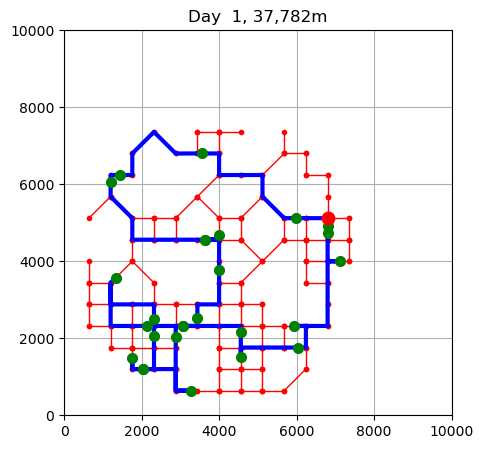

[ 1] 18:00:50.0 Parcel: 37 for customer 33 out for delivery
[ 1] 18:01:40.0 Parcel: 36 for customer 32 out for delivery
[ 1] 18:02:30.0 Parcel: 38 for customer 34 out for delivery
[ 1] 18:03:20.0 Parcel: 34 for customer 30 out for delivery
[ 1] 18:04:10.0 Parcel: 13 for customer 10 out for delivery
[ 1] 18:05:00.0 Parcel: 32 for customer 7 out for delivery
[ 1] 18:05:50.0 Parcel: 33 for customer 29 out for delivery
[ 1] 18:06:40.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:07:30.0 Parcel: 22 for customer 19 out for delivery
[ 1] 18:08:20.0 Parcel:  0 for customer 0 out for delivery
[ 1] 18:09:10.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:10:00.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:10:50.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:11:40.0 Parcel: 20 for customer 17 out for delivery
[ 1] 18:12:30.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:13:20.0 Parcel: 27 for customer 24 out for delivery
[ 1] 18:14:10.0 Parcel: 25 for customer 22

[ 1] 21:17:14.9 Parcel:  7 for customer 5 return from delivery
[ 1] 21:17:44.9 Parcel:  8 for customer 5 return from delivery
[ 1] 21:18:14.9 Parcel: 19 for customer 16 return from delivery
[ 1] 21:18:44.9 Parcel: 35 for customer 31 return from delivery
[ 1] 21:29:14.9 7 left over for next day
[ 1] 21:29:14.9 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arrived in deliver

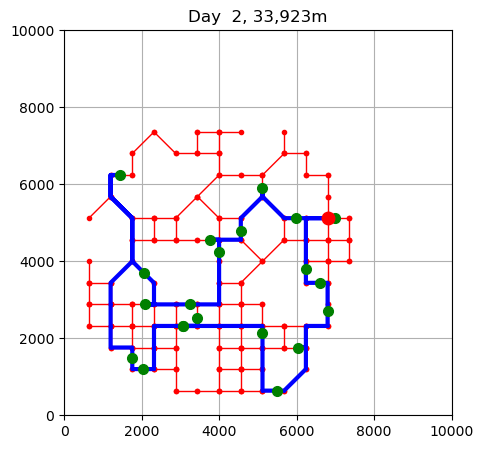

[ 2] 18:00:50.0 Parcel: 53 for customer 47 out for delivery
[ 2] 18:01:40.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:02:30.0 Parcel: 51 for customer 45 out for delivery
[ 2] 18:03:20.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:04:10.0 Parcel: 13 for customer 10 out for delivery
[ 2] 18:05:00.0 Parcel: 49 for customer 43 out for delivery
[ 2] 18:05:50.0 Parcel: 46 for customer 41 out for delivery
[ 2] 18:06:40.0 Parcel: 47 for customer 41 out for delivery
[ 2] 18:07:30.0 Parcel: 26 for customer 23 out for delivery
[ 2] 18:08:20.0 Parcel:  7 for customer 5 out for delivery
[ 2] 18:09:10.0 Parcel:  8 for customer 5 out for delivery
[ 2] 18:10:00.0 Parcel: 26 for customer 23 out for delivery
[ 2] 18:10:50.0 Parcel: 21 for customer 18 out for delivery
[ 2] 18:11:40.0 Parcel: 39 for customer 17 out for delivery
[ 2] 18:12:30.0 Parcel: 19 for customer 16 out for delivery
[ 2] 18:13:20.0 Parcel: 40 for customer 35 out for delivery
[ 2] 18:14:10.0 Parcel: 41 for customer 36

[ 3] 12:00:00.0 Parcel: 59 for customer 51 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 59 for customer 51 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arr at delive

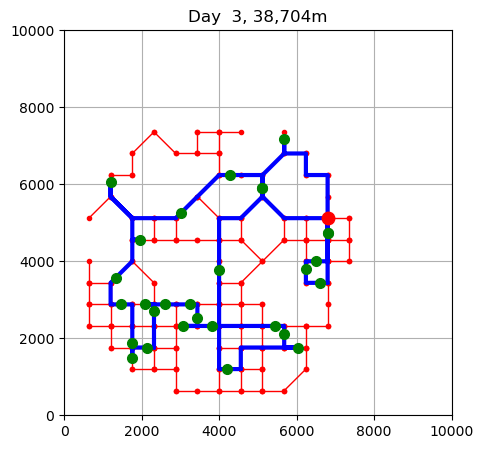

[ 3] 18:00:50.0 Parcel: 76 for customer 32 out for delivery
[ 3] 18:01:40.0 Parcel: 75 for customer 58 out for delivery
[ 3] 18:02:30.0 Parcel: 50 for customer 44 out for delivery
[ 3] 18:03:20.0 Parcel: 51 for customer 45 out for delivery
[ 3] 18:04:10.0 Parcel: 76 for customer 32 out for delivery
[ 3] 18:05:00.0 Parcel: 73 for customer 57 out for delivery
[ 3] 18:05:50.0 Parcel: 69 for customer 42 out for delivery
[ 3] 18:06:40.0 Parcel: 70 for customer 42 out for delivery
[ 3] 18:07:30.0 Parcel: 66 for customer 27 out for delivery
[ 3] 18:08:20.0 Parcel: 71 for customer 55 out for delivery
[ 3] 18:09:10.0 Parcel: 72 for customer 56 out for delivery
[ 3] 18:10:00.0 Parcel: 74 for customer 10 out for delivery
[ 3] 18:10:50.0 Parcel: 67 for customer 53 out for delivery
[ 3] 18:11:40.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:12:30.0 Parcel: 26 for customer 23 out for delivery
[ 3] 18:13:20.0 Parcel:  7 for customer 5 out for delivery
[ 3] 18:14:10.0 Parcel:  8 for customer 5 

[ 3] 21:26:59.3 Parcel: 70 for customer 42 return from delivery
[ 3] 21:27:29.3 Parcel: 66 for customer 27 return from delivery
[ 3] 21:27:59.3 Parcel: 72 for customer 56 return from delivery
[ 3] 21:28:29.3 Parcel: 74 for customer 10 return from delivery
[ 3] 21:28:59.3 Parcel: 65 for customer 6 return from delivery
[ 3] 21:29:29.3 Parcel: 63 for customer 37 return from delivery
[ 3] 21:29:59.3 Parcel: 60 for customer 52 return from delivery
[ 3] 21:30:29.3 Parcel: 57 for customer 49 return from delivery
[ 3] 21:40:59.3 10 left over for next day
[ 3] 21:40:59.3 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arrived in delivery centre
[ 4] 

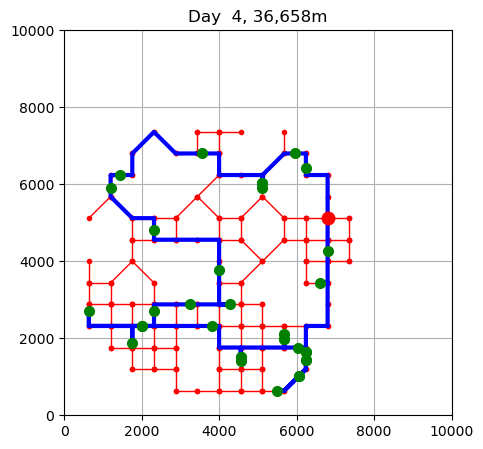

[ 4] 18:00:50.0 Parcel: 100 for customer 73 out for delivery
[ 4] 18:01:40.0 Parcel: 51 for customer 45 out for delivery
[ 4] 18:02:30.0 Parcel: 99 for customer 45 out for delivery
[ 4] 18:03:20.0 Parcel: 96 for customer 70 out for delivery
[ 4] 18:04:10.0 Parcel: 95 for customer 69 out for delivery
[ 4] 18:05:00.0 Parcel: 94 for customer 68 out for delivery
[ 4] 18:05:50.0 Parcel: 90 for customer 43 out for delivery
[ 4] 18:06:40.0 Parcel: 94 for customer 68 out for delivery
[ 4] 18:07:30.0 Parcel: 95 for customer 69 out for delivery
[ 4] 18:08:20.0 Parcel: 96 for customer 70 out for delivery
[ 4] 18:09:10.0 Parcel: 74 for customer 10 out for delivery
[ 4] 18:10:00.0 Parcel: 91 for customer 66 out for delivery
[ 4] 18:10:50.0 Parcel: 72 for customer 56 out for delivery
[ 4] 18:11:40.0 Parcel: 92 for customer 56 out for delivery
[ 4] 18:12:30.0 Parcel: 91 for customer 66 out for delivery
[ 4] 18:13:20.0 Parcel: 88 for customer 7 out for delivery
[ 4] 18:14:10.0 Parcel: 87 for customer 

[ 4] 21:27:59.3 Parcel: 65 for customer 6 return from delivery
[ 4] 21:28:29.3 Parcel: 82 for customer 61 return from delivery
[ 4] 21:28:59.3 Parcel: 77 for customer 59 return from delivery
[ 4] 21:29:29.3 Parcel: 57 for customer 49 return from delivery
[ 4] 21:29:59.3 Parcel: 81 for customer 49 return from delivery
[ 4] 21:30:29.3 Parcel: 82 for customer 61 return from delivery
[ 4] 21:30:59.3 Parcel: 86 for customer 63 return from delivery
[ 4] 21:31:29.3 Parcel: 66 for customer 27 return from delivery
[ 4] 21:31:59.3 Parcel: 78 for customer 60 return from delivery
[ 4] 21:32:29.3 Parcel: 79 for customer 60 return from delivery
[ 4] 21:32:59.3 Parcel: 80 for customer 16 return from delivery
[ 4] 21:33:29.3 Parcel: 85 for customer 25 return from delivery
[ 4] 21:33:59.3 Parcel: 89 for customer 65 return from delivery
[ 4] 21:34:29.3 Parcel: 69 for customer 42 return from delivery
[ 4] 21:34:59.3 Parcel: 70 for customer 42 return from delivery
[ 4] 21:45:29.3 19 left over for next day

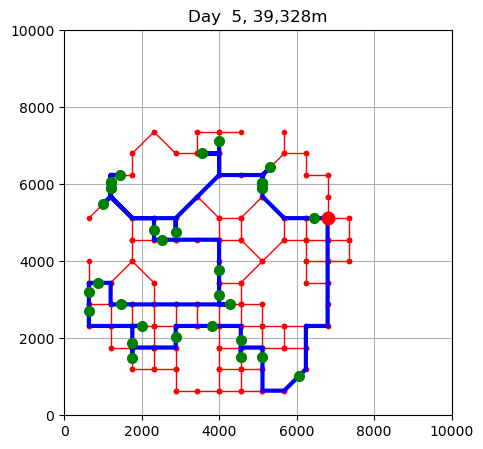

[ 5] 18:00:50.0 Parcel: 98 for customer 72 out for delivery
[ 5] 18:01:40.0 Parcel: 69 for customer 42 out for delivery
[ 5] 18:02:30.0 Parcel: 70 for customer 42 out for delivery
[ 5] 18:03:20.0 Parcel: 89 for customer 65 out for delivery
[ 5] 18:04:10.0 Parcel: 116 for customer 83 out for delivery
[ 5] 18:05:00.0 Parcel: 89 for customer 65 out for delivery
[ 5] 18:05:50.0 Parcel: 69 for customer 42 out for delivery
[ 5] 18:06:40.0 Parcel: 70 for customer 42 out for delivery
[ 5] 18:07:30.0 Parcel: 89 for customer 65 out for delivery
[ 5] 18:08:20.0 Parcel: 85 for customer 25 out for delivery
[ 5] 18:09:10.0 Parcel: 112 for customer 80 out for delivery
[ 5] 18:10:00.0 Parcel: 110 for customer 78 out for delivery
[ 5] 18:10:50.0 Parcel: 103 for customer 76 out for delivery
[ 5] 18:11:40.0 Parcel: 78 for customer 60 out for delivery
[ 5] 18:12:30.0 Parcel: 79 for customer 60 out for delivery
[ 5] 18:13:20.0 Parcel: 104 for customer 15 out for delivery
[ 5] 18:14:10.0 Parcel: 80 for cust

[ 5] 21:37:22.4 Parcel: 78 for customer 60 return from delivery
[ 5] 21:37:52.4 Parcel: 79 for customer 60 return from delivery
[ 5] 21:38:22.4 Parcel: 86 for customer 63 return from delivery
[ 5] 21:38:52.4 Parcel: 102 for customer 75 return from delivery
[ 5] 21:39:22.4 Parcel: 77 for customer 59 return from delivery
[ 5] 21:49:52.4 12 left over for next day
[ 5] 21:49:52.4 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 126 for customer 87 arr at 

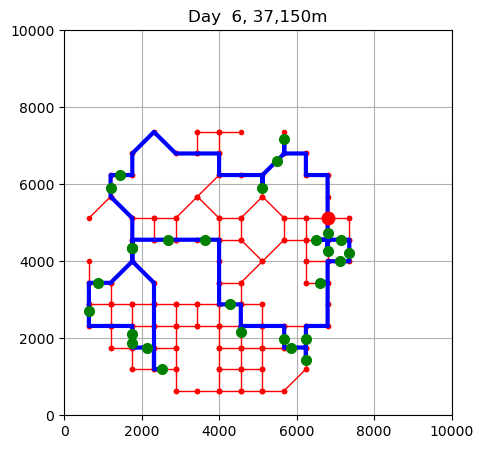

[ 6] 18:00:50.0 Parcel: 134 for customer 57 out for delivery
[ 6] 18:01:40.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:02:30.0 Parcel: 69 for customer 42 out for delivery
[ 6] 18:03:20.0 Parcel: 70 for customer 42 out for delivery
[ 6] 18:04:10.0 Parcel: 130 for customer 42 out for delivery
[ 6] 18:05:00.0 Parcel: 131 for customer 42 out for delivery
[ 6] 18:05:50.0 Parcel: 80 for customer 16 out for delivery
[ 6] 18:06:40.0 Parcel: 78 for customer 60 out for delivery
[ 6] 18:07:30.0 Parcel: 79 for customer 60 out for delivery
[ 6] 18:08:20.0 Parcel: 124 for customer 86 out for delivery
[ 6] 18:09:10.0 Parcel: 126 for customer 87 out for delivery
[ 6] 18:10:00.0 Parcel: 125 for customer 51 out for delivery
[ 6] 18:10:50.0 Parcel: 122 for customer 49 out for delivery
[ 6] 18:11:40.0 Parcel: 123 for customer 85 out for delivery
[ 6] 18:12:30.0 Parcel: 77 for customer 59 out for delivery
[ 6] 18:13:20.0 Parcel: 102 for customer 75 out for delivery
[ 6] 18:14:10.0 Parcel: 124 fo

[ 6] 21:24:16.5 Parcel: 77 for customer 59 return from delivery
[ 6] 21:24:46.5 Parcel: 124 for customer 86 return from delivery
[ 6] 21:25:16.5 Parcel: 127 for customer 88 return from delivery
[ 6] 21:25:46.5 Parcel: 129 for customer 29 return from delivery
[ 6] 21:26:16.5 Parcel: 133 for customer 66 return from delivery
[ 6] 21:26:46.5 Parcel: 135 for customer 90 return from delivery
[ 6] 21:27:16.5 Parcel: 141 for customer 45 return from delivery
[ 6] 21:27:46.5 Parcel: 121 for customer 84 return from delivery
[ 6] 21:28:16.5 Parcel: 140 for customer 11 return from delivery
[ 6] 21:38:46.5 14 left over for next day
[ 6] 21:38:46.5 Driver goes home

[ 7] 12:00:00.0 Parcel: 143 for customer 93 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 143 for customer 93 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 145 for customer 94 arr at delivery cent

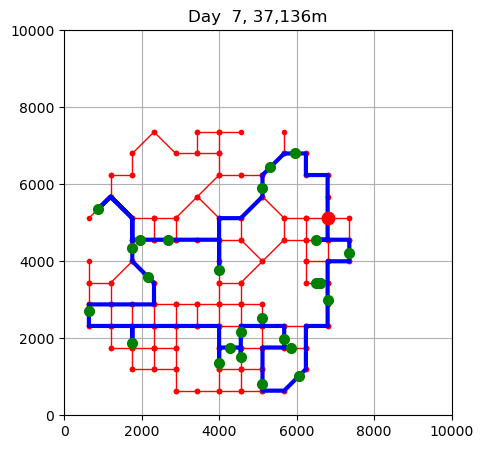

[ 7] 18:00:50.0 Parcel: 154 for customer 67 out for delivery
[ 7] 18:01:40.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:02:30.0 Parcel: 69 for customer 42 out for delivery
[ 7] 18:03:20.0 Parcel: 70 for customer 42 out for delivery
[ 7] 18:04:10.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:05:00.0 Parcel: 131 for customer 42 out for delivery
[ 7] 18:05:50.0 Parcel: 148 for customer 27 out for delivery
[ 7] 18:06:40.0 Parcel: 127 for customer 88 out for delivery
[ 7] 18:07:30.0 Parcel: 144 for customer 50 out for delivery
[ 7] 18:08:20.0 Parcel: 143 for customer 93 out for delivery
[ 7] 18:09:10.0 Parcel: 124 for customer 86 out for delivery
[ 7] 18:10:00.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:10:50.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:11:40.0 Parcel: 77 for customer 59 out for delivery
[ 7] 18:12:30.0 Parcel: 122 for customer 49 out for delivery
[ 7] 18:13:20.0 Parcel: 147 for customer 95 out for delivery
[ 7] 18:14:10.0 Parcel: 149

[ 7] 21:14:32.5 Parcel: 146 for customer 94 return from delivery
[ 7] 21:15:02.5 Parcel: 147 for customer 95 return from delivery
[ 7] 21:15:32.5 Parcel: 150 for customer 7 return from delivery
[ 7] 21:16:02.5 Parcel: 152 for customer 98 return from delivery
[ 7] 21:16:32.5 Parcel: 135 for customer 90 return from delivery
[ 7] 21:17:02.5 Parcel: 155 for customer 68 return from delivery
[ 7] 21:17:32.5 Parcel: 141 for customer 45 return from delivery
[ 7] 21:28:02.5 9 left over for next day
[ 7] 21:28:02.5 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 161 for customer 101 arr at deliv

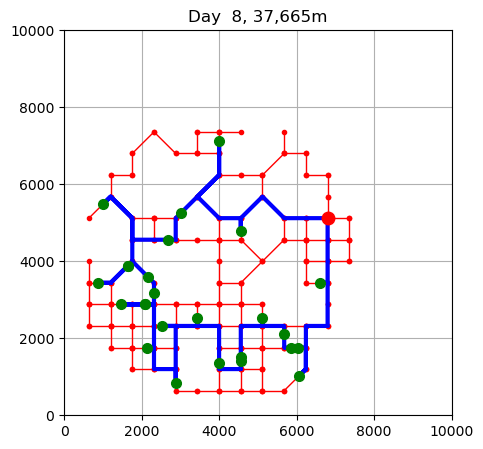

[ 8] 18:00:50.0 Parcel: 173 for customer 40 out for delivery
[ 8] 18:01:40.0 Parcel: 171 for customer 80 out for delivery
[ 8] 18:02:30.0 Parcel: 168 for customer 3 out for delivery
[ 8] 18:03:20.0 Parcel: 127 for customer 88 out for delivery
[ 8] 18:04:10.0 Parcel: 159 for customer 76 out for delivery
[ 8] 18:05:00.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:05:50.0 Parcel: 158 for customer 75 out for delivery
[ 8] 18:06:40.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:07:30.0 Parcel: 145 for customer 94 out for delivery
[ 8] 18:08:20.0 Parcel: 146 for customer 94 out for delivery
[ 8] 18:09:10.0 Parcel: 164 for customer 102 out for delivery
[ 8] 18:10:00.0 Parcel: 165 for customer 102 out for delivery
[ 8] 18:10:50.0 Parcel: 162 for customer 36 out for delivery
[ 8] 18:11:40.0 Parcel: 160 for customer 48 out for delivery
[ 8] 18:12:30.0 Parcel: 162 for customer 36 out for delivery
[ 8] 18:13:20.0 Parcel: 163 for customer 51 out for delivery
[ 8] 18:14:10.0 Parce

[ 8] 21:15:46.7 Parcel: 159 for customer 76 return from delivery
[ 8] 21:16:16.7 Parcel: 145 for customer 94 return from delivery
[ 8] 21:16:46.7 Parcel: 146 for customer 94 return from delivery
[ 8] 21:17:16.7 Parcel: 164 for customer 102 return from delivery
[ 8] 21:17:46.7 Parcel: 165 for customer 102 return from delivery
[ 8] 21:18:16.7 Parcel: 162 for customer 36 return from delivery
[ 8] 21:18:46.7 Parcel: 169 for customer 5 return from delivery
[ 8] 21:19:16.7 Parcel: 174 for customer 56 return from delivery
[ 8] 21:19:46.7 Parcel: 135 for customer 90 return from delivery
[ 8] 21:30:16.7 10 left over for next day
[ 8] 21:30:16.7 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arr at delivery

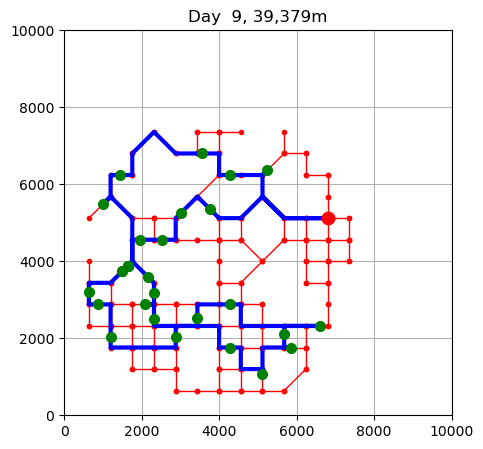

[ 9] 18:00:50.0 Parcel: 189 for customer 107 out for delivery
[ 9] 18:01:40.0 Parcel: 168 for customer 3 out for delivery
[ 9] 18:02:30.0 Parcel: 186 for customer 77 out for delivery
[ 9] 18:03:20.0 Parcel: 184 for customer 50 out for delivery
[ 9] 18:04:10.0 Parcel: 181 for customer 101 out for delivery
[ 9] 18:05:00.0 Parcel: 182 for customer 101 out for delivery
[ 9] 18:05:50.0 Parcel: 183 for customer 101 out for delivery
[ 9] 18:06:40.0 Parcel: 180 for customer 1 out for delivery
[ 9] 18:07:30.0 Parcel: 176 for customer 74 out for delivery
[ 9] 18:08:20.0 Parcel: 177 for customer 105 out for delivery
[ 9] 18:09:10.0 Parcel: 178 for customer 106 out for delivery
[ 9] 18:10:00.0 Parcel: 187 for customer 22 out for delivery
[ 9] 18:10:50.0 Parcel: 169 for customer 5 out for delivery
[ 9] 18:11:40.0 Parcel: 191 for customer 63 out for delivery
[ 9] 18:12:30.0 Parcel: 197 for customer 110 out for delivery
[ 9] 18:13:20.0 Parcel: 174 for customer 56 out for delivery
[ 9] 18:14:10.0 Parc

[ 9] 21:37:41.10 Parcel: 169 for customer 5 return from delivery
[ 9] 21:38:11.10 Parcel: 191 for customer 63 return from delivery
[ 9] 21:38:41.10 Parcel: 197 for customer 110 return from delivery
[ 9] 21:39:11.10 Parcel: 135 for customer 90 return from delivery
[ 9] 21:39:41.10 Parcel: 185 for customer 21 return from delivery
[ 9] 21:40:11.10 Parcel: 181 for customer 101 return from delivery
[ 9] 21:40:41.10 Parcel: 182 for customer 101 return from delivery
[ 9] 21:41:11.10 Parcel: 183 for customer 101 return from delivery
[ 9] 21:41:41.10 Parcel: 159 for customer 76 return from delivery
[ 9] 21:42:11.10 Parcel: 188 for customer 25 return from delivery
[ 9] 21:42:41.10 Parcel: 194 for customer 109 return from delivery
[ 9] 21:43:11.10 Parcel: 195 for customer 109 return from delivery
[ 9] 21:53:41.10 15 left over for next day
[ 9] 21:53:41.10 Driver goes home
Simulating the delivery of 198 parcels over 10 days to 150 customers

[ 0] 12:00:00.0 Parcel:  0 for customer 0 arr at deliver

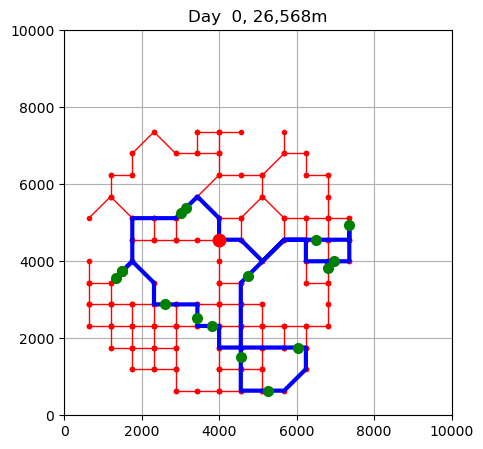

[ 0] 18:00:50.0 Parcel:  5 for customer 4 out for delivery
[ 0] 18:01:40.0 Parcel:  6 for customer 4 out for delivery
[ 0] 18:02:30.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:03:20.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:04:10.0 Parcel:  0 for customer 0 out for delivery
[ 0] 18:05:00.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:05:50.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:06:40.0 Parcel:  3 for customer 2 out for delivery
[ 0] 18:07:30.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:08:20.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:09:10.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:10:00.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:10:50.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:11:40.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:12:30.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:13:20.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:14:10.0 Parcel: 16 for customer 13 out for del

[ 1] 12:00:00.0 Parcel: 35 for customer 31 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 35 for customer 31 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 36 for customer 32 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 36 for customer 32 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


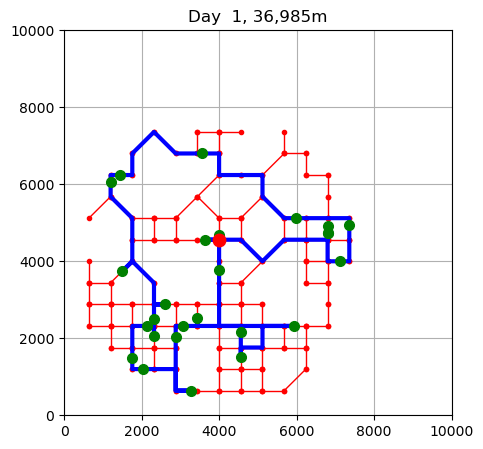

[ 1] 18:00:50.0 Parcel: 31 for customer 28 out for delivery
[ 1] 18:01:40.0 Parcel: 29 for customer 26 out for delivery
[ 1] 18:02:30.0 Parcel: 36 for customer 32 out for delivery
[ 1] 18:03:20.0 Parcel: 37 for customer 33 out for delivery
[ 1] 18:04:10.0 Parcel: 36 for customer 32 out for delivery
[ 1] 18:05:00.0 Parcel: 38 for customer 34 out for delivery
[ 1] 18:05:50.0 Parcel: 17 for customer 14 out for delivery
[ 1] 18:06:40.0 Parcel: 35 for customer 31 out for delivery
[ 1] 18:07:30.0 Parcel: 28 for customer 25 out for delivery
[ 1] 18:08:20.0 Parcel: 19 for customer 16 out for delivery
[ 1] 18:09:10.0 Parcel: 18 for customer 15 out for delivery
[ 1] 18:10:00.0 Parcel:  1 for customer 1 out for delivery
[ 1] 18:10:50.0 Parcel:  2 for customer 2 out for delivery
[ 1] 18:11:40.0 Parcel:  3 for customer 2 out for delivery
[ 1] 18:12:30.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:13:20.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:14:10.0 Parcel: 22 for customer 19 

[ 1] 21:13:11.8 Parcel: 17 for customer 14 return from delivery
[ 1] 21:13:41.8 Parcel: 19 for customer 16 return from delivery
[ 1] 21:14:11.8 Parcel: 24 for customer 21 return from delivery
[ 1] 21:14:41.8 Parcel: 23 for customer 20 return from delivery
[ 1] 21:15:11.8 Parcel: 22 for customer 19 return from delivery
[ 1] 21:15:41.8 Parcel:  7 for customer 5 return from delivery
[ 1] 21:16:11.8 Parcel:  8 for customer 5 return from delivery
[ 1] 21:26:41.8 9 left over for next day
[ 1] 21:26:41.8 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 

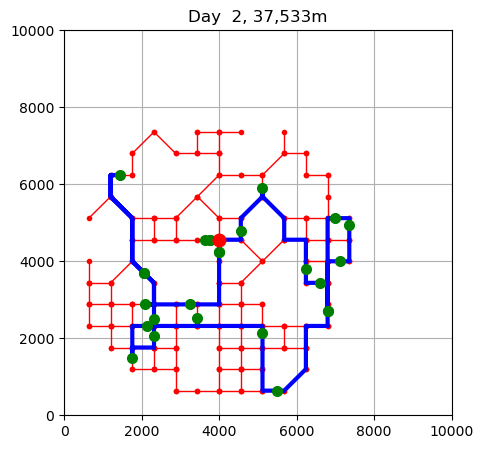

[ 2] 18:00:50.0 Parcel: 44 for customer 39 out for delivery
[ 2] 18:01:40.0 Parcel: 43 for customer 38 out for delivery
[ 2] 18:02:30.0 Parcel: 29 for customer 26 out for delivery
[ 2] 18:03:20.0 Parcel: 43 for customer 38 out for delivery
[ 2] 18:04:10.0 Parcel: 45 for customer 40 out for delivery
[ 2] 18:05:00.0 Parcel: 48 for customer 42 out for delivery
[ 2] 18:05:50.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:06:40.0 Parcel: 51 for customer 45 out for delivery
[ 2] 18:07:30.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:08:20.0 Parcel: 38 for customer 34 out for delivery
[ 2] 18:09:10.0 Parcel: 17 for customer 14 out for delivery
[ 2] 18:10:00.0 Parcel: 53 for customer 47 out for delivery
[ 2] 18:10:50.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:11:40.0 Parcel: 49 for customer 43 out for delivery
[ 2] 18:12:30.0 Parcel: 46 for customer 41 out for delivery
[ 2] 18:13:20.0 Parcel: 47 for customer 41 out for delivery
[ 2] 18:14:10.0 Parcel:  7 for customer 

[ 2] 21:15:06.3 Parcel: 48 for customer 42 return from delivery
[ 2] 21:15:36.3 Parcel: 49 for customer 43 return from delivery
[ 2] 21:16:06.3 Parcel:  7 for customer 5 return from delivery
[ 2] 21:16:36.3 Parcel:  8 for customer 5 return from delivery
[ 2] 21:17:06.3 Parcel: 40 for customer 35 return from delivery
[ 2] 21:17:36.3 Parcel: 40 for customer 35 return from delivery
[ 2] 21:28:06.3 8 left over for next day
[ 2] 21:28:06.3 Driver goes home

[ 3] 12:00:00.0 Parcel: 54 for customer 15 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 54 for customer 15 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 55 for customer 0 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 55 for customer 0 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 56 for customer 48 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 56 for customer 48 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 57 for customer 49 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 57 for customer 49 arrived in delivery centre
[

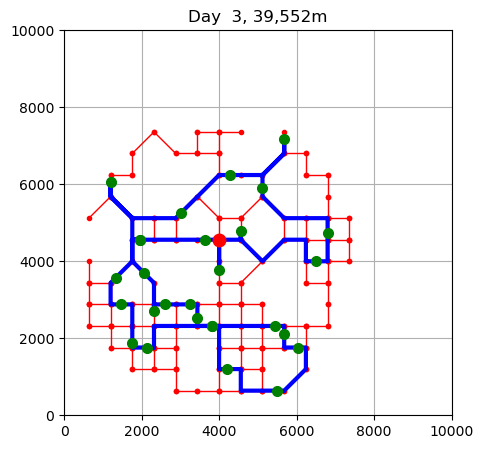

[ 3] 18:00:50.0 Parcel: 66 for customer 27 out for delivery
[ 3] 18:01:40.0 Parcel: 29 for customer 26 out for delivery
[ 3] 18:02:30.0 Parcel: 58 for customer 50 out for delivery
[ 3] 18:03:20.0 Parcel: 55 for customer 0 out for delivery
[ 3] 18:04:10.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:05:00.0 Parcel: 57 for customer 49 out for delivery
[ 3] 18:05:50.0 Parcel: 59 for customer 51 out for delivery
[ 3] 18:06:40.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:07:30.0 Parcel: 71 for customer 55 out for delivery
[ 3] 18:08:20.0 Parcel: 72 for customer 56 out for delivery
[ 3] 18:09:10.0 Parcel: 74 for customer 10 out for delivery
[ 3] 18:10:00.0 Parcel: 49 for customer 43 out for delivery
[ 3] 18:10:50.0 Parcel: 67 for customer 53 out for delivery
[ 3] 18:11:40.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:12:30.0 Parcel:  7 for customer 5 out for delivery
[ 3] 18:13:20.0 Parcel:  8 for customer 5 out for delivery
[ 3] 18:14:10.0 Parcel: 64 for customer 5 out

[ 3] 21:29:33.3 Parcel: 56 for customer 48 return from delivery
[ 3] 21:30:03.3 Parcel: 57 for customer 49 return from delivery
[ 3] 21:30:33.3 Parcel: 65 for customer 6 return from delivery
[ 3] 21:31:03.3 Parcel: 71 for customer 55 return from delivery
[ 3] 21:31:33.3 Parcel: 74 for customer 10 return from delivery
[ 3] 21:32:03.3 Parcel: 65 for customer 6 return from delivery
[ 3] 21:32:33.3 Parcel:  7 for customer 5 return from delivery
[ 3] 21:33:03.3 Parcel:  8 for customer 5 return from delivery
[ 3] 21:33:33.3 Parcel: 64 for customer 5 return from delivery
[ 3] 21:34:03.3 Parcel: 60 for customer 52 return from delivery
[ 3] 21:34:33.3 Parcel: 75 for customer 58 return from delivery
[ 3] 21:35:03.3 Parcel: 45 for customer 40 return from delivery
[ 3] 21:45:33.3 13 left over for next day
[ 3] 21:45:33.3 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 7

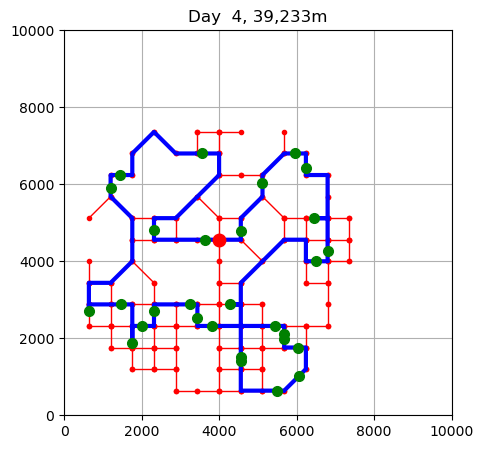

[ 4] 18:00:50.0 Parcel: 29 for customer 26 out for delivery
[ 4] 18:01:40.0 Parcel: 83 for customer 62 out for delivery
[ 4] 18:02:30.0 Parcel: 85 for customer 25 out for delivery
[ 4] 18:03:20.0 Parcel: 80 for customer 16 out for delivery
[ 4] 18:04:10.0 Parcel: 78 for customer 60 out for delivery
[ 4] 18:05:00.0 Parcel: 79 for customer 60 out for delivery
[ 4] 18:05:50.0 Parcel: 77 for customer 59 out for delivery
[ 4] 18:06:40.0 Parcel: 56 for customer 48 out for delivery
[ 4] 18:07:30.0 Parcel: 57 for customer 49 out for delivery
[ 4] 18:08:20.0 Parcel: 81 for customer 49 out for delivery
[ 4] 18:09:10.0 Parcel: 82 for customer 61 out for delivery
[ 4] 18:10:00.0 Parcel: 60 for customer 52 out for delivery
[ 4] 18:10:50.0 Parcel: 84 for customer 37 out for delivery
[ 4] 18:11:40.0 Parcel:  7 for customer 5 out for delivery
[ 4] 18:12:30.0 Parcel:  8 for customer 5 out for delivery
[ 4] 18:13:20.0 Parcel: 64 for customer 5 out for delivery
[ 4] 18:14:10.0 Parcel: 65 for customer 6 o

[ 4] 21:29:23.5 Parcel: 82 for customer 61 return from delivery
[ 4] 21:29:53.5 Parcel:  7 for customer 5 return from delivery
[ 4] 21:30:23.5 Parcel:  8 for customer 5 return from delivery
[ 4] 21:30:53.5 Parcel: 64 for customer 5 return from delivery
[ 4] 21:31:23.5 Parcel: 65 for customer 6 return from delivery
[ 4] 21:31:53.5 Parcel: 65 for customer 6 return from delivery
[ 4] 21:32:23.5 Parcel: 91 for customer 66 return from delivery
[ 4] 21:32:53.5 Parcel: 90 for customer 43 return from delivery
[ 4] 21:33:23.5 Parcel: 87 for customer 64 return from delivery
[ 4] 21:33:53.5 Parcel: 88 for customer 7 return from delivery
[ 4] 21:34:23.5 Parcel: 86 for customer 63 return from delivery
[ 4] 21:34:53.5 Parcel: 75 for customer 58 return from delivery
[ 4] 21:35:23.5 Parcel: 45 for customer 40 return from delivery
[ 4] 21:45:53.5 18 left over for next day
[ 4] 21:45:53.5 Driver goes home

[ 5] 12:00:00.0 Parcel: 101 for customer 74 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 101 for

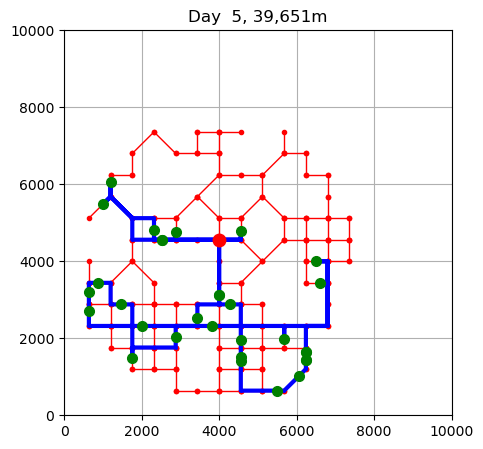

[ 5] 18:00:50.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:01:40.0 Parcel: 104 for customer 15 out for delivery
[ 5] 18:02:30.0 Parcel: 103 for customer 76 out for delivery
[ 5] 18:03:20.0 Parcel: 107 for customer 62 out for delivery
[ 5] 18:04:10.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:05:00.0 Parcel: 110 for customer 78 out for delivery
[ 5] 18:05:50.0 Parcel: 45 for customer 40 out for delivery
[ 5] 18:06:40.0 Parcel: 111 for customer 79 out for delivery
[ 5] 18:07:30.0 Parcel: 86 for customer 63 out for delivery
[ 5] 18:08:20.0 Parcel: 91 for customer 66 out for delivery
[ 5] 18:09:10.0 Parcel: 75 for customer 58 out for delivery
[ 5] 18:10:00.0 Parcel: 99 for customer 45 out for delivery
[ 5] 18:10:50.0 Parcel: 96 for customer 70 out for delivery
[ 5] 18:11:40.0 Parcel: 95 for customer 69 out for delivery
[ 5] 18:12:30.0 Parcel: 96 for customer 70 out for delivery
[ 5] 18:13:20.0 Parcel: 95 for customer 69 out for delivery
[ 5] 18:14:10.0 Parcel: 117 for c

[ 5] 21:31:06.6 Parcel: 95 for customer 69 return from delivery
[ 5] 21:31:36.6 Parcel: 114 for customer 81 return from delivery
[ 5] 21:32:06.6 Parcel: 65 for customer 6 return from delivery
[ 5] 21:32:36.6 Parcel: 65 for customer 6 return from delivery
[ 5] 21:33:06.6 Parcel: 101 for customer 74 return from delivery
[ 5] 21:33:36.6 Parcel: 56 for customer 48 return from delivery
[ 5] 21:34:06.6 Parcel: 105 for customer 48 return from delivery
[ 5] 21:34:36.6 Parcel: 109 for customer 22 return from delivery
[ 5] 21:35:06.6 Parcel: 111 for customer 79 return from delivery
[ 5] 21:45:36.6 19 left over for next day
[ 5] 21:45:36.6 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arr at delivery centre
[ 

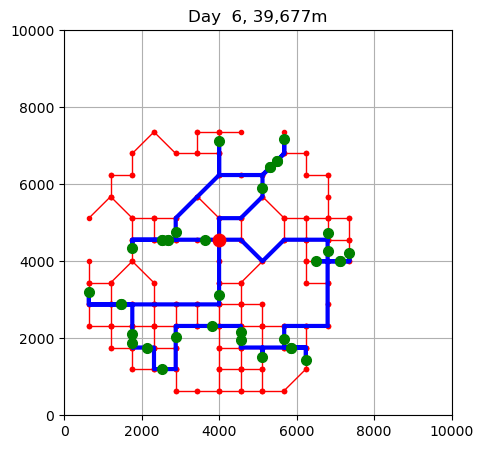

[ 6] 18:00:50.0 Parcel: 128 for customer 26 out for delivery
[ 6] 18:01:40.0 Parcel: 127 for customer 88 out for delivery
[ 6] 18:02:30.0 Parcel: 108 for customer 77 out for delivery
[ 6] 18:03:20.0 Parcel: 124 for customer 86 out for delivery
[ 6] 18:04:10.0 Parcel: 108 for customer 77 out for delivery
[ 6] 18:05:00.0 Parcel: 127 for customer 88 out for delivery
[ 6] 18:05:50.0 Parcel: 110 for customer 78 out for delivery
[ 6] 18:06:40.0 Parcel: 112 for customer 80 out for delivery
[ 6] 18:07:30.0 Parcel: 116 for customer 83 out for delivery
[ 6] 18:08:20.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:09:10.0 Parcel: 134 for customer 57 out for delivery
[ 6] 18:10:00.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:10:50.0 Parcel: 116 for customer 83 out for delivery
[ 6] 18:11:40.0 Parcel: 130 for customer 42 out for delivery
[ 6] 18:12:30.0 Parcel: 131 for customer 42 out for delivery
[ 6] 18:13:20.0 Parcel: 111 for customer 79 out for delivery
[ 6] 18:14:10.0 Parcel: 

[ 6] 21:46:58.2 Parcel: 134 for customer 57 return from delivery
[ 6] 21:47:28.2 Parcel: 132 for customer 89 return from delivery
[ 6] 21:47:58.2 Parcel: 56 for customer 48 return from delivery
[ 6] 21:48:28.2 Parcel: 105 for customer 48 return from delivery
[ 6] 21:48:58.2 Parcel: 125 for customer 51 return from delivery
[ 6] 21:49:28.2 Parcel: 109 for customer 22 return from delivery
[ 6] 21:49:58.2 Parcel: 95 for customer 69 return from delivery
[ 6] 21:50:28.2 Parcel: 136 for customer 69 return from delivery
[ 6] 21:50:58.2 Parcel: 137 for customer 69 return from delivery
[ 6] 21:51:28.2 Parcel: 138 for customer 69 return from delivery
[ 6] 21:51:58.2 Parcel: 121 for customer 84 return from delivery
[ 6] 21:52:28.2 Parcel: 75 for customer 58 return from delivery
[ 6] 21:52:58.2 Parcel: 119 for customer 32 return from delivery
[ 6] 22:03:28.2 20 left over for next day
[ 6] 22:03:28.2 Driver goes home

[ 7] 12:00:00.0 Parcel: 143 for customer 93 arr at delivery centre
[ 7] 12:00:00.0

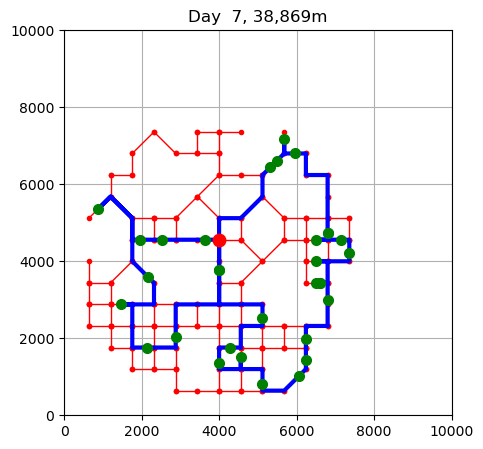

[ 7] 18:00:50.0 Parcel: 148 for customer 27 out for delivery
[ 7] 18:01:40.0 Parcel: 109 for customer 22 out for delivery
[ 7] 18:02:30.0 Parcel: 125 for customer 51 out for delivery
[ 7] 18:03:20.0 Parcel: 56 for customer 48 out for delivery
[ 7] 18:04:10.0 Parcel: 105 for customer 48 out for delivery
[ 7] 18:05:00.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:05:50.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:06:40.0 Parcel: 143 for customer 93 out for delivery
[ 7] 18:07:30.0 Parcel: 144 for customer 50 out for delivery
[ 7] 18:08:20.0 Parcel: 108 for customer 77 out for delivery
[ 7] 18:09:10.0 Parcel: 128 for customer 26 out for delivery
[ 7] 18:10:00.0 Parcel: 148 for customer 27 out for delivery
[ 7] 18:10:50.0 Parcel: 152 for customer 98 out for delivery
[ 7] 18:11:40.0 Parcel: 149 for customer 96 out for delivery
[ 7] 18:12:30.0 Parcel: 147 for customer 95 out for delivery
[ 7] 18:13:20.0 Parcel: 150 for customer 7 out for delivery
[ 7] 18:14:10.0 Parcel: 15

[ 7] 21:33:03.1 Parcel: 150 for customer 7 return from delivery
[ 7] 21:33:33.1 Parcel: 155 for customer 68 return from delivery
[ 7] 21:34:03.1 Parcel: 139 for customer 91 return from delivery
[ 7] 21:34:33.1 Parcel: 157 for customer 100 return from delivery
[ 7] 21:35:03.1 Parcel: 156 for customer 99 return from delivery
[ 7] 21:35:33.1 Parcel: 142 for customer 92 return from delivery
[ 7] 21:36:03.1 Parcel: 134 for customer 57 return from delivery
[ 7] 21:36:33.1 Parcel: 153 for customer 83 return from delivery
[ 7] 21:47:03.1 12 left over for next day
[ 7] 21:47:03.1 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arrived in delive

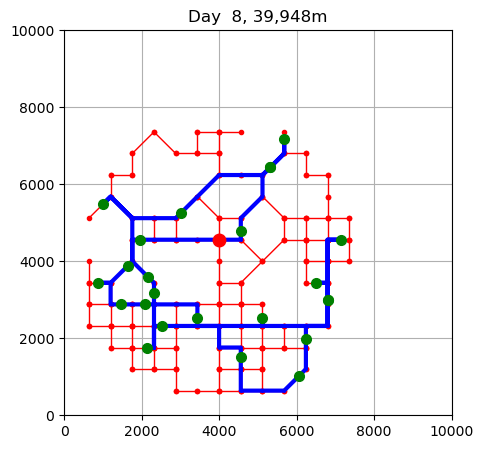

[ 8] 18:00:50.0 Parcel: 173 for customer 40 out for delivery
[ 8] 18:01:40.0 Parcel: 153 for customer 83 out for delivery
[ 8] 18:02:30.0 Parcel: 134 for customer 57 out for delivery
[ 8] 18:03:20.0 Parcel: 153 for customer 83 out for delivery
[ 8] 18:04:10.0 Parcel: 168 for customer 3 out for delivery
[ 8] 18:05:00.0 Parcel: 159 for customer 76 out for delivery
[ 8] 18:05:50.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:06:40.0 Parcel: 158 for customer 75 out for delivery
[ 8] 18:07:30.0 Parcel: 160 for customer 48 out for delivery
[ 8] 18:08:20.0 Parcel: 162 for customer 36 out for delivery
[ 8] 18:09:10.0 Parcel: 163 for customer 51 out for delivery
[ 8] 18:10:00.0 Parcel: 166 for customer 103 out for delivery
[ 8] 18:10:50.0 Parcel: 150 for customer 7 out for delivery
[ 8] 18:11:40.0 Parcel: 155 for customer 68 out for delivery
[ 8] 18:12:30.0 Parcel: 139 for customer 91 out for delivery
[ 8] 18:13:20.0 Parcel: 157 for customer 100 out for delivery
[ 8] 18:14:10.0 Parcel:

[ 8] 21:22:15.4 Parcel: 163 for customer 51 return from delivery
[ 8] 21:22:45.4 Parcel: 139 for customer 91 return from delivery
[ 8] 21:23:15.4 Parcel: 152 for customer 98 return from delivery
[ 8] 21:23:45.4 Parcel: 164 for customer 102 return from delivery
[ 8] 21:24:15.4 Parcel: 165 for customer 102 return from delivery
[ 8] 21:34:45.4 13 left over for next day
[ 8] 21:34:45.4 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 180 for customer 

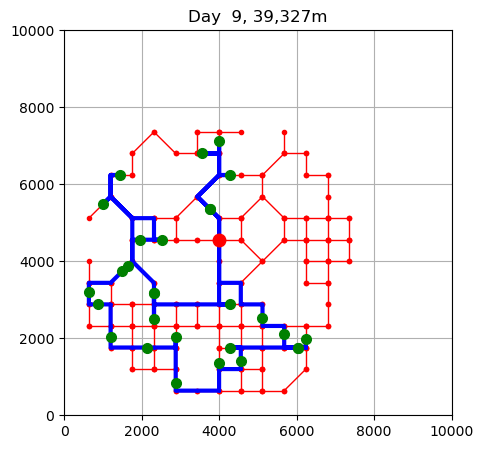

[ 9] 18:00:50.0 Parcel: 189 for customer 107 out for delivery
[ 9] 18:01:40.0 Parcel: 188 for customer 25 out for delivery
[ 9] 18:02:30.0 Parcel: 171 for customer 80 out for delivery
[ 9] 18:03:20.0 Parcel: 190 for customer 54 out for delivery
[ 9] 18:04:10.0 Parcel: 189 for customer 107 out for delivery
[ 9] 18:05:00.0 Parcel: 191 for customer 63 out for delivery
[ 9] 18:05:50.0 Parcel: 164 for customer 102 out for delivery
[ 9] 18:06:40.0 Parcel: 165 for customer 102 out for delivery
[ 9] 18:07:30.0 Parcel: 185 for customer 21 out for delivery
[ 9] 18:08:20.0 Parcel: 164 for customer 102 out for delivery
[ 9] 18:09:10.0 Parcel: 165 for customer 102 out for delivery
[ 9] 18:10:00.0 Parcel: 179 for customer 16 out for delivery
[ 9] 18:10:50.0 Parcel: 159 for customer 76 out for delivery
[ 9] 18:11:40.0 Parcel: 186 for customer 77 out for delivery
[ 9] 18:12:30.0 Parcel: 184 for customer 50 out for delivery
[ 9] 18:13:20.0 Parcel: 161 for customer 101 out for delivery
[ 9] 18:14:10.0 P

[ 9] 21:33:54.9 Parcel: 189 for customer 107 return from delivery
[ 9] 21:34:24.9 Parcel: 185 for customer 21 return from delivery
[ 9] 21:34:54.9 Parcel: 164 for customer 102 return from delivery
[ 9] 21:35:24.9 Parcel: 165 for customer 102 return from delivery
[ 9] 21:35:54.9 Parcel: 179 for customer 16 return from delivery
[ 9] 21:36:24.9 Parcel: 159 for customer 76 return from delivery
[ 9] 21:36:54.9 Parcel: 161 for customer 101 return from delivery
[ 9] 21:37:24.9 Parcel: 181 for customer 101 return from delivery
[ 9] 21:37:54.9 Parcel: 182 for customer 101 return from delivery
[ 9] 21:38:24.9 Parcel: 183 for customer 101 return from delivery
[ 9] 21:38:54.9 Parcel: 180 for customer 1 return from delivery
[ 9] 21:39:24.9 Parcel: 176 for customer 74 return from delivery
[ 9] 21:39:54.9 Parcel: 172 for customer 64 return from delivery
[ 9] 21:40:24.9 Parcel: 175 for customer 10 return from delivery
[ 9] 21:40:54.9 Parcel: 139 for customer 91 return from delivery
[ 9] 21:41:24.9 Par

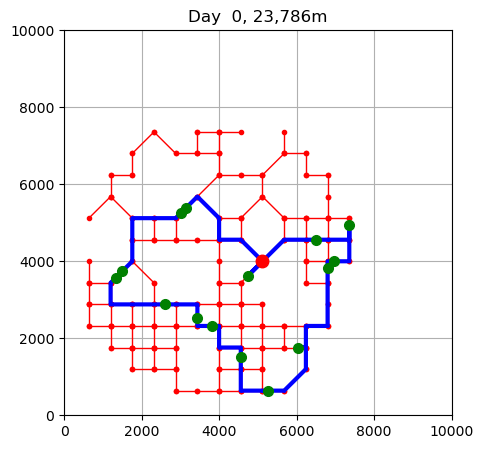

[ 0] 18:00:50.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:01:40.0 Parcel: 14 for customer 11 out for delivery
[ 0] 18:02:30.0 Parcel: 17 for customer 14 out for delivery
[ 0] 18:03:20.0 Parcel: 16 for customer 13 out for delivery
[ 0] 18:04:10.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:05:00.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:05:50.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:06:40.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:07:30.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:08:20.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:09:10.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:10:00.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:10:50.0 Parcel:  3 for customer 2 out for delivery
[ 0] 18:11:40.0 Parcel:  0 for customer 0 out for delivery
[ 0] 18:12:30.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:13:20.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:14:10.0 Parcel:  5 for customer 4 out for d

[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


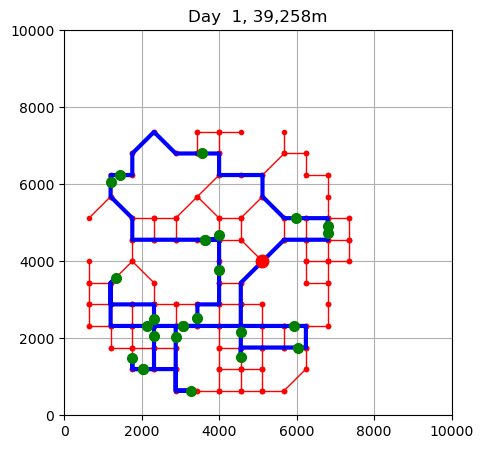

[ 1] 18:00:50.0 Parcel: 33 for customer 29 out for delivery
[ 1] 18:01:40.0 Parcel: 32 for customer 7 out for delivery
[ 1] 18:02:30.0 Parcel: 13 for customer 10 out for delivery
[ 1] 18:03:20.0 Parcel: 34 for customer 30 out for delivery
[ 1] 18:04:10.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:05:00.0 Parcel: 22 for customer 19 out for delivery
[ 1] 18:05:50.0 Parcel:  0 for customer 0 out for delivery
[ 1] 18:06:40.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:07:30.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:08:20.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:09:10.0 Parcel: 20 for customer 17 out for delivery
[ 1] 18:10:00.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:10:50.0 Parcel: 27 for customer 24 out for delivery
[ 1] 18:11:40.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:12:30.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:13:20.0 Parcel:  7 for customer 5 out for delivery
[ 1] 18:14:10.0 Parcel:  8 for customer 5 o

[ 1] 21:22:33.3 Parcel: 30 for customer 27 return from delivery
[ 1] 21:23:03.3 Parcel: 29 for customer 26 return from delivery
[ 1] 21:23:33.3 Parcel: 29 for customer 26 return from delivery
[ 1] 21:24:03.3 Parcel: 36 for customer 32 return from delivery
[ 1] 21:34:33.3 8 left over for next day
[ 1] 21:34:33.3 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arrived in deliv

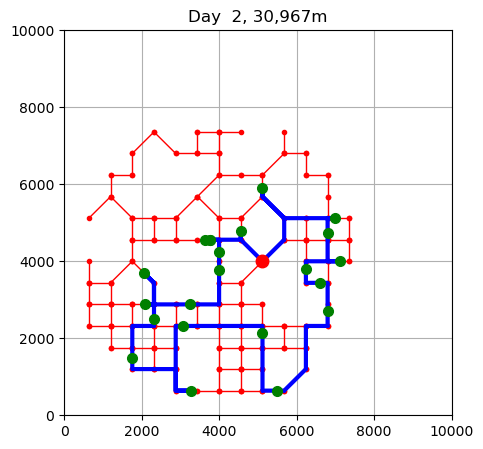

[ 2] 18:00:50.0 Parcel: 48 for customer 42 out for delivery
[ 2] 18:01:40.0 Parcel: 53 for customer 47 out for delivery
[ 2] 18:02:30.0 Parcel: 36 for customer 32 out for delivery
[ 2] 18:03:20.0 Parcel: 38 for customer 34 out for delivery
[ 2] 18:04:10.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:05:00.0 Parcel: 51 for customer 45 out for delivery
[ 2] 18:05:50.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:06:40.0 Parcel: 49 for customer 43 out for delivery
[ 2] 18:07:30.0 Parcel: 46 for customer 41 out for delivery
[ 2] 18:08:20.0 Parcel: 47 for customer 41 out for delivery
[ 2] 18:09:10.0 Parcel: 26 for customer 23 out for delivery
[ 2] 18:10:00.0 Parcel: 27 for customer 24 out for delivery
[ 2] 18:10:50.0 Parcel: 39 for customer 17 out for delivery
[ 2] 18:11:40.0 Parcel: 24 for customer 21 out for delivery
[ 2] 18:12:30.0 Parcel: 40 for customer 35 out for delivery
[ 2] 18:13:20.0 Parcel: 41 for customer 36 out for delivery
[ 2] 18:14:10.0 Parcel: 42 for customer 

[ 3] 12:00:00.0 Parcel: 58 for customer 50 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 58 for customer 50 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 59 for customer 51 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 59 for customer 51 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arr at deliv

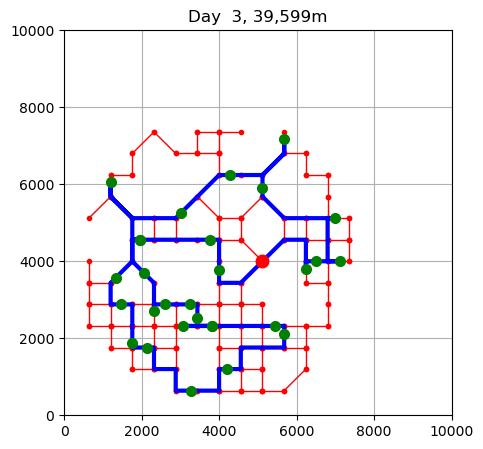

[ 3] 18:00:50.0 Parcel: 30 for customer 27 out for delivery
[ 3] 18:01:40.0 Parcel: 66 for customer 27 out for delivery
[ 3] 18:02:30.0 Parcel: 43 for customer 38 out for delivery
[ 3] 18:03:20.0 Parcel: 58 for customer 50 out for delivery
[ 3] 18:04:10.0 Parcel: 55 for customer 0 out for delivery
[ 3] 18:05:00.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:05:50.0 Parcel: 57 for customer 49 out for delivery
[ 3] 18:06:40.0 Parcel: 59 for customer 51 out for delivery
[ 3] 18:07:30.0 Parcel: 27 for customer 24 out for delivery
[ 3] 18:08:20.0 Parcel: 67 for customer 53 out for delivery
[ 3] 18:09:10.0 Parcel: 72 for customer 56 out for delivery
[ 3] 18:10:00.0 Parcel: 71 for customer 55 out for delivery
[ 3] 18:10:50.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:11:40.0 Parcel: 26 for customer 23 out for delivery
[ 3] 18:12:30.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:13:20.0 Parcel: 64 for customer 5 out for delivery
[ 3] 18:14:10.0 Parcel: 63 for customer 37 o

[ 3] 21:28:30.3 Parcel: 72 for customer 56 return from delivery
[ 3] 21:29:00.3 Parcel: 65 for customer 6 return from delivery
[ 3] 21:29:30.3 Parcel: 26 for customer 23 return from delivery
[ 3] 21:30:00.3 Parcel: 64 for customer 5 return from delivery
[ 3] 21:30:30.3 Parcel: 60 for customer 52 return from delivery
[ 3] 21:31:00.3 Parcel: 40 for customer 35 return from delivery
[ 3] 21:31:30.3 Parcel: 62 for customer 3 return from delivery
[ 3] 21:32:00.3 Parcel: 69 for customer 42 return from delivery
[ 3] 21:32:30.3 Parcel: 70 for customer 42 return from delivery
[ 3] 21:43:00.3 15 left over for next day
[ 3] 21:43:00.3 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arr at delivery centre
[ 4] 12:00:00

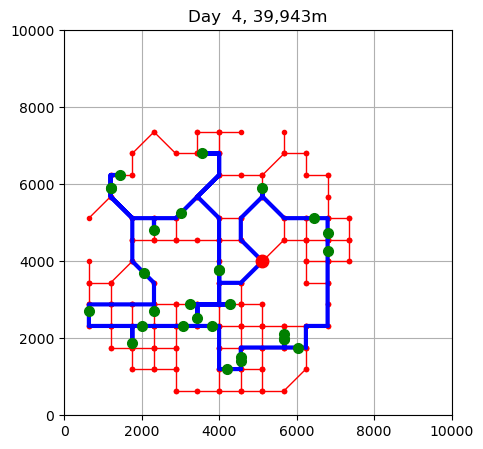

[ 4] 18:00:50.0 Parcel: 30 for customer 27 out for delivery
[ 4] 18:01:40.0 Parcel: 66 for customer 27 out for delivery
[ 4] 18:02:30.0 Parcel: 86 for customer 63 out for delivery
[ 4] 18:03:20.0 Parcel: 84 for customer 37 out for delivery
[ 4] 18:04:10.0 Parcel: 64 for customer 5 out for delivery
[ 4] 18:05:00.0 Parcel: 30 for customer 27 out for delivery
[ 4] 18:05:50.0 Parcel: 66 for customer 27 out for delivery
[ 4] 18:06:40.0 Parcel: 85 for customer 25 out for delivery
[ 4] 18:07:30.0 Parcel: 62 for customer 3 out for delivery
[ 4] 18:08:20.0 Parcel: 83 for customer 62 out for delivery
[ 4] 18:09:10.0 Parcel: 78 for customer 60 out for delivery
[ 4] 18:10:00.0 Parcel: 79 for customer 60 out for delivery
[ 4] 18:10:50.0 Parcel: 80 for customer 16 out for delivery
[ 4] 18:11:40.0 Parcel: 78 for customer 60 out for delivery
[ 4] 18:12:30.0 Parcel: 79 for customer 60 out for delivery
[ 4] 18:13:20.0 Parcel: 40 for customer 35 out for delivery
[ 4] 18:14:10.0 Parcel: 60 for customer 52

[ 4] 21:34:48.8 Parcel: 66 for customer 27 return from delivery
[ 4] 21:35:18.8 Parcel: 78 for customer 60 return from delivery
[ 4] 21:35:48.8 Parcel: 79 for customer 60 return from delivery
[ 4] 21:36:18.8 Parcel: 78 for customer 60 return from delivery
[ 4] 21:36:48.8 Parcel: 79 for customer 60 return from delivery
[ 4] 21:37:18.8 Parcel: 40 for customer 35 return from delivery
[ 4] 21:37:48.8 Parcel: 60 for customer 52 return from delivery
[ 4] 21:38:18.8 Parcel: 87 for customer 64 return from delivery
[ 4] 21:38:48.8 Parcel: 72 for customer 56 return from delivery
[ 4] 21:39:18.8 Parcel: 92 for customer 56 return from delivery
[ 4] 21:39:48.8 Parcel: 91 for customer 66 return from delivery
[ 4] 21:40:18.8 Parcel: 74 for customer 10 return from delivery
[ 4] 21:40:48.8 Parcel: 100 for customer 73 return from delivery
[ 4] 21:41:18.8 Parcel: 76 for customer 32 return from delivery
[ 4] 21:51:48.8 24 left over for next day
[ 4] 21:51:48.8 Driver goes home

[ 5] 12:00:00.0 Parcel: 101

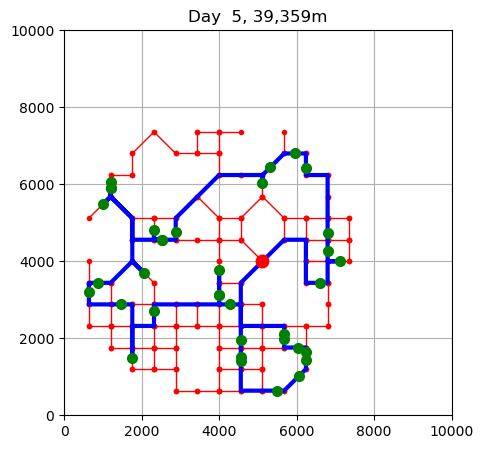

[ 5] 18:00:50.0 Parcel: 99 for customer 45 out for delivery
[ 5] 18:01:40.0 Parcel: 120 for customer 34 out for delivery
[ 5] 18:02:30.0 Parcel: 100 for customer 73 out for delivery
[ 5] 18:03:20.0 Parcel: 118 for customer 73 out for delivery
[ 5] 18:04:10.0 Parcel: 76 for customer 32 out for delivery
[ 5] 18:05:00.0 Parcel: 119 for customer 32 out for delivery
[ 5] 18:05:50.0 Parcel: 97 for customer 71 out for delivery
[ 5] 18:06:40.0 Parcel: 93 for customer 67 out for delivery
[ 5] 18:07:30.0 Parcel: 116 for customer 83 out for delivery
[ 5] 18:08:20.0 Parcel: 89 for customer 65 out for delivery
[ 5] 18:09:10.0 Parcel: 110 for customer 78 out for delivery
[ 5] 18:10:00.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:10:50.0 Parcel: 107 for customer 62 out for delivery
[ 5] 18:11:40.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:12:30.0 Parcel: 103 for customer 76 out for delivery
[ 5] 18:13:20.0 Parcel: 78 for customer 60 out for delivery
[ 5] 18:14:10.0 Parcel: 79 for

[ 5] 21:45:04.8 Parcel: 103 for customer 76 return from delivery
[ 5] 21:45:34.8 Parcel: 60 for customer 52 return from delivery
[ 5] 21:46:04.8 Parcel: 86 for customer 63 return from delivery
[ 5] 21:46:34.8 Parcel: 114 for customer 81 return from delivery
[ 5] 21:47:04.8 Parcel: 94 for customer 68 return from delivery
[ 5] 21:47:34.8 Parcel: 117 for customer 68 return from delivery
[ 5] 21:48:04.8 Parcel: 95 for customer 69 return from delivery
[ 5] 21:48:34.8 Parcel: 91 for customer 66 return from delivery
[ 5] 21:59:04.8 14 left over for next day
[ 5] 21:59:04.8 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arrived in delivery ce

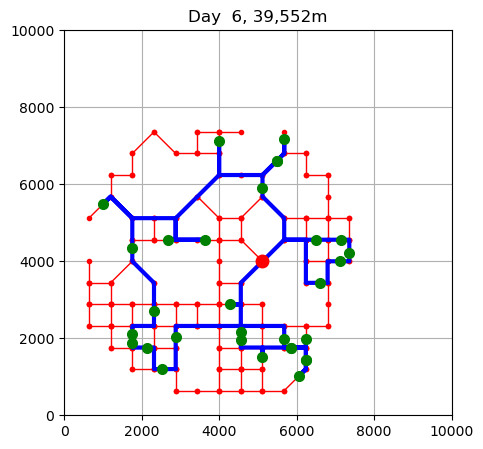

[ 6] 18:00:50.0 Parcel: 86 for customer 63 out for delivery
[ 6] 18:01:40.0 Parcel: 91 for customer 66 out for delivery
[ 6] 18:02:30.0 Parcel: 133 for customer 66 out for delivery
[ 6] 18:03:20.0 Parcel: 135 for customer 90 out for delivery
[ 6] 18:04:10.0 Parcel: 95 for customer 69 out for delivery
[ 6] 18:05:00.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:05:50.0 Parcel: 137 for customer 69 out for delivery
[ 6] 18:06:40.0 Parcel: 138 for customer 69 out for delivery
[ 6] 18:07:30.0 Parcel: 94 for customer 68 out for delivery
[ 6] 18:08:20.0 Parcel: 117 for customer 68 out for delivery
[ 6] 18:09:10.0 Parcel: 95 for customer 69 out for delivery
[ 6] 18:10:00.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:10:50.0 Parcel: 137 for customer 69 out for delivery
[ 6] 18:11:40.0 Parcel: 138 for customer 69 out for delivery
[ 6] 18:12:30.0 Parcel: 139 for customer 91 out for delivery
[ 6] 18:13:20.0 Parcel: 135 for customer 90 out for delivery
[ 6] 18:14:10.0 Parcel: 115 f

[ 6] 21:42:52.10 Parcel: 136 for customer 69 return from delivery
[ 6] 21:43:22.10 Parcel: 137 for customer 69 return from delivery
[ 6] 21:43:52.10 Parcel: 138 for customer 69 return from delivery
[ 6] 21:44:22.10 Parcel: 139 for customer 91 return from delivery
[ 6] 21:44:52.10 Parcel: 135 for customer 90 return from delivery
[ 6] 21:45:22.10 Parcel: 60 for customer 52 return from delivery
[ 6] 21:45:52.10 Parcel: 103 for customer 76 return from delivery
[ 6] 21:46:22.10 Parcel: 127 for customer 88 return from delivery
[ 6] 21:46:52.10 Parcel: 112 for customer 80 return from delivery
[ 6] 21:47:22.10 Parcel: 132 for customer 89 return from delivery
[ 6] 21:47:52.10 Parcel: 130 for customer 42 return from delivery
[ 6] 21:48:22.10 Parcel: 131 for customer 42 return from delivery
[ 6] 21:48:52.10 Parcel: 99 for customer 45 return from delivery
[ 6] 21:49:22.10 Parcel: 141 for customer 45 return from delivery
[ 6] 21:59:52.10 18 left over for next day
[ 6] 21:59:52.10 Driver goes home



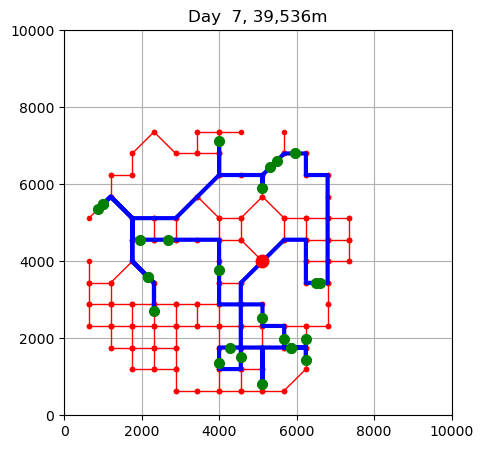

[ 7] 18:00:50.0 Parcel: 156 for customer 99 out for delivery
[ 7] 18:01:40.0 Parcel: 99 for customer 45 out for delivery
[ 7] 18:02:30.0 Parcel: 141 for customer 45 out for delivery
[ 7] 18:03:20.0 Parcel: 154 for customer 67 out for delivery
[ 7] 18:04:10.0 Parcel: 132 for customer 89 out for delivery
[ 7] 18:05:00.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:05:50.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:06:40.0 Parcel: 131 for customer 42 out for delivery
[ 7] 18:07:30.0 Parcel: 112 for customer 80 out for delivery
[ 7] 18:08:20.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:09:10.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:10:00.0 Parcel: 60 for customer 52 out for delivery
[ 7] 18:10:50.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:11:40.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:12:30.0 Parcel: 103 for customer 76 out for delivery
[ 7] 18:13:20.0 Parcel: 143 for customer 93 out for delivery
[ 7] 18:14:10.0 Parcel: 10

[ 7] 21:31:41.7 Parcel: 146 for customer 94 return from delivery
[ 7] 21:32:11.7 Parcel: 145 for customer 94 return from delivery
[ 7] 21:32:41.7 Parcel: 146 for customer 94 return from delivery
[ 7] 21:33:11.7 Parcel: 144 for customer 50 return from delivery
[ 7] 21:33:41.7 Parcel: 152 for customer 98 return from delivery
[ 7] 21:34:11.7 Parcel: 135 for customer 90 return from delivery
[ 7] 21:34:41.7 Parcel: 135 for customer 90 return from delivery
[ 7] 21:45:11.7 11 left over for next day
[ 7] 21:45:11.7 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 161 for customer 101 arr at del

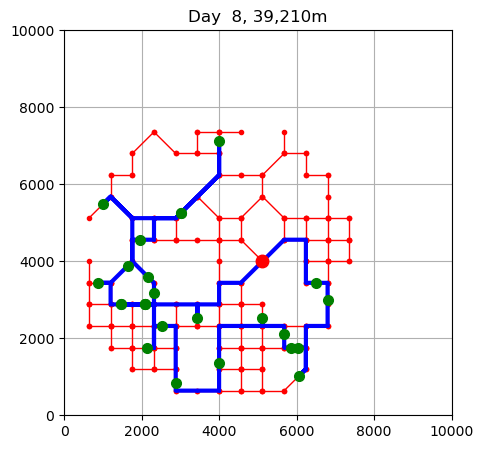

[ 8] 18:00:50.0 Parcel: 169 for customer 5 out for delivery
[ 8] 18:01:40.0 Parcel: 162 for customer 36 out for delivery
[ 8] 18:02:30.0 Parcel: 160 for customer 48 out for delivery
[ 8] 18:03:20.0 Parcel: 158 for customer 75 out for delivery
[ 8] 18:04:10.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:05:00.0 Parcel: 159 for customer 76 out for delivery
[ 8] 18:05:50.0 Parcel: 168 for customer 3 out for delivery
[ 8] 18:06:40.0 Parcel: 171 for customer 80 out for delivery
[ 8] 18:07:30.0 Parcel: 168 for customer 3 out for delivery
[ 8] 18:08:20.0 Parcel: 144 for customer 50 out for delivery
[ 8] 18:09:10.0 Parcel: 145 for customer 94 out for delivery
[ 8] 18:10:00.0 Parcel: 146 for customer 94 out for delivery
[ 8] 18:10:50.0 Parcel: 145 for customer 94 out for delivery
[ 8] 18:11:40.0 Parcel: 146 for customer 94 out for delivery
[ 8] 18:12:30.0 Parcel: 164 for customer 102 out for delivery
[ 8] 18:13:20.0 Parcel: 165 for customer 102 out for delivery
[ 8] 18:14:10.0 Parcel: 

[ 8] 21:24:52.9 Parcel: 165 for customer 102 return from delivery
[ 8] 21:25:22.9 Parcel: 163 for customer 51 return from delivery
[ 8] 21:25:52.9 Parcel: 170 for customer 95 return from delivery
[ 8] 21:26:22.9 Parcel: 174 for customer 56 return from delivery
[ 8] 21:26:52.9 Parcel: 157 for customer 100 return from delivery
[ 8] 21:37:22.9 9 left over for next day
[ 8] 21:37:22.9 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 180 for customer 1

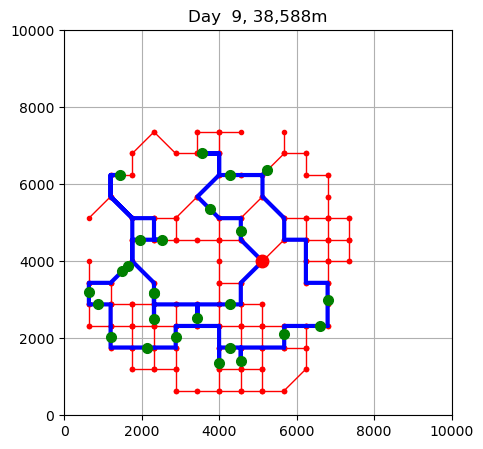

[ 9] 18:00:50.0 Parcel: 191 for customer 63 out for delivery
[ 9] 18:01:40.0 Parcel: 169 for customer 5 out for delivery
[ 9] 18:02:30.0 Parcel: 164 for customer 102 out for delivery
[ 9] 18:03:20.0 Parcel: 165 for customer 102 out for delivery
[ 9] 18:04:10.0 Parcel: 185 for customer 21 out for delivery
[ 9] 18:05:00.0 Parcel: 164 for customer 102 out for delivery
[ 9] 18:05:50.0 Parcel: 165 for customer 102 out for delivery
[ 9] 18:06:40.0 Parcel: 179 for customer 16 out for delivery
[ 9] 18:07:30.0 Parcel: 186 for customer 77 out for delivery
[ 9] 18:08:20.0 Parcel: 184 for customer 50 out for delivery
[ 9] 18:09:10.0 Parcel: 181 for customer 101 out for delivery
[ 9] 18:10:00.0 Parcel: 182 for customer 101 out for delivery
[ 9] 18:10:50.0 Parcel: 183 for customer 101 out for delivery
[ 9] 18:11:40.0 Parcel: 180 for customer 1 out for delivery
[ 9] 18:12:30.0 Parcel: 176 for customer 74 out for delivery
[ 9] 18:13:20.0 Parcel: 177 for customer 105 out for delivery
[ 9] 18:14:10.0 Pa

[ 9] 21:26:22.8 Parcel: 176 for customer 74 return from delivery
[ 9] 21:26:52.8 Parcel: 163 for customer 51 return from delivery
[ 9] 21:27:22.8 Parcel: 187 for customer 22 return from delivery
[ 9] 21:27:52.8 Parcel: 170 for customer 95 return from delivery
[ 9] 21:28:22.8 Parcel: 194 for customer 109 return from delivery
[ 9] 21:28:52.8 Parcel: 195 for customer 109 return from delivery
[ 9] 21:39:22.8 10 left over for next day
[ 9] 21:39:22.8 Driver goes home
Simulating the delivery of 198 parcels over 10 days to 150 customers

[ 0] 12:00:00.0 Parcel:  0 for customer 0 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  0 for customer 0 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  3 for customer 2 arr at delivery cen

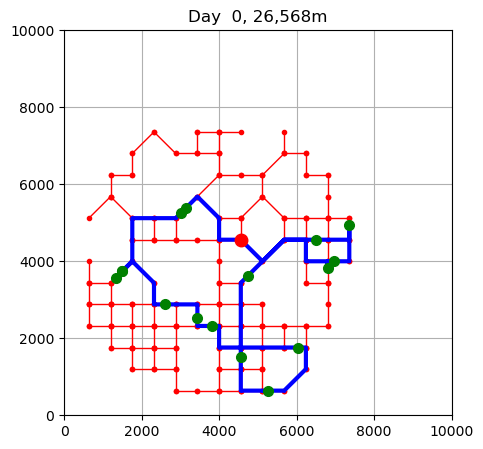

[ 0] 18:00:50.0 Parcel:  5 for customer 4 out for delivery
[ 0] 18:01:40.0 Parcel:  6 for customer 4 out for delivery
[ 0] 18:02:30.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:03:20.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:04:10.0 Parcel:  0 for customer 0 out for delivery
[ 0] 18:05:00.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:05:50.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:06:40.0 Parcel:  3 for customer 2 out for delivery
[ 0] 18:07:30.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:08:20.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:09:10.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:10:00.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:10:50.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:11:40.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:12:30.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:13:20.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:14:10.0 Parcel: 16 for customer 13 out for del

[ 1] 12:00:00.0 Parcel: 36 for customer 32 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 36 for customer 32 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


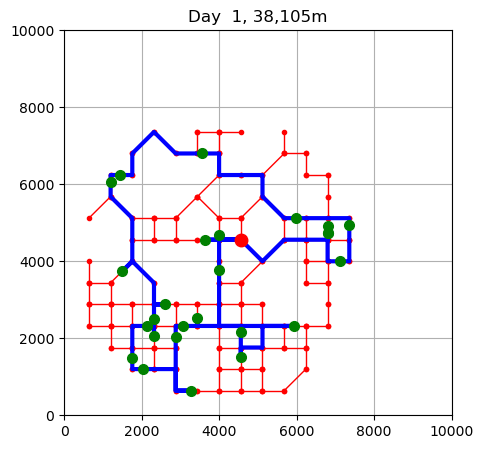

[ 1] 18:00:50.0 Parcel: 31 for customer 28 out for delivery
[ 1] 18:01:40.0 Parcel: 29 for customer 26 out for delivery
[ 1] 18:02:30.0 Parcel: 36 for customer 32 out for delivery
[ 1] 18:03:20.0 Parcel: 37 for customer 33 out for delivery
[ 1] 18:04:10.0 Parcel: 36 for customer 32 out for delivery
[ 1] 18:05:00.0 Parcel: 38 for customer 34 out for delivery
[ 1] 18:05:50.0 Parcel: 17 for customer 14 out for delivery
[ 1] 18:06:40.0 Parcel: 35 for customer 31 out for delivery
[ 1] 18:07:30.0 Parcel: 28 for customer 25 out for delivery
[ 1] 18:08:20.0 Parcel: 19 for customer 16 out for delivery
[ 1] 18:09:10.0 Parcel: 18 for customer 15 out for delivery
[ 1] 18:10:00.0 Parcel:  1 for customer 1 out for delivery
[ 1] 18:10:50.0 Parcel:  2 for customer 2 out for delivery
[ 1] 18:11:40.0 Parcel:  3 for customer 2 out for delivery
[ 1] 18:12:30.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:13:20.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:14:10.0 Parcel: 22 for customer 19 

[ 1] 21:18:10.6 Parcel: 19 for customer 16 return from delivery
[ 1] 21:18:40.6 Parcel: 24 for customer 21 return from delivery
[ 1] 21:19:10.6 Parcel: 23 for customer 20 return from delivery
[ 1] 21:19:40.6 Parcel: 22 for customer 19 return from delivery
[ 1] 21:20:10.6 Parcel:  7 for customer 5 return from delivery
[ 1] 21:20:40.6 Parcel:  8 for customer 5 return from delivery
[ 1] 21:31:10.6 9 left over for next day
[ 1] 21:31:10.6 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arrived in delivery centre

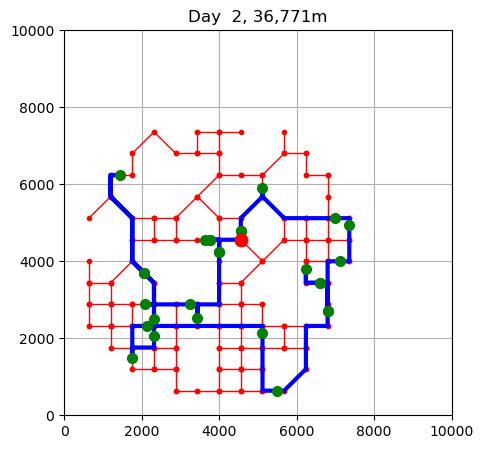

[ 2] 18:00:50.0 Parcel: 45 for customer 40 out for delivery
[ 2] 18:01:40.0 Parcel: 44 for customer 39 out for delivery
[ 2] 18:02:30.0 Parcel: 43 for customer 38 out for delivery
[ 2] 18:03:20.0 Parcel: 29 for customer 26 out for delivery
[ 2] 18:04:10.0 Parcel: 43 for customer 38 out for delivery
[ 2] 18:05:00.0 Parcel: 44 for customer 39 out for delivery
[ 2] 18:05:50.0 Parcel:  7 for customer 5 out for delivery
[ 2] 18:06:40.0 Parcel:  8 for customer 5 out for delivery
[ 2] 18:07:30.0 Parcel: 42 for customer 37 out for delivery
[ 2] 18:08:20.0 Parcel: 40 for customer 35 out for delivery
[ 2] 18:09:10.0 Parcel: 19 for customer 16 out for delivery
[ 2] 18:10:00.0 Parcel: 40 for customer 35 out for delivery
[ 2] 18:10:50.0 Parcel: 41 for customer 36 out for delivery
[ 2] 18:11:40.0 Parcel: 24 for customer 21 out for delivery
[ 2] 18:12:30.0 Parcel: 23 for customer 20 out for delivery
[ 2] 18:13:20.0 Parcel: 39 for customer 17 out for delivery
[ 2] 18:14:10.0 Parcel: 22 for customer 19

[ 2] 21:15:42.9 Parcel: 19 for customer 16 return from delivery
[ 2] 21:16:12.9 Parcel: 41 for customer 36 return from delivery
[ 2] 21:16:42.9 Parcel: 24 for customer 21 return from delivery
[ 2] 21:17:12.9 Parcel: 22 for customer 19 return from delivery
[ 2] 21:17:42.9 Parcel: 49 for customer 43 return from delivery
[ 2] 21:18:12.9 Parcel: 52 for customer 46 return from delivery
[ 2] 21:18:42.9 Parcel: 17 for customer 14 return from delivery
[ 2] 21:29:12.9 11 left over for next day
[ 2] 21:29:12.9 Driver goes home

[ 3] 12:00:00.0 Parcel: 54 for customer 15 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 54 for customer 15 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 55 for customer 0 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 55 for customer 0 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 56 for customer 48 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 56 for customer 48 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 57 for customer 49 arr at delivery centre
[ 3]

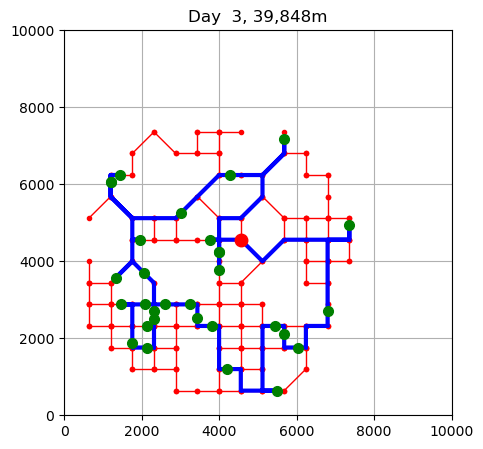

[ 3] 18:00:50.0 Parcel: 17 for customer 14 out for delivery
[ 3] 18:01:40.0 Parcel: 52 for customer 46 out for delivery
[ 3] 18:02:30.0 Parcel: 74 for customer 10 out for delivery
[ 3] 18:03:20.0 Parcel: 72 for customer 56 out for delivery
[ 3] 18:04:10.0 Parcel: 71 for customer 55 out for delivery
[ 3] 18:05:00.0 Parcel: 49 for customer 43 out for delivery
[ 3] 18:05:50.0 Parcel: 67 for customer 53 out for delivery
[ 3] 18:06:40.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:07:30.0 Parcel: 64 for customer 5 out for delivery
[ 3] 18:08:20.0 Parcel: 63 for customer 37 out for delivery
[ 3] 18:09:10.0 Parcel: 61 for customer 2 out for delivery
[ 3] 18:10:00.0 Parcel: 41 for customer 36 out for delivery
[ 3] 18:10:50.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:11:40.0 Parcel: 57 for customer 49 out for delivery
[ 3] 18:12:30.0 Parcel: 59 for customer 51 out for delivery
[ 3] 18:13:20.0 Parcel: 22 for customer 19 out for delivery
[ 3] 18:14:10.0 Parcel: 24 for customer 21 

[ 3] 21:32:18.8 Parcel: 65 for customer 6 return from delivery
[ 3] 21:32:48.8 Parcel: 64 for customer 5 return from delivery
[ 3] 21:33:18.8 Parcel: 61 for customer 2 return from delivery
[ 3] 21:33:48.8 Parcel: 57 for customer 49 return from delivery
[ 3] 21:34:18.8 Parcel: 59 for customer 51 return from delivery
[ 3] 21:34:48.8 Parcel: 60 for customer 52 return from delivery
[ 3] 21:35:18.8 Parcel: 58 for customer 50 return from delivery
[ 3] 21:45:48.8 14 left over for next day
[ 3] 21:45:48.8 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 80 for customer 16 arr at delivery centre
[ 4] 

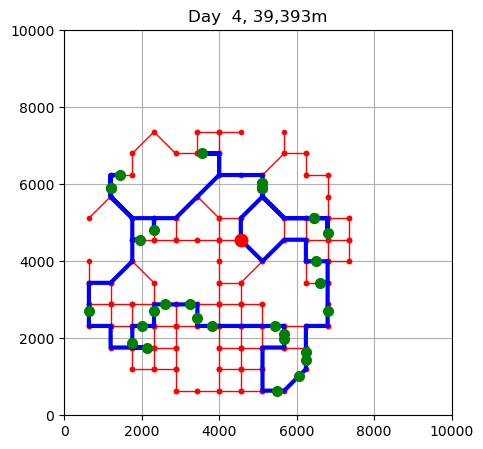

[ 4] 18:00:50.0 Parcel: 69 for customer 42 out for delivery
[ 4] 18:01:40.0 Parcel: 70 for customer 42 out for delivery
[ 4] 18:02:30.0 Parcel: 89 for customer 65 out for delivery
[ 4] 18:03:20.0 Parcel: 69 for customer 42 out for delivery
[ 4] 18:04:10.0 Parcel: 70 for customer 42 out for delivery
[ 4] 18:05:00.0 Parcel: 98 for customer 72 out for delivery
[ 4] 18:05:50.0 Parcel: 76 for customer 32 out for delivery
[ 4] 18:06:40.0 Parcel: 98 for customer 72 out for delivery
[ 4] 18:07:30.0 Parcel: 69 for customer 42 out for delivery
[ 4] 18:08:20.0 Parcel: 70 for customer 42 out for delivery
[ 4] 18:09:10.0 Parcel: 89 for customer 65 out for delivery
[ 4] 18:10:00.0 Parcel: 85 for customer 25 out for delivery
[ 4] 18:10:50.0 Parcel: 83 for customer 62 out for delivery
[ 4] 18:11:40.0 Parcel: 78 for customer 60 out for delivery
[ 4] 18:12:30.0 Parcel: 79 for customer 60 out for delivery
[ 4] 18:13:20.0 Parcel: 80 for customer 16 out for delivery
[ 4] 18:14:10.0 Parcel: 78 for customer 

[ 4] 21:38:43.6 Parcel: 79 for customer 60 return from delivery
[ 4] 21:39:13.6 Parcel: 58 for customer 50 return from delivery
[ 4] 21:39:43.6 Parcel: 77 for customer 59 return from delivery
[ 4] 21:40:13.6 Parcel: 59 for customer 51 return from delivery
[ 4] 21:40:43.6 Parcel: 60 for customer 52 return from delivery
[ 4] 21:41:13.6 Parcel: 61 for customer 2 return from delivery
[ 4] 21:41:43.6 Parcel: 64 for customer 5 return from delivery
[ 4] 21:42:13.6 Parcel: 65 for customer 6 return from delivery
[ 4] 21:42:43.6 Parcel: 71 for customer 55 return from delivery
[ 4] 21:43:13.6 Parcel: 92 for customer 56 return from delivery
[ 4] 21:43:43.6 Parcel: 91 for customer 66 return from delivery
[ 4] 21:54:13.6 19 left over for next day
[ 4] 21:54:13.6 Driver goes home

[ 5] 12:00:00.0 Parcel: 101 for customer 74 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 101 for customer 74 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arr at delivery centre
[ 5] 12:00:00.0 Pa

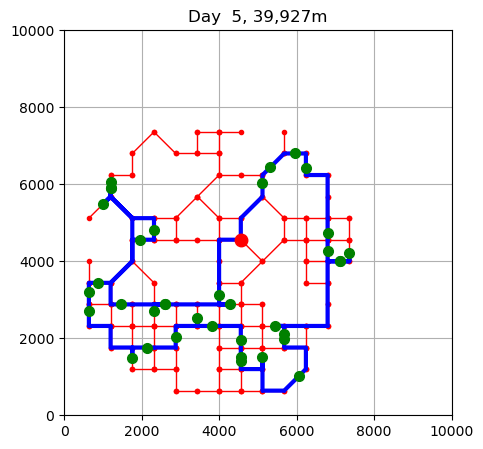

[ 5] 18:00:50.0 Parcel: 111 for customer 79 out for delivery
[ 5] 18:01:40.0 Parcel: 86 for customer 63 out for delivery
[ 5] 18:02:30.0 Parcel: 61 for customer 2 out for delivery
[ 5] 18:03:20.0 Parcel: 60 for customer 52 out for delivery
[ 5] 18:04:10.0 Parcel: 61 for customer 2 out for delivery
[ 5] 18:05:00.0 Parcel: 105 for customer 48 out for delivery
[ 5] 18:05:50.0 Parcel: 103 for customer 76 out for delivery
[ 5] 18:06:40.0 Parcel: 78 for customer 60 out for delivery
[ 5] 18:07:30.0 Parcel: 79 for customer 60 out for delivery
[ 5] 18:08:20.0 Parcel: 104 for customer 15 out for delivery
[ 5] 18:09:10.0 Parcel: 78 for customer 60 out for delivery
[ 5] 18:10:00.0 Parcel: 79 for customer 60 out for delivery
[ 5] 18:10:50.0 Parcel: 107 for customer 62 out for delivery
[ 5] 18:11:40.0 Parcel: 58 for customer 50 out for delivery
[ 5] 18:12:30.0 Parcel: 102 for customer 75 out for delivery
[ 5] 18:13:20.0 Parcel: 101 for customer 74 out for delivery
[ 5] 18:14:10.0 Parcel: 77 for cust

[ 5] 21:42:50.9 Parcel: 79 for customer 60 return from delivery
[ 5] 21:43:20.9 Parcel: 58 for customer 50 return from delivery
[ 5] 21:43:50.9 Parcel: 59 for customer 51 return from delivery
[ 5] 21:44:20.9 Parcel: 64 for customer 5 return from delivery
[ 5] 21:44:50.9 Parcel: 114 for customer 81 return from delivery
[ 5] 21:45:20.9 Parcel: 117 for customer 68 return from delivery
[ 5] 21:45:50.9 Parcel: 92 for customer 56 return from delivery
[ 5] 21:46:20.9 Parcel: 71 for customer 55 return from delivery
[ 5] 21:46:50.9 Parcel: 120 for customer 34 return from delivery
[ 5] 21:47:20.9 Parcel: 119 for customer 32 return from delivery
[ 5] 21:57:50.9 15 left over for next day
[ 5] 21:57:50.9 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 

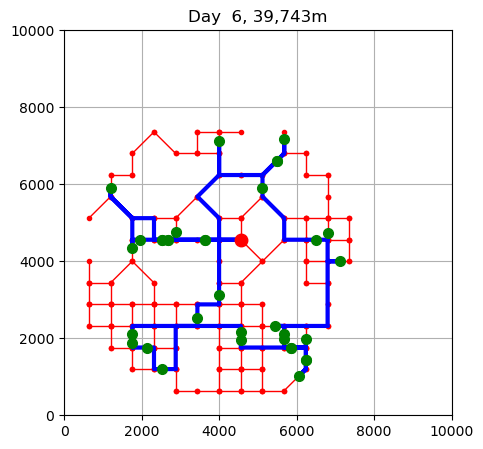

[ 6] 18:00:50.0 Parcel: 112 for customer 80 out for delivery
[ 6] 18:01:40.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:02:30.0 Parcel: 134 for customer 57 out for delivery
[ 6] 18:03:20.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:04:10.0 Parcel: 130 for customer 42 out for delivery
[ 6] 18:05:00.0 Parcel: 131 for customer 42 out for delivery
[ 6] 18:05:50.0 Parcel: 140 for customer 11 out for delivery
[ 6] 18:06:40.0 Parcel: 119 for customer 32 out for delivery
[ 6] 18:07:30.0 Parcel: 120 for customer 34 out for delivery
[ 6] 18:08:20.0 Parcel: 71 for customer 55 out for delivery
[ 6] 18:09:10.0 Parcel: 92 for customer 56 out for delivery
[ 6] 18:10:00.0 Parcel: 133 for customer 66 out for delivery
[ 6] 18:10:50.0 Parcel: 135 for customer 90 out for delivery
[ 6] 18:11:40.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:12:30.0 Parcel: 137 for customer 69 out for delivery
[ 6] 18:13:20.0 Parcel: 138 for customer 69 out for delivery
[ 6] 18:14:10.0 Parcel: 11

[ 6] 21:45:22.10 Parcel: 92 for customer 56 return from delivery
[ 6] 21:45:52.10 Parcel: 136 for customer 69 return from delivery
[ 6] 21:46:22.10 Parcel: 137 for customer 69 return from delivery
[ 6] 21:46:52.10 Parcel: 138 for customer 69 return from delivery
[ 6] 21:47:22.10 Parcel: 117 for customer 68 return from delivery
[ 6] 21:47:52.10 Parcel: 136 for customer 69 return from delivery
[ 6] 21:48:22.10 Parcel: 137 for customer 69 return from delivery
[ 6] 21:48:52.10 Parcel: 138 for customer 69 return from delivery
[ 6] 21:49:22.10 Parcel: 123 for customer 85 return from delivery
[ 6] 21:49:52.10 Parcel: 59 for customer 51 return from delivery
[ 6] 21:50:22.10 Parcel: 125 for customer 51 return from delivery
[ 6] 21:50:52.10 Parcel: 108 for customer 77 return from delivery
[ 6] 21:51:22.10 Parcel: 124 for customer 86 return from delivery
[ 6] 21:51:52.10 Parcel: 110 for customer 78 return from delivery
[ 6] 22:02:22.10 20 left over for next day
[ 6] 22:02:22.10 Driver goes home



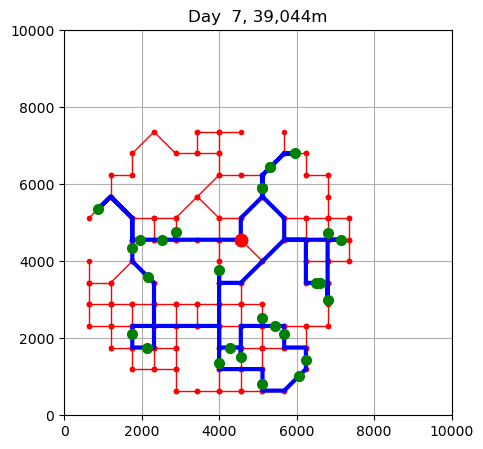

[ 7] 18:00:50.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:01:40.0 Parcel: 131 for customer 42 out for delivery
[ 7] 18:02:30.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:03:20.0 Parcel: 154 for customer 67 out for delivery
[ 7] 18:04:10.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:05:00.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:05:50.0 Parcel: 131 for customer 42 out for delivery
[ 7] 18:06:40.0 Parcel: 156 for customer 99 out for delivery
[ 7] 18:07:30.0 Parcel: 141 for customer 45 out for delivery
[ 7] 18:08:20.0 Parcel: 157 for customer 100 out for delivery
[ 7] 18:09:10.0 Parcel: 119 for customer 32 out for delivery
[ 7] 18:10:00.0 Parcel: 142 for customer 92 out for delivery
[ 7] 18:10:50.0 Parcel: 148 for customer 27 out for delivery
[ 7] 18:11:40.0 Parcel: 147 for customer 95 out for delivery
[ 7] 18:12:30.0 Parcel: 151 for customer 97 out for delivery
[ 7] 18:13:20.0 Parcel: 117 for customer 68 out for delivery
[ 7] 18:14:10.0 Parcel:

[ 7] 21:32:56.1 Parcel: 151 for customer 97 return from delivery
[ 7] 21:33:26.1 Parcel: 117 for customer 68 return from delivery
[ 7] 21:33:56.1 Parcel: 155 for customer 68 return from delivery
[ 7] 21:34:26.1 Parcel: 92 for customer 56 return from delivery
[ 7] 21:34:56.1 Parcel: 150 for customer 7 return from delivery
[ 7] 21:35:26.1 Parcel: 145 for customer 94 return from delivery
[ 7] 21:35:56.1 Parcel: 146 for customer 94 return from delivery
[ 7] 21:36:26.1 Parcel: 144 for customer 50 return from delivery
[ 7] 21:46:56.1 10 left over for next day
[ 7] 21:46:56.1 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arrived in delivery

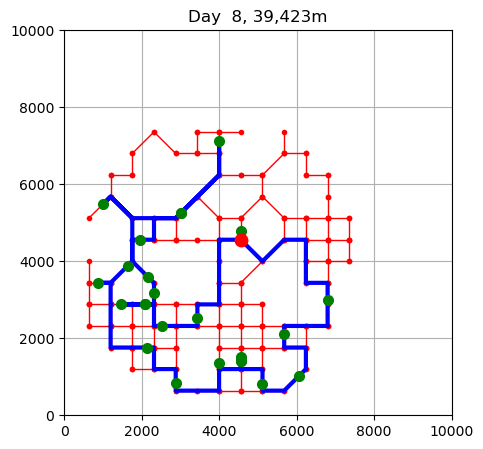

[ 8] 18:00:50.0 Parcel: 173 for customer 40 out for delivery
[ 8] 18:01:40.0 Parcel: 157 for customer 100 out for delivery
[ 8] 18:02:30.0 Parcel: 92 for customer 56 out for delivery
[ 8] 18:03:20.0 Parcel: 174 for customer 56 out for delivery
[ 8] 18:04:10.0 Parcel: 117 for customer 68 out for delivery
[ 8] 18:05:00.0 Parcel: 155 for customer 68 out for delivery
[ 8] 18:05:50.0 Parcel: 151 for customer 97 out for delivery
[ 8] 18:06:40.0 Parcel: 172 for customer 64 out for delivery
[ 8] 18:07:30.0 Parcel: 150 for customer 7 out for delivery
[ 8] 18:08:20.0 Parcel: 172 for customer 64 out for delivery
[ 8] 18:09:10.0 Parcel: 147 for customer 95 out for delivery
[ 8] 18:10:00.0 Parcel: 170 for customer 95 out for delivery
[ 8] 18:10:50.0 Parcel: 167 for customer 104 out for delivery
[ 8] 18:11:40.0 Parcel: 163 for customer 51 out for delivery
[ 8] 18:12:30.0 Parcel: 158 for customer 75 out for delivery
[ 8] 18:13:20.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:14:10.0 Parcel:

[ 8] 21:28:57.6 Parcel: 168 for customer 3 return from delivery
[ 8] 21:29:27.6 Parcel: 144 for customer 50 return from delivery
[ 8] 21:29:57.6 Parcel: 145 for customer 94 return from delivery
[ 8] 21:30:27.6 Parcel: 146 for customer 94 return from delivery
[ 8] 21:30:57.6 Parcel: 160 for customer 48 return from delivery
[ 8] 21:31:27.6 Parcel: 162 for customer 36 return from delivery
[ 8] 21:31:57.6 Parcel: 166 for customer 103 return from delivery
[ 8] 21:32:27.6 Parcel: 169 for customer 5 return from delivery
[ 8] 21:42:57.6 13 left over for next day
[ 8] 21:42:57.6 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arrived in del

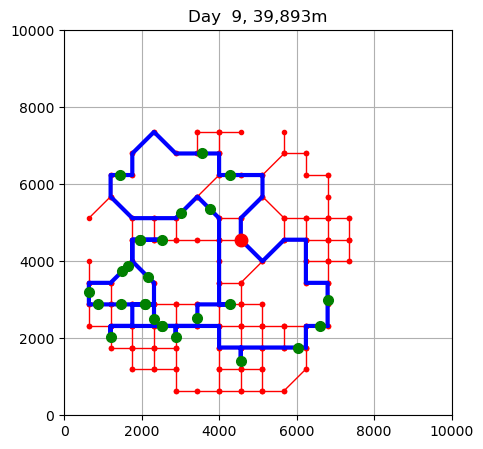

[ 9] 18:00:50.0 Parcel: 190 for customer 54 out for delivery
[ 9] 18:01:40.0 Parcel: 188 for customer 25 out for delivery
[ 9] 18:02:30.0 Parcel: 179 for customer 16 out for delivery
[ 9] 18:03:20.0 Parcel: 168 for customer 3 out for delivery
[ 9] 18:04:10.0 Parcel: 189 for customer 107 out for delivery
[ 9] 18:05:00.0 Parcel: 191 for customer 63 out for delivery
[ 9] 18:05:50.0 Parcel: 169 for customer 5 out for delivery
[ 9] 18:06:40.0 Parcel: 166 for customer 103 out for delivery
[ 9] 18:07:30.0 Parcel: 178 for customer 106 out for delivery
[ 9] 18:08:20.0 Parcel: 162 for customer 36 out for delivery
[ 9] 18:09:10.0 Parcel: 145 for customer 94 out for delivery
[ 9] 18:10:00.0 Parcel: 146 for customer 94 out for delivery
[ 9] 18:10:50.0 Parcel: 144 for customer 50 out for delivery
[ 9] 18:11:40.0 Parcel: 184 for customer 50 out for delivery
[ 9] 18:12:30.0 Parcel: 186 for customer 77 out for delivery
[ 9] 18:13:20.0 Parcel: 144 for customer 50 out for delivery
[ 9] 18:14:10.0 Parcel:

[ 9] 21:33:33.2 Parcel: 189 for customer 107 return from delivery
[ 9] 21:34:03.2 Parcel: 160 for customer 48 return from delivery
[ 9] 21:34:33.2 Parcel: 166 for customer 103 return from delivery
[ 9] 21:35:03.2 Parcel: 187 for customer 22 return from delivery
[ 9] 21:45:33.2 11 left over for next day
[ 9] 21:45:33.2 Driver goes home
Simulating the delivery of 198 parcels over 10 days to 150 customers

[ 0] 12:00:00.0 Parcel:  0 for customer 0 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  0 for customer 0 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  3 for customer 2 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  3 for customer 2 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  4 for customer 3 arr at delivery

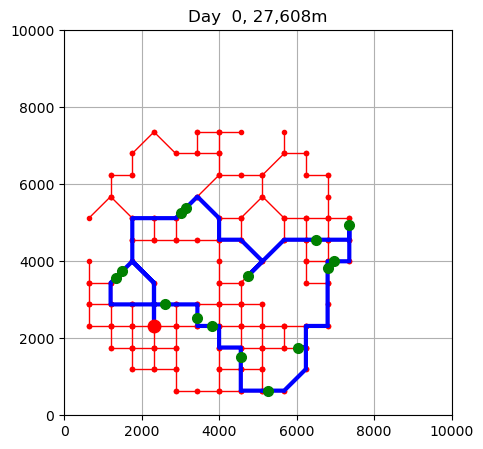

[ 0] 18:00:50.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:01:40.0 Parcel:  5 for customer 4 out for delivery
[ 0] 18:02:30.0 Parcel:  6 for customer 4 out for delivery
[ 0] 18:03:20.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:04:10.0 Parcel: 14 for customer 11 out for delivery
[ 0] 18:05:00.0 Parcel: 17 for customer 14 out for delivery
[ 0] 18:05:50.0 Parcel: 16 for customer 13 out for delivery
[ 0] 18:06:40.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:07:30.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:08:20.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:09:10.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:10:00.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:10:50.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:11:40.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:12:30.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:13:20.0 Parcel:  3 for customer 2 out for delivery
[ 0] 18:14:10.0 Parcel:  0 for customer 0 out for d

[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


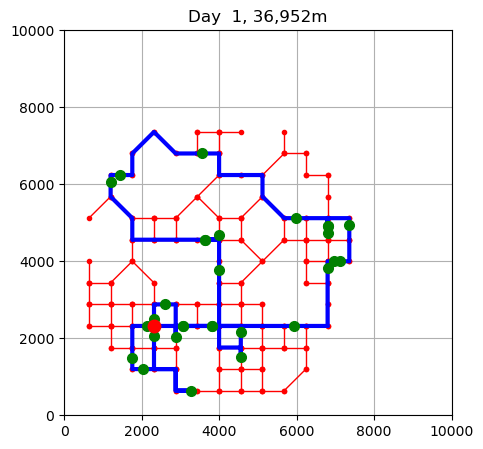

[ 1] 18:00:50.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:01:40.0 Parcel: 27 for customer 24 out for delivery
[ 1] 18:02:30.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:03:20.0 Parcel: 20 for customer 17 out for delivery
[ 1] 18:04:10.0 Parcel: 22 for customer 19 out for delivery
[ 1] 18:05:00.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:05:50.0 Parcel:  2 for customer 2 out for delivery
[ 1] 18:06:40.0 Parcel:  3 for customer 2 out for delivery
[ 1] 18:07:30.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:08:20.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:09:10.0 Parcel:  9 for customer 6 out for delivery
[ 1] 18:10:00.0 Parcel: 32 for customer 7 out for delivery
[ 1] 18:10:50.0 Parcel: 33 for customer 29 out for delivery
[ 1] 18:11:40.0 Parcel: 30 for customer 27 out for delivery
[ 1] 18:12:30.0 Parcel: 29 for customer 26 out for delivery
[ 1] 18:13:20.0 Parcel: 31 for customer 28 out for delivery
[ 1] 18:14:10.0 Parcel: 29 for customer 26 o

[ 1] 21:19:11.7 Parcel: 15 for customer 12 return from delivery
[ 1] 21:19:41.7 Parcel:  9 for customer 6 return from delivery
[ 1] 21:20:11.7 Parcel: 26 for customer 23 return from delivery
[ 1] 21:30:41.7 6 left over for next day
[ 1] 21:30:41.7 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 44 for customer 39 arr at deli

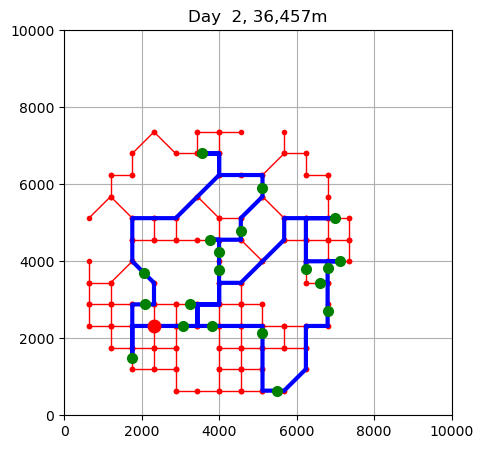

[ 2] 18:00:50.0 Parcel: 26 for customer 23 out for delivery
[ 2] 18:01:40.0 Parcel: 53 for customer 47 out for delivery
[ 2] 18:02:30.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:03:20.0 Parcel: 38 for customer 34 out for delivery
[ 2] 18:04:10.0 Parcel: 15 for customer 12 out for delivery
[ 2] 18:05:00.0 Parcel: 51 for customer 45 out for delivery
[ 2] 18:05:50.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:06:40.0 Parcel: 49 for customer 43 out for delivery
[ 2] 18:07:30.0 Parcel: 46 for customer 41 out for delivery
[ 2] 18:08:20.0 Parcel: 47 for customer 41 out for delivery
[ 2] 18:09:10.0 Parcel:  9 for customer 6 out for delivery
[ 2] 18:10:00.0 Parcel: 42 for customer 37 out for delivery
[ 2] 18:10:50.0 Parcel: 30 for customer 27 out for delivery
[ 2] 18:11:40.0 Parcel: 44 for customer 39 out for delivery
[ 2] 18:12:30.0 Parcel: 43 for customer 38 out for delivery
[ 2] 18:13:20.0 Parcel: 45 for customer 40 out for delivery
[ 2] 18:14:10.0 Parcel: 48 for customer 4

[ 3] 12:00:00.0 Parcel: 62 for customer 3 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 67 for customer 53 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 67 for customer 53 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 68 for customer 54 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 68 for customer 54 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 69 for customer 42 arr at deli

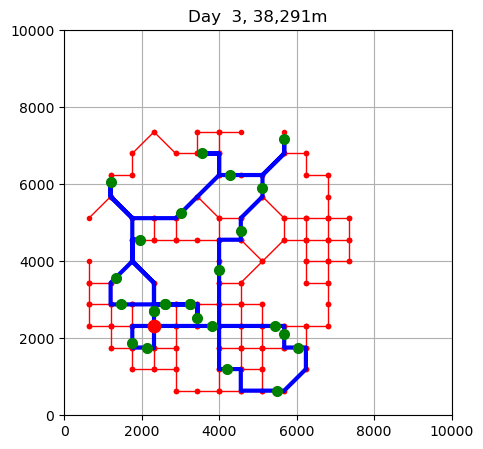

[ 3] 18:00:50.0 Parcel: 57 for customer 49 out for delivery
[ 3] 18:01:40.0 Parcel: 59 for customer 51 out for delivery
[ 3] 18:02:30.0 Parcel: 60 for customer 52 out for delivery
[ 3] 18:03:20.0 Parcel: 58 for customer 50 out for delivery
[ 3] 18:04:10.0 Parcel: 55 for customer 0 out for delivery
[ 3] 18:05:00.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:05:50.0 Parcel: 60 for customer 52 out for delivery
[ 3] 18:06:40.0 Parcel: 61 for customer 2 out for delivery
[ 3] 18:07:30.0 Parcel: 63 for customer 37 out for delivery
[ 3] 18:08:20.0 Parcel: 64 for customer 5 out for delivery
[ 3] 18:09:10.0 Parcel: 63 for customer 37 out for delivery
[ 3] 18:10:00.0 Parcel: 61 for customer 2 out for delivery
[ 3] 18:10:50.0 Parcel: 54 for customer 15 out for delivery
[ 3] 18:11:40.0 Parcel: 62 for customer 3 out for delivery
[ 3] 18:12:30.0 Parcel: 28 for customer 25 out for delivery
[ 3] 18:13:20.0 Parcel: 68 for customer 54 out for delivery
[ 3] 18:14:10.0 Parcel: 73 for customer 57 ou

[ 3] 21:18:53.4 Parcel: 61 for customer 2 return from delivery
[ 3] 21:19:23.4 Parcel: 63 for customer 37 return from delivery
[ 3] 21:19:53.4 Parcel: 63 for customer 37 return from delivery
[ 3] 21:20:23.4 Parcel: 62 for customer 3 return from delivery
[ 3] 21:20:53.4 Parcel: 28 for customer 25 return from delivery
[ 3] 21:21:23.4 Parcel: 69 for customer 42 return from delivery
[ 3] 21:21:53.4 Parcel: 70 for customer 42 return from delivery
[ 3] 21:22:23.4 Parcel: 67 for customer 53 return from delivery
[ 3] 21:32:53.4 13 left over for next day
[ 3] 21:32:53.4 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arrived in delivery centre
[ 4] 1

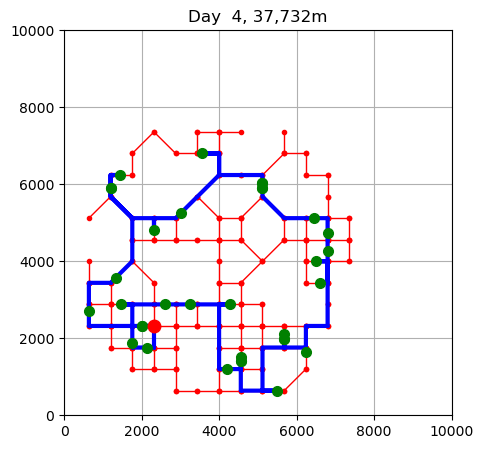

[ 4] 18:00:50.0 Parcel: 82 for customer 61 out for delivery
[ 4] 18:01:40.0 Parcel: 59 for customer 51 out for delivery
[ 4] 18:02:30.0 Parcel: 81 for customer 49 out for delivery
[ 4] 18:03:20.0 Parcel: 56 for customer 48 out for delivery
[ 4] 18:04:10.0 Parcel: 61 for customer 2 out for delivery
[ 4] 18:05:00.0 Parcel: 63 for customer 37 out for delivery
[ 4] 18:05:50.0 Parcel: 63 for customer 37 out for delivery
[ 4] 18:06:40.0 Parcel: 84 for customer 37 out for delivery
[ 4] 18:07:30.0 Parcel: 86 for customer 63 out for delivery
[ 4] 18:08:20.0 Parcel: 67 for customer 53 out for delivery
[ 4] 18:09:10.0 Parcel: 87 for customer 64 out for delivery
[ 4] 18:10:00.0 Parcel: 88 for customer 7 out for delivery
[ 4] 18:10:50.0 Parcel: 87 for customer 64 out for delivery
[ 4] 18:11:40.0 Parcel: 90 for customer 43 out for delivery
[ 4] 18:12:30.0 Parcel: 91 for customer 66 out for delivery
[ 4] 18:13:20.0 Parcel: 92 for customer 56 out for delivery
[ 4] 18:14:10.0 Parcel: 91 for customer 66

[ 4] 21:30:39.7 Parcel: 67 for customer 53 return from delivery
[ 4] 21:31:09.7 Parcel: 88 for customer 7 return from delivery
[ 4] 21:31:39.7 Parcel: 98 for customer 72 return from delivery
[ 4] 21:32:09.7 Parcel: 55 for customer 0 return from delivery
[ 4] 21:42:39.7 10 left over for next day
[ 4] 21:42:39.7 Driver goes home

[ 5] 12:00:00.0 Parcel: 101 for customer 74 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 101 for customer 74 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 103 for customer 76 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 103 for customer 76 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 104 for customer 15 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 104 for customer 15 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 105 for customer 48 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 105 for customer 48 arrived

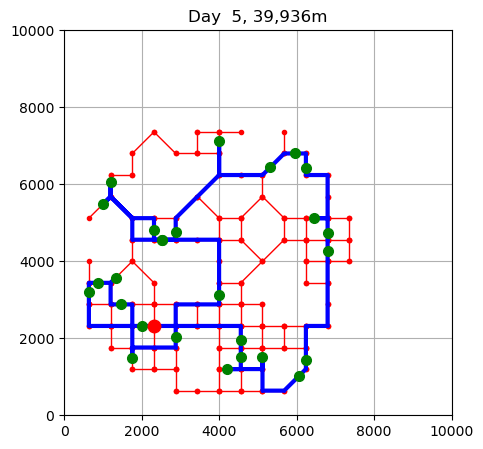

[ 5] 18:00:50.0 Parcel: 82 for customer 61 out for delivery
[ 5] 18:01:40.0 Parcel: 101 for customer 74 out for delivery
[ 5] 18:02:30.0 Parcel: 102 for customer 75 out for delivery
[ 5] 18:03:20.0 Parcel: 55 for customer 0 out for delivery
[ 5] 18:04:10.0 Parcel: 56 for customer 48 out for delivery
[ 5] 18:05:00.0 Parcel: 105 for customer 48 out for delivery
[ 5] 18:05:50.0 Parcel: 106 for customer 17 out for delivery
[ 5] 18:06:40.0 Parcel: 109 for customer 22 out for delivery
[ 5] 18:07:30.0 Parcel: 111 for customer 79 out for delivery
[ 5] 18:08:20.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:09:10.0 Parcel: 104 for customer 15 out for delivery
[ 5] 18:10:00.0 Parcel: 103 for customer 76 out for delivery
[ 5] 18:10:50.0 Parcel: 107 for customer 62 out for delivery
[ 5] 18:11:40.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:12:30.0 Parcel: 110 for customer 78 out for delivery
[ 5] 18:13:20.0 Parcel: 112 for customer 80 out for delivery
[ 5] 18:14:10.0 Parcel: 116 

[ 5] 21:24:17.4 Parcel: 93 for customer 67 return from delivery
[ 5] 21:24:47.4 Parcel: 98 for customer 72 return from delivery
[ 5] 21:25:17.4 Parcel: 118 for customer 73 return from delivery
[ 5] 21:25:47.4 Parcel: 67 for customer 53 return from delivery
[ 5] 21:36:17.4 8 left over for next day
[ 5] 21:36:17.4 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 126 for customer 87 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 126 for customer 87 arriv

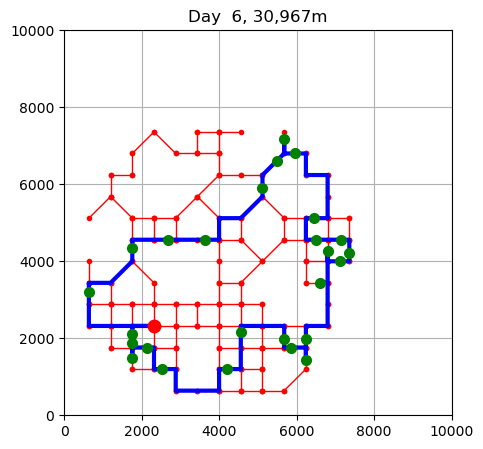

[ 6] 18:00:50.0 Parcel: 123 for customer 85 out for delivery
[ 6] 18:01:40.0 Parcel: 122 for customer 49 out for delivery
[ 6] 18:02:30.0 Parcel: 106 for customer 17 out for delivery
[ 6] 18:03:20.0 Parcel: 125 for customer 51 out for delivery
[ 6] 18:04:10.0 Parcel: 126 for customer 87 out for delivery
[ 6] 18:05:00.0 Parcel: 67 for customer 53 out for delivery
[ 6] 18:05:50.0 Parcel: 129 for customer 29 out for delivery
[ 6] 18:06:40.0 Parcel: 133 for customer 66 out for delivery
[ 6] 18:07:30.0 Parcel: 135 for customer 90 out for delivery
[ 6] 18:08:20.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:09:10.0 Parcel: 137 for customer 69 out for delivery
[ 6] 18:10:00.0 Parcel: 138 for customer 69 out for delivery
[ 6] 18:10:50.0 Parcel: 139 for customer 91 out for delivery
[ 6] 18:11:40.0 Parcel: 141 for customer 45 out for delivery
[ 6] 18:12:30.0 Parcel: 118 for customer 73 out for delivery
[ 6] 18:13:20.0 Parcel: 120 for customer 34 out for delivery
[ 6] 18:14:10.0 Parcel: 1

[ 6] 20:51:51.0 Parcel: 120 for customer 34 return from delivery
[ 6] 20:52:21.0 Parcel: 142 for customer 92 return from delivery
[ 6] 20:52:51.0 Parcel: 98 for customer 72 return from delivery
[ 6] 20:53:21.0 Parcel: 93 for customer 67 return from delivery
[ 6] 20:53:51.0 Parcel: 130 for customer 42 return from delivery
[ 6] 20:54:21.0 Parcel: 131 for customer 42 return from delivery
[ 6] 20:54:51.0 Parcel: 128 for customer 26 return from delivery
[ 6] 20:55:21.0 Parcel: 127 for customer 88 return from delivery
[ 6] 21:05:51.0 11 left over for next day
[ 6] 21:05:51.0 Driver goes home

[ 7] 12:00:00.0 Parcel: 143 for customer 93 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 143 for customer 93 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 145 for customer 94 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 145 for customer 94 arrived in delivery

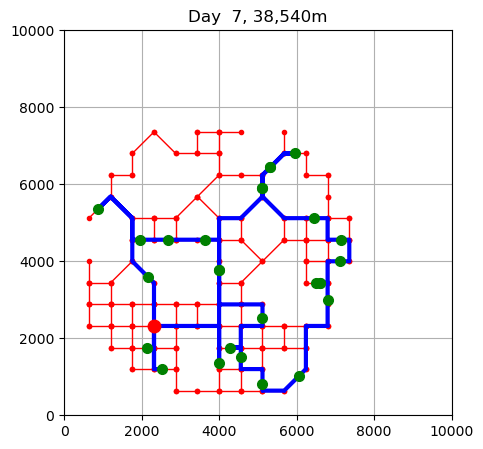

[ 7] 18:00:50.0 Parcel: 147 for customer 95 out for delivery
[ 7] 18:01:40.0 Parcel: 148 for customer 27 out for delivery
[ 7] 18:02:30.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:03:20.0 Parcel: 131 for customer 42 out for delivery
[ 7] 18:04:10.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:05:00.0 Parcel: 93 for customer 67 out for delivery
[ 7] 18:05:50.0 Parcel: 154 for customer 67 out for delivery
[ 7] 18:06:40.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:07:30.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:08:20.0 Parcel: 131 for customer 42 out for delivery
[ 7] 18:09:10.0 Parcel: 98 for customer 72 out for delivery
[ 7] 18:10:00.0 Parcel: 142 for customer 92 out for delivery
[ 7] 18:10:50.0 Parcel: 120 for customer 34 out for delivery
[ 7] 18:11:40.0 Parcel: 141 for customer 45 out for delivery
[ 7] 18:12:30.0 Parcel: 156 for customer 99 out for delivery
[ 7] 18:13:20.0 Parcel: 141 for customer 45 out for delivery
[ 7] 18:14:10.0 Parcel: 15

[ 7] 21:24:24.9 Parcel: 131 for customer 42 return from delivery
[ 7] 21:24:54.9 Parcel: 93 for customer 67 return from delivery
[ 7] 21:25:24.9 Parcel: 154 for customer 67 return from delivery
[ 7] 21:25:54.9 Parcel: 98 for customer 72 return from delivery
[ 7] 21:26:24.9 Parcel: 141 for customer 45 return from delivery
[ 7] 21:26:54.9 Parcel: 156 for customer 99 return from delivery
[ 7] 21:27:24.9 Parcel: 157 for customer 100 return from delivery
[ 7] 21:27:54.9 Parcel: 155 for customer 68 return from delivery
[ 7] 21:28:24.9 Parcel: 152 for customer 98 return from delivery
[ 7] 21:28:54.9 Parcel: 127 for customer 88 return from delivery
[ 7] 21:29:24.9 Parcel: 143 for customer 93 return from delivery
[ 7] 21:29:54.9 Parcel: 126 for customer 87 return from delivery
[ 7] 21:40:24.9 13 left over for next day
[ 7] 21:40:24.9 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12

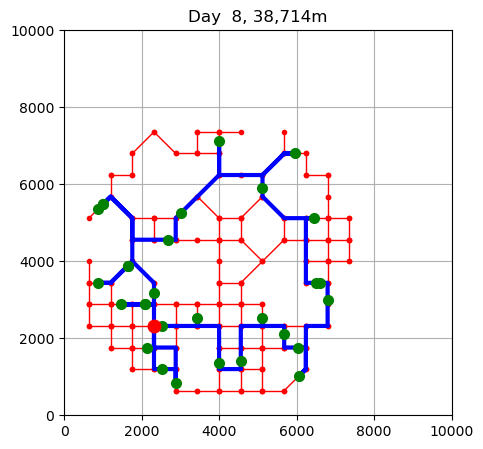

[ 8] 18:00:50.0 Parcel: 167 for customer 104 out for delivery
[ 8] 18:01:40.0 Parcel: 126 for customer 87 out for delivery
[ 8] 18:02:30.0 Parcel: 163 for customer 51 out for delivery
[ 8] 18:03:20.0 Parcel: 166 for customer 103 out for delivery
[ 8] 18:04:10.0 Parcel: 169 for customer 5 out for delivery
[ 8] 18:05:00.0 Parcel: 170 for customer 95 out for delivery
[ 8] 18:05:50.0 Parcel: 172 for customer 64 out for delivery
[ 8] 18:06:40.0 Parcel: 152 for customer 98 out for delivery
[ 8] 18:07:30.0 Parcel: 174 for customer 56 out for delivery
[ 8] 18:08:20.0 Parcel: 175 for customer 10 out for delivery
[ 8] 18:09:10.0 Parcel: 155 for customer 68 out for delivery
[ 8] 18:10:00.0 Parcel: 157 for customer 100 out for delivery
[ 8] 18:10:50.0 Parcel: 141 for customer 45 out for delivery
[ 8] 18:11:40.0 Parcel: 156 for customer 99 out for delivery
[ 8] 18:12:30.0 Parcel: 98 for customer 72 out for delivery
[ 8] 18:13:20.0 Parcel: 130 for customer 42 out for delivery
[ 8] 18:14:10.0 Parcel:

[ 8] 21:27:14.1 Parcel: 141 for customer 45 return from delivery
[ 8] 21:27:44.1 Parcel: 168 for customer 3 return from delivery
[ 8] 21:28:14.1 Parcel: 127 for customer 88 return from delivery
[ 8] 21:28:44.1 Parcel: 161 for customer 101 return from delivery
[ 8] 21:29:14.1 Parcel: 164 for customer 102 return from delivery
[ 8] 21:29:44.1 Parcel: 165 for customer 102 return from delivery
[ 8] 21:30:14.1 Parcel: 160 for customer 48 return from delivery
[ 8] 21:40:44.1 11 left over for next day
[ 8] 21:40:44.1 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arr a

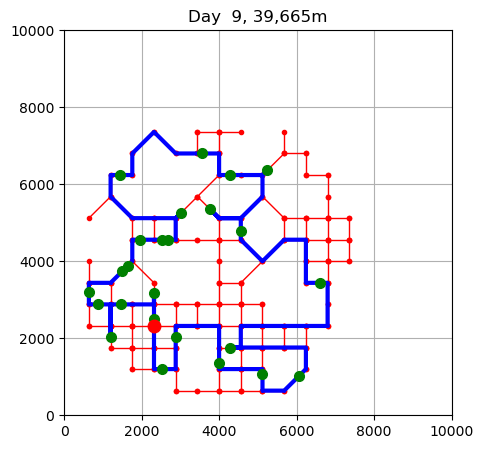

[ 9] 18:00:50.0 Parcel: 185 for customer 21 out for delivery
[ 9] 18:01:40.0 Parcel: 164 for customer 102 out for delivery
[ 9] 18:02:30.0 Parcel: 165 for customer 102 out for delivery
[ 9] 18:03:20.0 Parcel: 160 for customer 48 out for delivery
[ 9] 18:04:10.0 Parcel: 178 for customer 106 out for delivery
[ 9] 18:05:00.0 Parcel: 177 for customer 105 out for delivery
[ 9] 18:05:50.0 Parcel: 176 for customer 74 out for delivery
[ 9] 18:06:40.0 Parcel: 180 for customer 1 out for delivery
[ 9] 18:07:30.0 Parcel: 161 for customer 101 out for delivery
[ 9] 18:08:20.0 Parcel: 181 for customer 101 out for delivery
[ 9] 18:09:10.0 Parcel: 182 for customer 101 out for delivery
[ 9] 18:10:00.0 Parcel: 183 for customer 101 out for delivery
[ 9] 18:10:50.0 Parcel: 184 for customer 50 out for delivery
[ 9] 18:11:40.0 Parcel: 186 for customer 77 out for delivery
[ 9] 18:12:30.0 Parcel: 127 for customer 88 out for delivery
[ 9] 18:13:20.0 Parcel: 168 for customer 3 out for delivery
[ 9] 18:14:10.0 Pa

[ 9] 21:31:30.9 Parcel: 190 for customer 54 return from delivery
[ 9] 21:32:00.9 Parcel: 194 for customer 109 return from delivery
[ 9] 21:32:30.9 Parcel: 195 for customer 109 return from delivery
[ 9] 21:33:00.9 Parcel: 189 for customer 107 return from delivery
[ 9] 21:33:30.9 Parcel: 173 for customer 40 return from delivery
[ 9] 21:34:00.9 Parcel: 141 for customer 45 return from delivery
[ 9] 21:34:30.9 Parcel: 193 for customer 108 return from delivery
[ 9] 21:35:00.9 Parcel: 170 for customer 95 return from delivery
[ 9] 21:35:30.9 Parcel: 187 for customer 22 return from delivery
[ 9] 21:46:00.9 20 left over for next day
[ 9] 21:46:00.9 Driver goes home
Simulating the delivery of 198 parcels over 10 days to 150 customers

[ 0] 12:00:00.0 Parcel:  0 for customer 0 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  0 for customer 0 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arrived in delivery centr

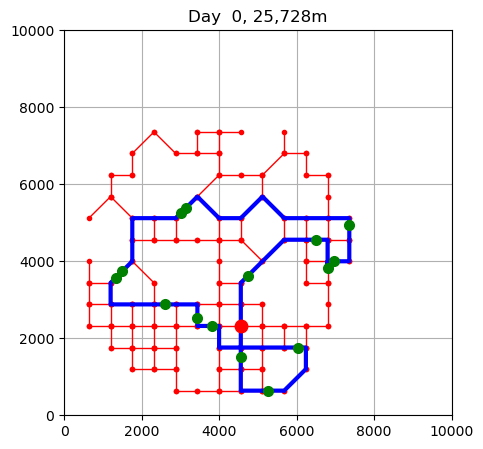

[ 0] 18:00:50.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:01:40.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:02:30.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:03:20.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:04:10.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:05:00.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:05:50.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:06:40.0 Parcel:  3 for customer 2 out for delivery
[ 0] 18:07:30.0 Parcel:  0 for customer 0 out for delivery
[ 0] 18:08:20.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:09:10.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:10:00.0 Parcel:  5 for customer 4 out for delivery
[ 0] 18:10:50.0 Parcel:  6 for customer 4 out for delivery
[ 0] 18:11:40.0 Parcel: 17 for customer 14 out for delivery
[ 0] 18:12:30.0 Parcel: 16 for customer 13 out for delivery
[ 0] 18:13:20.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:14:10.0 Parcel: 14 for customer 11 out for d

[ 1] 12:00:00.0 Parcel: 37 for customer 33 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


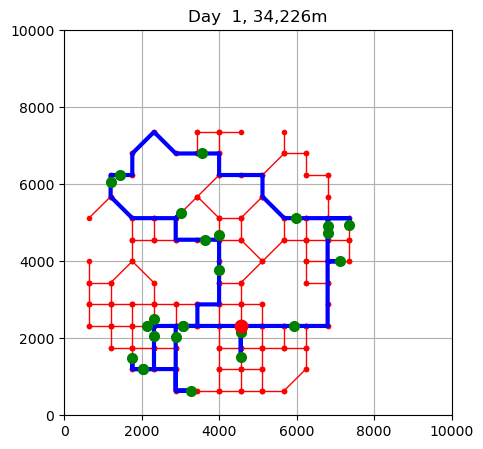

[ 1] 18:00:50.0 Parcel: 33 for customer 29 out for delivery
[ 1] 18:01:40.0 Parcel: 32 for customer 7 out for delivery
[ 1] 18:02:30.0 Parcel: 33 for customer 29 out for delivery
[ 1] 18:03:20.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:04:10.0 Parcel: 22 for customer 19 out for delivery
[ 1] 18:05:00.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:05:50.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:06:40.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:07:30.0 Parcel: 20 for customer 17 out for delivery
[ 1] 18:08:20.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:09:10.0 Parcel: 27 for customer 24 out for delivery
[ 1] 18:10:00.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:10:50.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:11:40.0 Parcel: 30 for customer 27 out for delivery
[ 1] 18:12:30.0 Parcel: 31 for customer 28 out for delivery
[ 1] 18:13:20.0 Parcel: 29 for customer 26 out for delivery
[ 1] 18:14:10.0 Parcel:  4 for customer 3

[ 1] 21:01:15.10 Parcel: 26 for customer 23 return from delivery
[ 1] 21:01:45.10 Parcel: 19 for customer 16 return from delivery
[ 1] 21:02:15.10 Parcel: 38 for customer 34 return from delivery
[ 1] 21:12:45.10 6 left over for next day
[ 1] 21:12:45.10 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 44 for customer 39 arr a

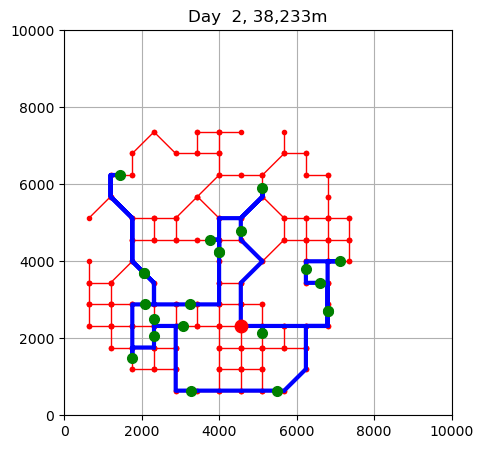

[ 2] 18:00:50.0 Parcel: 46 for customer 41 out for delivery
[ 2] 18:01:40.0 Parcel: 47 for customer 41 out for delivery
[ 2] 18:02:30.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:03:20.0 Parcel: 38 for customer 34 out for delivery
[ 2] 18:04:10.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:05:00.0 Parcel: 51 for customer 45 out for delivery
[ 2] 18:05:50.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:06:40.0 Parcel: 49 for customer 43 out for delivery
[ 2] 18:07:30.0 Parcel: 27 for customer 24 out for delivery
[ 2] 18:08:20.0 Parcel: 26 for customer 23 out for delivery
[ 2] 18:09:10.0 Parcel: 24 for customer 21 out for delivery
[ 2] 18:10:00.0 Parcel: 23 for customer 20 out for delivery
[ 2] 18:10:50.0 Parcel: 39 for customer 17 out for delivery
[ 2] 18:11:40.0 Parcel: 41 for customer 36 out for delivery
[ 2] 18:12:30.0 Parcel: 40 for customer 35 out for delivery
[ 2] 18:13:20.0 Parcel: 19 for customer 16 out for delivery
[ 2] 18:14:10.0 Parcel: 40 for customer 

[ 3] 12:00:00.0 Parcel: 58 for customer 50 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 58 for customer 50 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 59 for customer 51 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 59 for customer 51 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arr at deliv

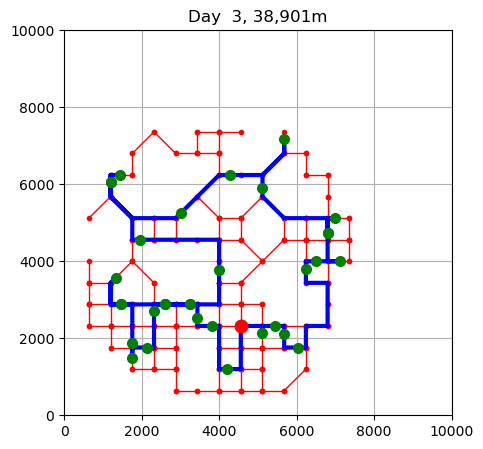

[ 3] 18:00:50.0 Parcel: 67 for customer 53 out for delivery
[ 3] 18:01:40.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:02:30.0 Parcel: 64 for customer 5 out for delivery
[ 3] 18:03:20.0 Parcel: 63 for customer 37 out for delivery
[ 3] 18:04:10.0 Parcel: 61 for customer 2 out for delivery
[ 3] 18:05:00.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:05:50.0 Parcel: 55 for customer 0 out for delivery
[ 3] 18:06:40.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:07:30.0 Parcel: 57 for customer 49 out for delivery
[ 3] 18:08:20.0 Parcel: 39 for customer 17 out for delivery
[ 3] 18:09:10.0 Parcel: 59 for customer 51 out for delivery
[ 3] 18:10:00.0 Parcel: 60 for customer 52 out for delivery
[ 3] 18:10:50.0 Parcel: 61 for customer 2 out for delivery
[ 3] 18:11:40.0 Parcel: 63 for customer 37 out for delivery
[ 3] 18:12:30.0 Parcel: 66 for customer 27 out for delivery
[ 3] 18:13:20.0 Parcel: 58 for customer 50 out for delivery
[ 3] 18:14:10.0 Parcel: 54 for customer 15 ou

[ 3] 21:31:59.3 Parcel: 57 for customer 49 return from delivery
[ 3] 21:32:29.3 Parcel: 39 for customer 17 return from delivery
[ 3] 21:32:59.3 Parcel: 60 for customer 52 return from delivery
[ 3] 21:33:29.3 Parcel: 66 for customer 27 return from delivery
[ 3] 21:33:59.3 Parcel: 58 for customer 50 return from delivery
[ 3] 21:34:29.3 Parcel: 54 for customer 15 return from delivery
[ 3] 21:34:59.3 Parcel: 73 for customer 57 return from delivery
[ 3] 21:35:29.3 Parcel: 76 for customer 32 return from delivery
[ 3] 21:35:59.3 Parcel: 72 for customer 56 return from delivery
[ 3] 21:46:29.3 12 left over for next day
[ 3] 21:46:29.3 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arr at delivery centre
[ 4] 12:00

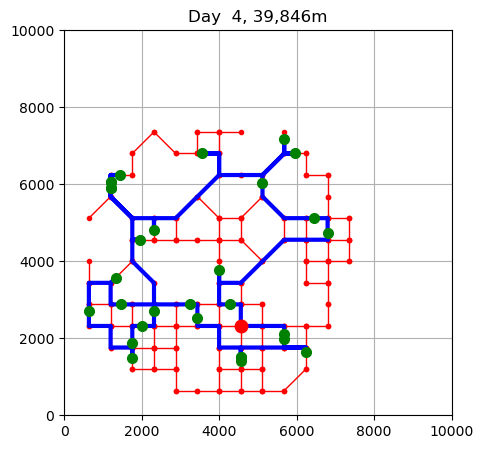

[ 4] 18:00:50.0 Parcel: 72 for customer 56 out for delivery
[ 4] 18:01:40.0 Parcel: 92 for customer 56 out for delivery
[ 4] 18:02:30.0 Parcel: 91 for customer 66 out for delivery
[ 4] 18:03:20.0 Parcel: 96 for customer 70 out for delivery
[ 4] 18:04:10.0 Parcel: 88 for customer 7 out for delivery
[ 4] 18:05:00.0 Parcel: 87 for customer 64 out for delivery
[ 4] 18:05:50.0 Parcel: 88 for customer 7 out for delivery
[ 4] 18:06:40.0 Parcel: 64 for customer 5 out for delivery
[ 4] 18:07:30.0 Parcel: 84 for customer 37 out for delivery
[ 4] 18:08:20.0 Parcel: 56 for customer 48 out for delivery
[ 4] 18:09:10.0 Parcel: 55 for customer 0 out for delivery
[ 4] 18:10:00.0 Parcel: 77 for customer 59 out for delivery
[ 4] 18:10:50.0 Parcel: 39 for customer 17 out for delivery
[ 4] 18:11:40.0 Parcel: 57 for customer 49 out for delivery
[ 4] 18:12:30.0 Parcel: 81 for customer 49 out for delivery
[ 4] 18:13:20.0 Parcel: 82 for customer 61 out for delivery
[ 4] 18:14:10.0 Parcel: 60 for customer 52 o

[ 4] 21:32:04.1 Parcel: 82 for customer 61 return from delivery
[ 4] 21:32:34.1 Parcel: 60 for customer 52 return from delivery
[ 4] 21:33:04.1 Parcel: 58 for customer 50 return from delivery
[ 4] 21:33:34.1 Parcel: 78 for customer 60 return from delivery
[ 4] 21:34:04.1 Parcel: 79 for customer 60 return from delivery
[ 4] 21:34:34.1 Parcel: 83 for customer 62 return from delivery
[ 4] 21:35:04.1 Parcel: 85 for customer 25 return from delivery
[ 4] 21:35:34.1 Parcel: 73 for customer 57 return from delivery
[ 4] 21:36:04.1 Parcel: 93 for customer 67 return from delivery
[ 4] 21:36:34.1 Parcel: 86 for customer 63 return from delivery
[ 4] 21:47:04.1 18 left over for next day
[ 4] 21:47:04.1 Driver goes home

[ 5] 12:00:00.0 Parcel: 101 for customer 74 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 101 for customer 74 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arrived in delivery centre
[ 5] 12:

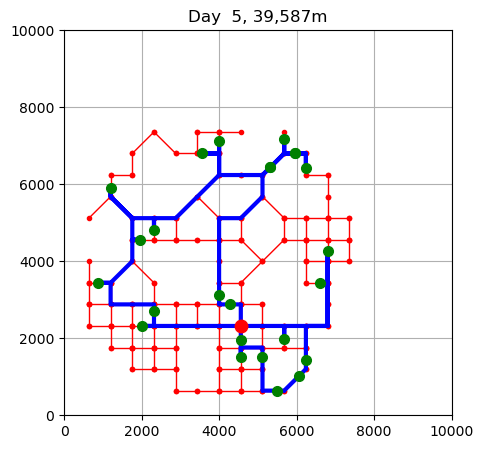

[ 5] 18:00:50.0 Parcel: 82 for customer 61 out for delivery
[ 5] 18:01:40.0 Parcel: 60 for customer 52 out for delivery
[ 5] 18:02:30.0 Parcel: 102 for customer 75 out for delivery
[ 5] 18:03:20.0 Parcel: 58 for customer 50 out for delivery
[ 5] 18:04:10.0 Parcel: 78 for customer 60 out for delivery
[ 5] 18:05:00.0 Parcel: 79 for customer 60 out for delivery
[ 5] 18:05:50.0 Parcel: 83 for customer 62 out for delivery
[ 5] 18:06:40.0 Parcel: 107 for customer 62 out for delivery
[ 5] 18:07:30.0 Parcel: 85 for customer 25 out for delivery
[ 5] 18:08:20.0 Parcel: 112 for customer 80 out for delivery
[ 5] 18:09:10.0 Parcel: 116 for customer 83 out for delivery
[ 5] 18:10:00.0 Parcel: 73 for customer 57 out for delivery
[ 5] 18:10:50.0 Parcel: 93 for customer 67 out for delivery
[ 5] 18:11:40.0 Parcel: 97 for customer 71 out for delivery
[ 5] 18:12:30.0 Parcel: 93 for customer 67 out for delivery
[ 5] 18:13:20.0 Parcel: 116 for customer 83 out for delivery
[ 5] 18:14:10.0 Parcel: 111 for cus

[ 5] 21:19:02.5 Parcel: 90 for customer 43 return from delivery
[ 5] 21:19:32.5 Parcel: 95 for customer 69 return from delivery
[ 5] 21:30:02.5 16 left over for next day
[ 5] 21:30:02.5 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 126 for customer 87 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 126 for customer 87 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 127 for customer 88 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 127 for custome

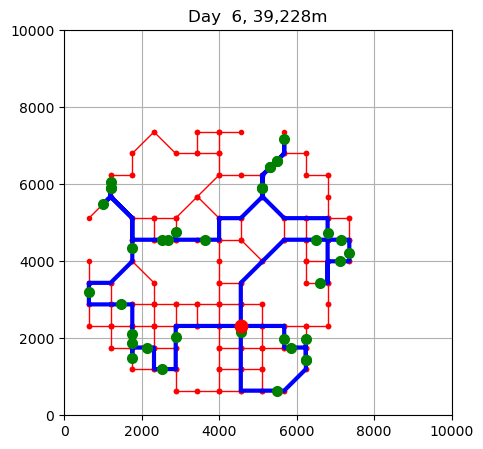

[ 6] 18:00:50.0 Parcel: 133 for customer 66 out for delivery
[ 6] 18:01:40.0 Parcel: 135 for customer 90 out for delivery
[ 6] 18:02:30.0 Parcel: 95 for customer 69 out for delivery
[ 6] 18:03:20.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:04:10.0 Parcel: 137 for customer 69 out for delivery
[ 6] 18:05:00.0 Parcel: 138 for customer 69 out for delivery
[ 6] 18:05:50.0 Parcel: 139 for customer 91 out for delivery
[ 6] 18:06:40.0 Parcel: 95 for customer 69 out for delivery
[ 6] 18:07:30.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:08:20.0 Parcel: 137 for customer 69 out for delivery
[ 6] 18:09:10.0 Parcel: 138 for customer 69 out for delivery
[ 6] 18:10:00.0 Parcel: 90 for customer 43 out for delivery
[ 6] 18:10:50.0 Parcel: 129 for customer 29 out for delivery
[ 6] 18:11:40.0 Parcel: 109 for customer 22 out for delivery
[ 6] 18:12:30.0 Parcel: 126 for customer 87 out for delivery
[ 6] 18:13:20.0 Parcel: 125 for customer 51 out for delivery
[ 6] 18:14:10.0 Parcel: 106

[ 6] 21:51:15.6 Parcel: 95 for customer 69 return from delivery
[ 6] 21:51:45.6 Parcel: 136 for customer 69 return from delivery
[ 6] 21:52:15.6 Parcel: 137 for customer 69 return from delivery
[ 6] 21:52:45.6 Parcel: 138 for customer 69 return from delivery
[ 6] 21:53:15.6 Parcel: 126 for customer 87 return from delivery
[ 6] 21:53:45.6 Parcel: 125 for customer 51 return from delivery
[ 6] 21:54:15.6 Parcel: 108 for customer 77 return from delivery
[ 6] 21:54:45.6 Parcel: 127 for customer 88 return from delivery
[ 6] 21:55:15.6 Parcel: 130 for customer 42 return from delivery
[ 6] 21:55:45.6 Parcel: 131 for customer 42 return from delivery
[ 6] 21:56:15.6 Parcel: 116 for customer 83 return from delivery
[ 6] 21:56:45.6 Parcel: 132 for customer 89 return from delivery
[ 6] 21:57:15.6 Parcel: 141 for customer 45 return from delivery
[ 6] 22:07:45.6 19 left over for next day
[ 6] 22:07:45.6 Driver goes home

[ 7] 12:00:00.0 Parcel: 143 for customer 93 arr at delivery centre
[ 7] 12:00:00

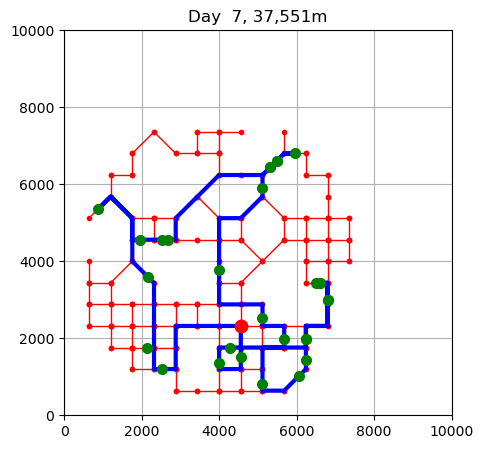

[ 7] 18:00:50.0 Parcel: 126 for customer 87 out for delivery
[ 7] 18:01:40.0 Parcel: 125 for customer 51 out for delivery
[ 7] 18:02:30.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:03:20.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:04:10.0 Parcel: 143 for customer 93 out for delivery
[ 7] 18:05:00.0 Parcel: 144 for customer 50 out for delivery
[ 7] 18:05:50.0 Parcel: 108 for customer 77 out for delivery
[ 7] 18:06:40.0 Parcel: 127 for customer 88 out for delivery
[ 7] 18:07:30.0 Parcel: 116 for customer 83 out for delivery
[ 7] 18:08:20.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:09:10.0 Parcel: 132 for customer 89 out for delivery
[ 7] 18:10:00.0 Parcel: 154 for customer 67 out for delivery
[ 7] 18:10:50.0 Parcel: 132 for customer 89 out for delivery
[ 7] 18:11:40.0 Parcel: 116 for customer 83 out for delivery
[ 7] 18:12:30.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:13:20.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:14:10.0 Parcel: 

[ 7] 21:29:06.7 Parcel: 116 for customer 83 return from delivery
[ 7] 21:29:36.7 Parcel: 153 for customer 83 return from delivery
[ 7] 21:30:06.7 Parcel: 132 for customer 89 return from delivery
[ 7] 21:30:36.7 Parcel: 130 for customer 42 return from delivery
[ 7] 21:31:06.7 Parcel: 131 for customer 42 return from delivery
[ 7] 21:31:36.7 Parcel: 133 for customer 66 return from delivery
[ 7] 21:32:06.7 Parcel: 155 for customer 68 return from delivery
[ 7] 21:32:36.7 Parcel: 157 for customer 100 return from delivery
[ 7] 21:33:06.7 Parcel: 141 for customer 45 return from delivery
[ 7] 21:33:36.7 Parcel: 156 for customer 99 return from delivery
[ 7] 21:44:06.7 12 left over for next day
[ 7] 21:44:06.7 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arrived in delivery cent

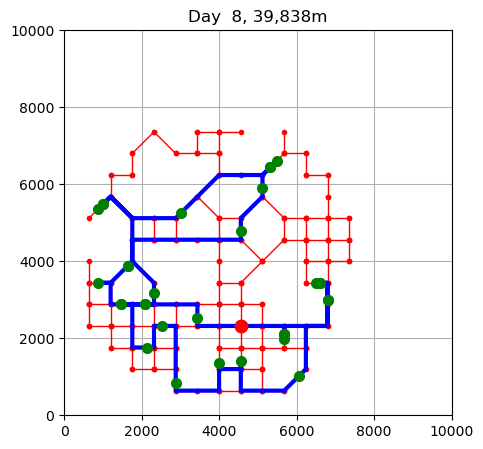

[ 8] 18:00:50.0 Parcel: 174 for customer 56 out for delivery
[ 8] 18:01:40.0 Parcel: 133 for customer 66 out for delivery
[ 8] 18:02:30.0 Parcel: 174 for customer 56 out for delivery
[ 8] 18:03:20.0 Parcel: 157 for customer 100 out for delivery
[ 8] 18:04:10.0 Parcel: 141 for customer 45 out for delivery
[ 8] 18:05:00.0 Parcel: 156 for customer 99 out for delivery
[ 8] 18:05:50.0 Parcel: 141 for customer 45 out for delivery
[ 8] 18:06:40.0 Parcel: 157 for customer 100 out for delivery
[ 8] 18:07:30.0 Parcel: 155 for customer 68 out for delivery
[ 8] 18:08:20.0 Parcel: 172 for customer 64 out for delivery
[ 8] 18:09:10.0 Parcel: 170 for customer 95 out for delivery
[ 8] 18:10:00.0 Parcel: 167 for customer 104 out for delivery
[ 8] 18:10:50.0 Parcel: 166 for customer 103 out for delivery
[ 8] 18:11:40.0 Parcel: 125 for customer 51 out for delivery
[ 8] 18:12:30.0 Parcel: 163 for customer 51 out for delivery
[ 8] 18:13:20.0 Parcel: 160 for customer 48 out for delivery
[ 8] 18:14:10.0 Parc

[ 8] 21:39:20.0 Parcel: 125 for customer 51 return from delivery
[ 8] 21:39:50.0 Parcel: 163 for customer 51 return from delivery
[ 8] 21:40:20.0 Parcel: 130 for customer 42 return from delivery
[ 8] 21:40:50.0 Parcel: 131 for customer 42 return from delivery
[ 8] 21:41:20.0 Parcel: 116 for customer 83 return from delivery
[ 8] 21:41:50.0 Parcel: 153 for customer 83 return from delivery
[ 8] 21:42:20.0 Parcel: 143 for customer 93 return from delivery
[ 8] 21:42:50.0 Parcel: 159 for customer 76 return from delivery
[ 8] 21:43:20.0 Parcel: 160 for customer 48 return from delivery
[ 8] 21:43:50.0 Parcel: 162 for customer 36 return from delivery
[ 8] 21:44:20.0 Parcel: 169 for customer 5 return from delivery
[ 8] 21:54:50.0 16 left over for next day
[ 8] 21:54:50.0 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9]

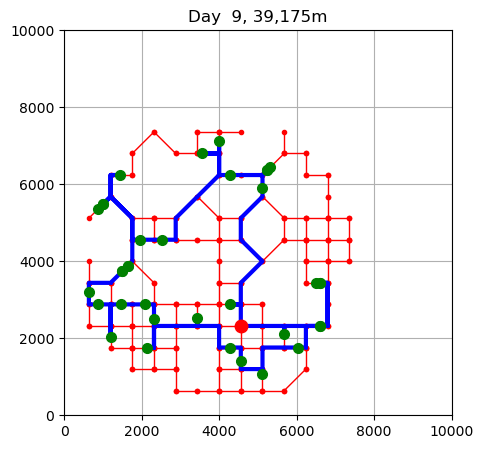

[ 9] 18:00:50.0 Parcel: 191 for customer 63 out for delivery
[ 9] 18:01:40.0 Parcel: 130 for customer 42 out for delivery
[ 9] 18:02:30.0 Parcel: 131 for customer 42 out for delivery
[ 9] 18:03:20.0 Parcel: 194 for customer 109 out for delivery
[ 9] 18:04:10.0 Parcel: 195 for customer 109 out for delivery
[ 9] 18:05:00.0 Parcel: 116 for customer 83 out for delivery
[ 9] 18:05:50.0 Parcel: 153 for customer 83 out for delivery
[ 9] 18:06:40.0 Parcel: 194 for customer 109 out for delivery
[ 9] 18:07:30.0 Parcel: 195 for customer 109 out for delivery
[ 9] 18:08:20.0 Parcel: 190 for customer 54 out for delivery
[ 9] 18:09:10.0 Parcel: 188 for customer 25 out for delivery
[ 9] 18:10:00.0 Parcel: 171 for customer 80 out for delivery
[ 9] 18:10:50.0 Parcel: 186 for customer 77 out for delivery
[ 9] 18:11:40.0 Parcel: 184 for customer 50 out for delivery
[ 9] 18:12:30.0 Parcel: 179 for customer 16 out for delivery
[ 9] 18:13:20.0 Parcel: 159 for customer 76 out for delivery
[ 9] 18:14:10.0 Parc

[ 9] 21:46:06.6 Parcel: 131 for customer 42 return from delivery
[ 9] 21:46:36.6 Parcel: 116 for customer 83 return from delivery
[ 9] 21:47:06.6 Parcel: 153 for customer 83 return from delivery
[ 9] 21:47:36.6 Parcel: 159 for customer 76 return from delivery
[ 9] 21:48:06.6 Parcel: 159 for customer 76 return from delivery
[ 9] 21:48:36.6 Parcel: 181 for customer 101 return from delivery
[ 9] 21:49:06.6 Parcel: 182 for customer 101 return from delivery
[ 9] 21:49:36.6 Parcel: 183 for customer 101 return from delivery
[ 9] 21:50:06.6 Parcel: 181 for customer 101 return from delivery
[ 9] 21:50:36.6 Parcel: 182 for customer 101 return from delivery
[ 9] 21:51:06.6 Parcel: 183 for customer 101 return from delivery
[ 9] 21:51:36.6 Parcel: 176 for customer 74 return from delivery
[ 9] 21:52:06.6 Parcel: 160 for customer 48 return from delivery
[ 9] 21:52:36.6 Parcel: 125 for customer 51 return from delivery
[ 9] 21:53:06.6 Parcel: 163 for customer 51 return from delivery
[ 9] 21:53:36.6 Par

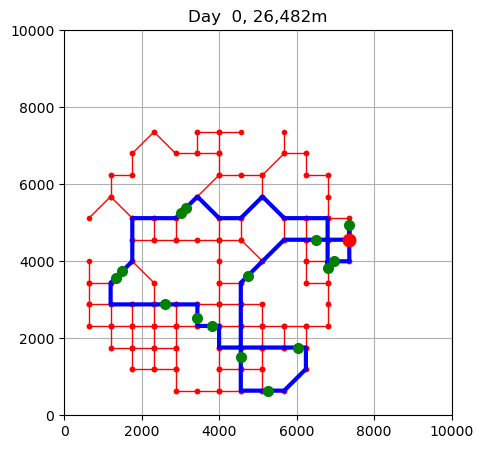

[ 0] 18:00:50.0 Parcel: 17 for customer 14 out for delivery
[ 0] 18:01:40.0 Parcel: 16 for customer 13 out for delivery
[ 0] 18:02:30.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:03:20.0 Parcel: 14 for customer 11 out for delivery
[ 0] 18:04:10.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:05:00.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:05:50.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:06:40.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:07:30.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:08:20.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:09:10.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:10:00.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:10:50.0 Parcel:  3 for customer 2 out for delivery
[ 0] 18:11:40.0 Parcel:  0 for customer 0 out for delivery
[ 0] 18:12:30.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:13:20.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:14:10.0 Parcel:  5 for customer 4 out for d

[ 1] 12:00:00.0 Parcel: 37 for customer 33 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


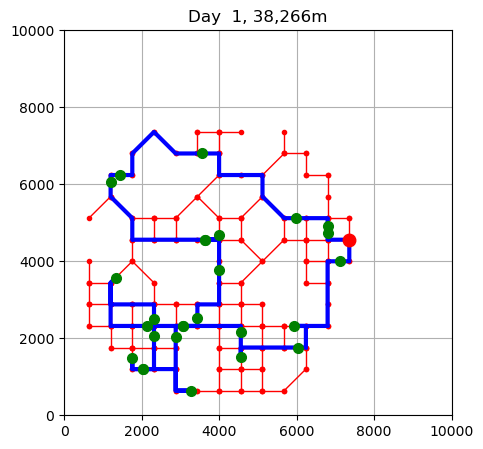

[ 1] 18:00:50.0 Parcel: 38 for customer 34 out for delivery
[ 1] 18:01:40.0 Parcel: 34 for customer 30 out for delivery
[ 1] 18:02:30.0 Parcel: 13 for customer 10 out for delivery
[ 1] 18:03:20.0 Parcel: 32 for customer 7 out for delivery
[ 1] 18:04:10.0 Parcel: 33 for customer 29 out for delivery
[ 1] 18:05:00.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:05:50.0 Parcel: 22 for customer 19 out for delivery
[ 1] 18:06:40.0 Parcel:  0 for customer 0 out for delivery
[ 1] 18:07:30.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:08:20.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:09:10.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:10:00.0 Parcel: 20 for customer 17 out for delivery
[ 1] 18:10:50.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:11:40.0 Parcel: 27 for customer 24 out for delivery
[ 1] 18:12:30.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:13:20.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:14:10.0 Parcel:  7 for customer 5 

[ 1] 21:17:48.4 Parcel: 21 for customer 18 return from delivery
[ 1] 21:18:18.4 Parcel: 29 for customer 26 return from delivery
[ 1] 21:18:48.4 Parcel: 31 for customer 28 return from delivery
[ 1] 21:19:18.4 Parcel: 19 for customer 16 return from delivery
[ 1] 21:19:48.4 Parcel: 36 for customer 32 return from delivery
[ 1] 21:30:18.4 7 left over for next day
[ 1] 21:30:18.4 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arr at delivery ce

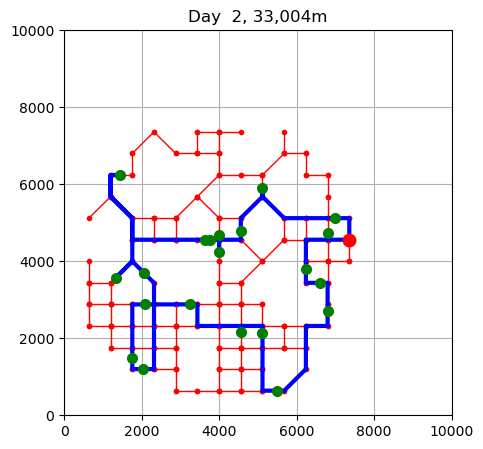

[ 2] 18:00:50.0 Parcel: 36 for customer 32 out for delivery
[ 2] 18:01:40.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:02:30.0 Parcel: 51 for customer 45 out for delivery
[ 2] 18:03:20.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:04:10.0 Parcel: 49 for customer 43 out for delivery
[ 2] 18:05:00.0 Parcel: 46 for customer 41 out for delivery
[ 2] 18:05:50.0 Parcel: 47 for customer 41 out for delivery
[ 2] 18:06:40.0 Parcel: 33 for customer 29 out for delivery
[ 2] 18:07:30.0 Parcel: 42 for customer 37 out for delivery
[ 2] 18:08:20.0 Parcel: 21 for customer 18 out for delivery
[ 2] 18:09:10.0 Parcel: 39 for customer 17 out for delivery
[ 2] 18:10:00.0 Parcel: 41 for customer 36 out for delivery
[ 2] 18:10:50.0 Parcel: 40 for customer 35 out for delivery
[ 2] 18:11:40.0 Parcel:  0 for customer 0 out for delivery
[ 2] 18:12:30.0 Parcel: 19 for customer 16 out for delivery
[ 2] 18:13:20.0 Parcel: 29 for customer 26 out for delivery
[ 2] 18:14:10.0 Parcel: 43 for customer 3

[ 3] 12:00:00.0 Parcel: 60 for customer 52 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 67 for customer 53 arr at delive

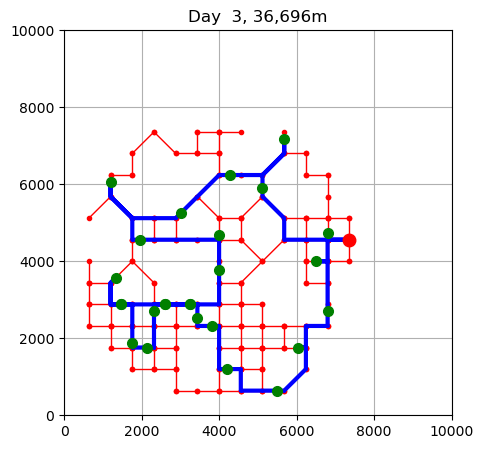

[ 3] 18:00:50.0 Parcel: 76 for customer 32 out for delivery
[ 3] 18:01:40.0 Parcel: 75 for customer 58 out for delivery
[ 3] 18:02:30.0 Parcel: 52 for customer 46 out for delivery
[ 3] 18:03:20.0 Parcel: 74 for customer 10 out for delivery
[ 3] 18:04:10.0 Parcel: 49 for customer 43 out for delivery
[ 3] 18:05:00.0 Parcel: 67 for customer 53 out for delivery
[ 3] 18:05:50.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:06:40.0 Parcel: 64 for customer 5 out for delivery
[ 3] 18:07:30.0 Parcel: 63 for customer 37 out for delivery
[ 3] 18:08:20.0 Parcel: 61 for customer 2 out for delivery
[ 3] 18:09:10.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:10:00.0 Parcel:  0 for customer 0 out for delivery
[ 3] 18:10:50.0 Parcel: 55 for customer 0 out for delivery
[ 3] 18:11:40.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:12:30.0 Parcel: 57 for customer 49 out for delivery
[ 3] 18:13:20.0 Parcel: 59 for customer 51 out for delivery
[ 3] 18:14:10.0 Parcel: 60 for customer 52 ou

[ 3] 21:12:13.6 Parcel: 64 for customer 5 return from delivery
[ 3] 21:12:43.6 Parcel: 61 for customer 2 return from delivery
[ 3] 21:13:13.6 Parcel: 56 for customer 48 return from delivery
[ 3] 21:13:43.6 Parcel: 59 for customer 51 return from delivery
[ 3] 21:14:13.6 Parcel: 60 for customer 52 return from delivery
[ 3] 21:14:43.6 Parcel: 66 for customer 27 return from delivery
[ 3] 21:15:13.6 Parcel: 54 for customer 15 return from delivery
[ 3] 21:25:43.6 11 left over for next day
[ 3] 21:25:43.6 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 80 for customer 16 arr at delivery centre
[ 4]

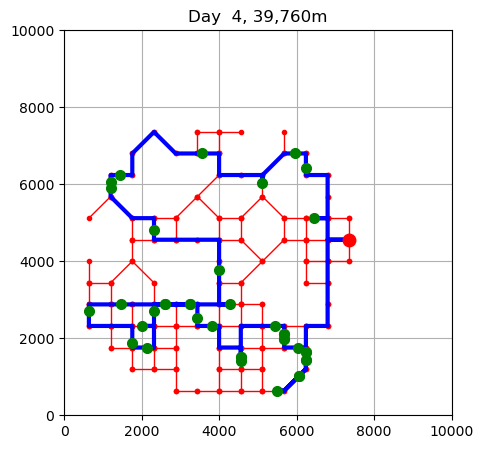

[ 4] 18:00:50.0 Parcel: 98 for customer 72 out for delivery
[ 4] 18:01:40.0 Parcel: 97 for customer 71 out for delivery
[ 4] 18:02:30.0 Parcel: 93 for customer 67 out for delivery
[ 4] 18:03:20.0 Parcel: 89 for customer 65 out for delivery
[ 4] 18:04:10.0 Parcel: 85 for customer 25 out for delivery
[ 4] 18:05:00.0 Parcel: 80 for customer 16 out for delivery
[ 4] 18:05:50.0 Parcel: 54 for customer 15 out for delivery
[ 4] 18:06:40.0 Parcel: 78 for customer 60 out for delivery
[ 4] 18:07:30.0 Parcel: 79 for customer 60 out for delivery
[ 4] 18:08:20.0 Parcel: 83 for customer 62 out for delivery
[ 4] 18:09:10.0 Parcel: 66 for customer 27 out for delivery
[ 4] 18:10:00.0 Parcel: 86 for customer 63 out for delivery
[ 4] 18:10:50.0 Parcel: 84 for customer 37 out for delivery
[ 4] 18:11:40.0 Parcel: 61 for customer 2 out for delivery
[ 4] 18:12:30.0 Parcel: 56 for customer 48 out for delivery
[ 4] 18:13:20.0 Parcel: 77 for customer 59 out for delivery
[ 4] 18:14:10.0 Parcel: 81 for customer 4

[ 4] 21:42:49.3 Parcel: 83 for customer 62 return from delivery
[ 4] 21:43:19.3 Parcel: 86 for customer 63 return from delivery
[ 4] 21:43:49.3 Parcel: 64 for customer 5 return from delivery
[ 4] 21:44:19.3 Parcel: 88 for customer 7 return from delivery
[ 4] 21:44:49.3 Parcel: 95 for customer 69 return from delivery
[ 4] 21:55:19.3 9 left over for next day
[ 4] 21:55:19.3 Driver goes home

[ 5] 12:00:00.0 Parcel: 101 for customer 74 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 101 for customer 74 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 103 for customer 76 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 103 for customer 76 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 104 for customer 15 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 104 for customer 15 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 105 for customer 48 arr at deli

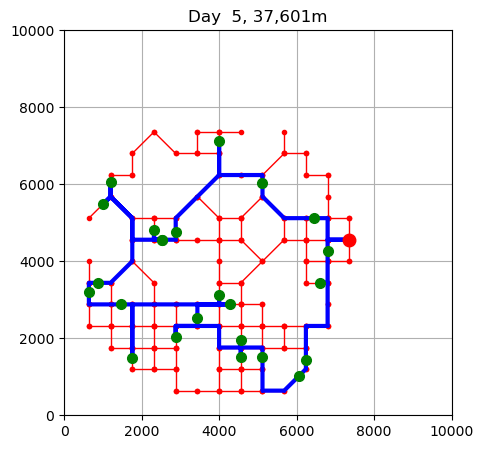

[ 5] 18:00:50.0 Parcel: 98 for customer 72 out for delivery
[ 5] 18:01:40.0 Parcel: 89 for customer 65 out for delivery
[ 5] 18:02:30.0 Parcel: 112 for customer 80 out for delivery
[ 5] 18:03:20.0 Parcel: 110 for customer 78 out for delivery
[ 5] 18:04:10.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:05:00.0 Parcel: 83 for customer 62 out for delivery
[ 5] 18:05:50.0 Parcel: 107 for customer 62 out for delivery
[ 5] 18:06:40.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:07:30.0 Parcel: 104 for customer 15 out for delivery
[ 5] 18:08:20.0 Parcel: 103 for customer 76 out for delivery
[ 5] 18:09:10.0 Parcel: 102 for customer 75 out for delivery
[ 5] 18:10:00.0 Parcel: 101 for customer 74 out for delivery
[ 5] 18:10:50.0 Parcel: 105 for customer 48 out for delivery
[ 5] 18:11:40.0 Parcel: 106 for customer 17 out for delivery
[ 5] 18:12:30.0 Parcel: 111 for customer 79 out for delivery
[ 5] 18:13:20.0 Parcel: 86 for customer 63 out for delivery
[ 5] 18:14:10.0 Parcel: 64 f

[ 5] 21:09:42.3 Parcel: 111 for customer 79 return from delivery
[ 5] 21:10:12.3 Parcel: 64 for customer 5 return from delivery
[ 5] 21:10:42.3 Parcel: 88 for customer 7 return from delivery
[ 5] 21:11:12.3 Parcel: 113 for customer 7 return from delivery
[ 5] 21:11:42.3 Parcel: 117 for customer 68 return from delivery
[ 5] 21:22:12.3 11 left over for next day
[ 5] 21:22:12.3 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 126 for customer 87 arr at d

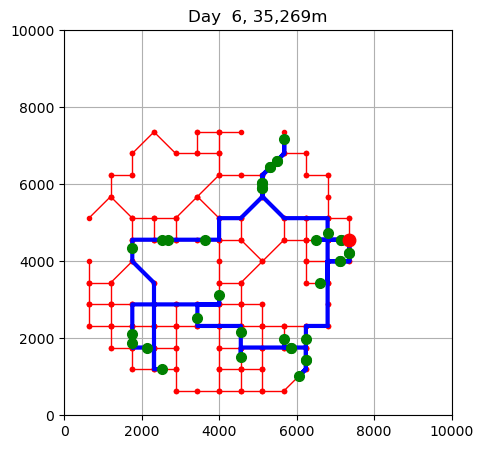

[ 6] 18:00:50.0 Parcel: 121 for customer 84 out for delivery
[ 6] 18:01:40.0 Parcel: 120 for customer 34 out for delivery
[ 6] 18:02:30.0 Parcel: 141 for customer 45 out for delivery
[ 6] 18:03:20.0 Parcel: 120 for customer 34 out for delivery
[ 6] 18:04:10.0 Parcel: 121 for customer 84 out for delivery
[ 6] 18:05:00.0 Parcel: 142 for customer 92 out for delivery
[ 6] 18:05:50.0 Parcel: 140 for customer 11 out for delivery
[ 6] 18:06:40.0 Parcel: 139 for customer 91 out for delivery
[ 6] 18:07:30.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:08:20.0 Parcel: 137 for customer 69 out for delivery
[ 6] 18:09:10.0 Parcel: 138 for customer 69 out for delivery
[ 6] 18:10:00.0 Parcel: 117 for customer 68 out for delivery
[ 6] 18:10:50.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:11:40.0 Parcel: 137 for customer 69 out for delivery
[ 6] 18:12:30.0 Parcel: 138 for customer 69 out for delivery
[ 6] 18:13:20.0 Parcel: 135 for customer 90 out for delivery
[ 6] 18:14:10.0 Parcel: 

[ 6] 21:32:12.2 Parcel: 64 for customer 5 return from delivery
[ 6] 21:32:42.2 Parcel: 111 for customer 79 return from delivery
[ 6] 21:33:12.2 Parcel: 125 for customer 51 return from delivery
[ 6] 21:33:42.2 Parcel: 126 for customer 87 return from delivery
[ 6] 21:34:12.2 Parcel: 124 for customer 86 return from delivery
[ 6] 21:34:42.2 Parcel: 116 for customer 83 return from delivery
[ 6] 21:35:12.2 Parcel: 130 for customer 42 return from delivery
[ 6] 21:35:42.2 Parcel: 131 for customer 42 return from delivery
[ 6] 21:36:12.2 Parcel: 142 for customer 92 return from delivery
[ 6] 21:46:42.2 13 left over for next day
[ 6] 21:46:42.2 Driver goes home

[ 7] 12:00:00.0 Parcel: 143 for customer 93 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 143 for customer 93 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 145 for customer 94 arr at delivery centr

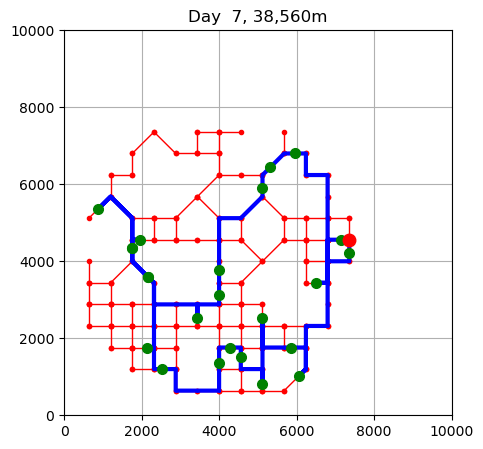

[ 7] 18:00:50.0 Parcel: 121 for customer 84 out for delivery
[ 7] 18:01:40.0 Parcel: 121 for customer 84 out for delivery
[ 7] 18:02:30.0 Parcel: 156 for customer 99 out for delivery
[ 7] 18:03:20.0 Parcel: 154 for customer 67 out for delivery
[ 7] 18:04:10.0 Parcel: 116 for customer 83 out for delivery
[ 7] 18:05:00.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:05:50.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:06:40.0 Parcel: 131 for customer 42 out for delivery
[ 7] 18:07:30.0 Parcel: 148 for customer 27 out for delivery
[ 7] 18:08:20.0 Parcel: 111 for customer 79 out for delivery
[ 7] 18:09:10.0 Parcel: 64 for customer 5 out for delivery
[ 7] 18:10:00.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:10:50.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:11:40.0 Parcel: 124 for customer 86 out for delivery
[ 7] 18:12:30.0 Parcel: 143 for customer 93 out for delivery
[ 7] 18:13:20.0 Parcel: 144 for customer 50 out for delivery
[ 7] 18:14:10.0 Parcel: 12

[ 7] 21:18:27.5 Parcel: 146 for customer 94 return from delivery
[ 7] 21:18:57.5 Parcel: 143 for customer 93 return from delivery
[ 7] 21:19:27.5 Parcel: 124 for customer 86 return from delivery
[ 7] 21:19:57.5 Parcel: 149 for customer 96 return from delivery
[ 7] 21:20:27.5 Parcel: 155 for customer 68 return from delivery
[ 7] 21:30:57.5 10 left over for next day
[ 7] 21:30:57.5 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 161 for customer 101 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 161 for customer 101 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 162 for customer 36 a

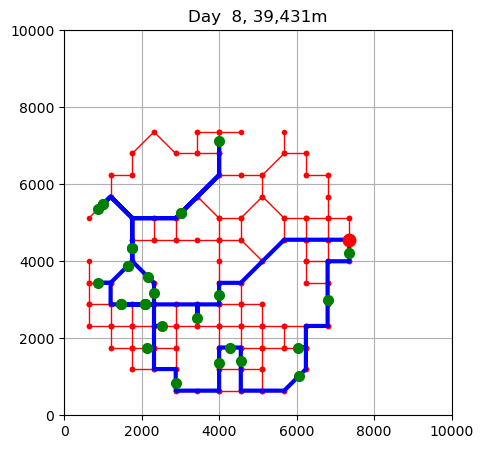

[ 8] 18:00:50.0 Parcel: 111 for customer 79 out for delivery
[ 8] 18:01:40.0 Parcel: 169 for customer 5 out for delivery
[ 8] 18:02:30.0 Parcel: 162 for customer 36 out for delivery
[ 8] 18:03:20.0 Parcel: 160 for customer 48 out for delivery
[ 8] 18:04:10.0 Parcel: 158 for customer 75 out for delivery
[ 8] 18:05:00.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:05:50.0 Parcel: 124 for customer 86 out for delivery
[ 8] 18:06:40.0 Parcel: 168 for customer 3 out for delivery
[ 8] 18:07:30.0 Parcel: 171 for customer 80 out for delivery
[ 8] 18:08:20.0 Parcel: 168 for customer 3 out for delivery
[ 8] 18:09:10.0 Parcel: 159 for customer 76 out for delivery
[ 8] 18:10:00.0 Parcel: 143 for customer 93 out for delivery
[ 8] 18:10:50.0 Parcel: 159 for customer 76 out for delivery
[ 8] 18:11:40.0 Parcel: 124 for customer 86 out for delivery
[ 8] 18:12:30.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:13:20.0 Parcel: 145 for customer 94 out for delivery
[ 8] 18:14:10.0 Parcel: 1

[ 8] 21:30:26.7 Parcel: 143 for customer 93 return from delivery
[ 8] 21:30:56.7 Parcel: 145 for customer 94 return from delivery
[ 8] 21:31:26.7 Parcel: 146 for customer 94 return from delivery
[ 8] 21:31:56.7 Parcel: 162 for customer 36 return from delivery
[ 8] 21:32:26.7 Parcel: 160 for customer 48 return from delivery
[ 8] 21:32:56.7 Parcel: 167 for customer 104 return from delivery
[ 8] 21:43:26.7 11 left over for next day
[ 8] 21:43:26.7 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arri

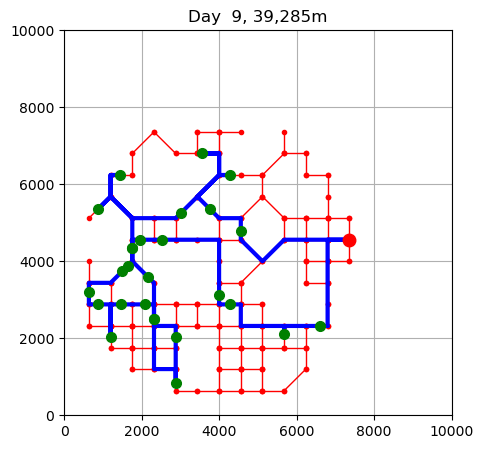

[ 9] 18:00:50.0 Parcel: 173 for customer 40 out for delivery
[ 9] 18:01:40.0 Parcel: 189 for customer 107 out for delivery
[ 9] 18:02:30.0 Parcel: 188 for customer 25 out for delivery
[ 9] 18:03:20.0 Parcel: 190 for customer 54 out for delivery
[ 9] 18:04:10.0 Parcel: 168 for customer 3 out for delivery
[ 9] 18:05:00.0 Parcel: 179 for customer 16 out for delivery
[ 9] 18:05:50.0 Parcel: 143 for customer 93 out for delivery
[ 9] 18:06:40.0 Parcel: 124 for customer 86 out for delivery
[ 9] 18:07:30.0 Parcel: 145 for customer 94 out for delivery
[ 9] 18:08:20.0 Parcel: 146 for customer 94 out for delivery
[ 9] 18:09:10.0 Parcel: 185 for customer 21 out for delivery
[ 9] 18:10:00.0 Parcel: 167 for customer 104 out for delivery
[ 9] 18:10:50.0 Parcel: 187 for customer 22 out for delivery
[ 9] 18:11:40.0 Parcel: 185 for customer 21 out for delivery
[ 9] 18:12:30.0 Parcel: 162 for customer 36 out for delivery
[ 9] 18:13:20.0 Parcel: 160 for customer 48 out for delivery
[ 9] 18:14:10.0 Parcel:

[ 9] 21:29:37.6 Parcel: 190 for customer 54 return from delivery
[ 9] 21:30:07.6 Parcel: 143 for customer 93 return from delivery
[ 9] 21:30:37.6 Parcel: 124 for customer 86 return from delivery
[ 9] 21:31:07.6 Parcel: 145 for customer 94 return from delivery
[ 9] 21:31:37.6 Parcel: 146 for customer 94 return from delivery
[ 9] 21:32:07.6 Parcel: 178 for customer 106 return from delivery
[ 9] 21:32:37.6 Parcel: 176 for customer 74 return from delivery
[ 9] 21:33:07.6 Parcel: 180 for customer 1 return from delivery
[ 9] 21:33:37.6 Parcel: 184 for customer 50 return from delivery
[ 9] 21:34:07.6 Parcel: 191 for customer 63 return from delivery
[ 9] 21:44:37.6 16 left over for next day
[ 9] 21:44:37.6 Driver goes home
Simulating the delivery of 198 parcels over 10 days to 150 customers

[ 0] 12:00:00.0 Parcel:  0 for customer 0 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  0 for customer 0 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arr at delivery centre
[ 0] 1

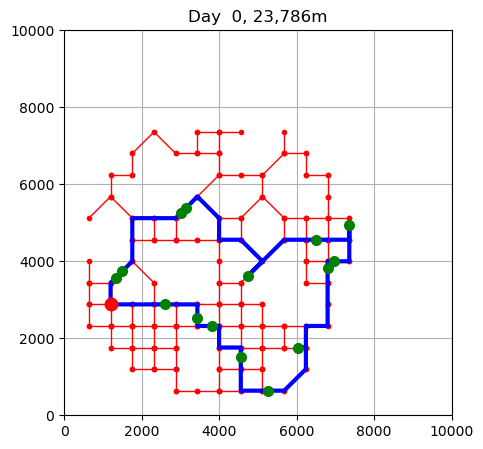

[ 0] 18:00:50.0 Parcel:  0 for customer 0 out for delivery
[ 0] 18:01:40.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:02:30.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:03:20.0 Parcel:  5 for customer 4 out for delivery
[ 0] 18:04:10.0 Parcel:  6 for customer 4 out for delivery
[ 0] 18:05:00.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:05:50.0 Parcel: 14 for customer 11 out for delivery
[ 0] 18:06:40.0 Parcel: 17 for customer 14 out for delivery
[ 0] 18:07:30.0 Parcel: 16 for customer 13 out for delivery
[ 0] 18:08:20.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:09:10.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:10:00.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:10:50.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:11:40.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:12:30.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:13:20.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:14:10.0 Parcel:  2 for customer 2 out for d

[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


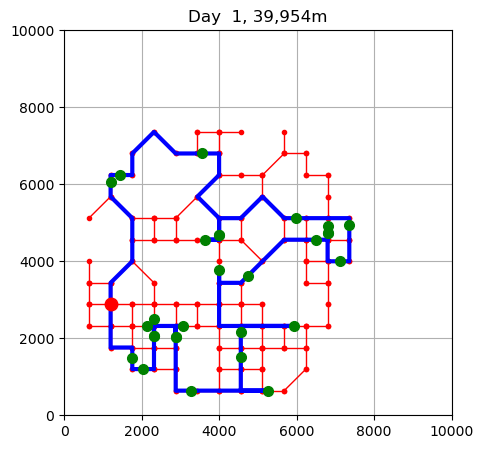

[ 1] 18:00:50.0 Parcel: 20 for customer 17 out for delivery
[ 1] 18:01:40.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:02:30.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:03:20.0 Parcel: 22 for customer 19 out for delivery
[ 1] 18:04:10.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:05:00.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:05:50.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:06:40.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:07:30.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:08:20.0 Parcel: 27 for customer 24 out for delivery
[ 1] 18:09:10.0 Parcel: 12 for customer 9 out for delivery
[ 1] 18:10:00.0 Parcel: 32 for customer 7 out for delivery
[ 1] 18:10:50.0 Parcel: 33 for customer 29 out for delivery
[ 1] 18:11:40.0 Parcel: 34 for customer 30 out for delivery
[ 1] 18:12:30.0 Parcel: 30 for customer 27 out for delivery
[ 1] 18:13:20.0 Parcel: 11 for customer 8 out for delivery
[ 1] 18:14:10.0 Parcel: 14 for customer 11 

[ 1] 21:25:30.6 Parcel: 24 for customer 21 return from delivery
[ 1] 21:26:00.6 Parcel: 25 for customer 22 return from delivery
[ 1] 21:26:30.6 Parcel: 34 for customer 30 return from delivery
[ 1] 21:27:00.6 Parcel: 36 for customer 32 return from delivery
[ 1] 21:27:30.6 Parcel: 31 for customer 28 return from delivery
[ 1] 21:28:00.6 Parcel: 19 for customer 16 return from delivery
[ 1] 21:38:30.6 7 left over for next day
[ 1] 21:38:30.6 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arrived in delivery cent

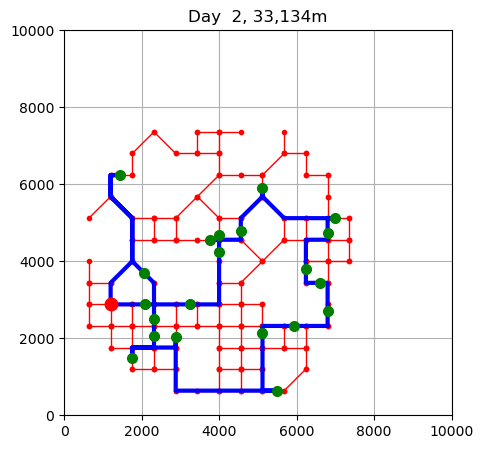

[ 2] 18:00:50.0 Parcel: 41 for customer 36 out for delivery
[ 2] 18:01:40.0 Parcel: 42 for customer 37 out for delivery
[ 2] 18:02:30.0 Parcel: 44 for customer 39 out for delivery
[ 2] 18:03:20.0 Parcel: 43 for customer 38 out for delivery
[ 2] 18:04:10.0 Parcel: 31 for customer 28 out for delivery
[ 2] 18:05:00.0 Parcel: 45 for customer 40 out for delivery
[ 2] 18:05:50.0 Parcel: 48 for customer 42 out for delivery
[ 2] 18:06:40.0 Parcel: 53 for customer 47 out for delivery
[ 2] 18:07:30.0 Parcel: 36 for customer 32 out for delivery
[ 2] 18:08:20.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:09:10.0 Parcel: 51 for customer 45 out for delivery
[ 2] 18:10:00.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:10:50.0 Parcel: 34 for customer 30 out for delivery
[ 2] 18:11:40.0 Parcel: 46 for customer 41 out for delivery
[ 2] 18:12:30.0 Parcel: 47 for customer 41 out for delivery
[ 2] 18:13:20.0 Parcel: 49 for customer 43 out for delivery
[ 2] 18:14:10.0 Parcel: 25 for customer 

[ 3] 12:00:00.0 Parcel: 61 for customer 2 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 61 for customer 2 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 62 for customer 3 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 67 for customer 53 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 67 for customer 53 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 68 for customer 54 arr at delive

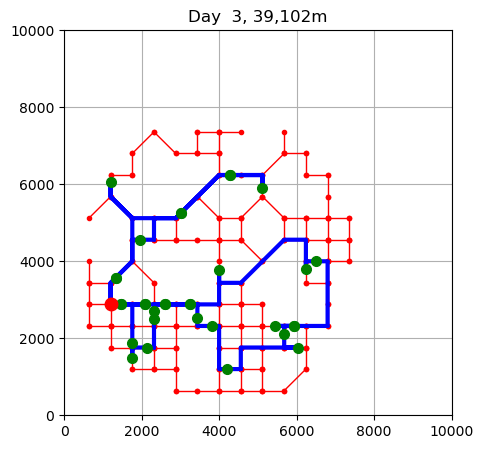

[ 3] 18:00:50.0 Parcel: 55 for customer 0 out for delivery
[ 3] 18:01:40.0 Parcel: 54 for customer 15 out for delivery
[ 3] 18:02:30.0 Parcel: 62 for customer 3 out for delivery
[ 3] 18:03:20.0 Parcel: 68 for customer 54 out for delivery
[ 3] 18:04:10.0 Parcel: 69 for customer 42 out for delivery
[ 3] 18:05:00.0 Parcel: 70 for customer 42 out for delivery
[ 3] 18:05:50.0 Parcel: 68 for customer 54 out for delivery
[ 3] 18:06:40.0 Parcel: 62 for customer 3 out for delivery
[ 3] 18:07:30.0 Parcel: 58 for customer 50 out for delivery
[ 3] 18:08:20.0 Parcel: 55 for customer 0 out for delivery
[ 3] 18:09:10.0 Parcel: 56 for customer 48 out for delivery
[ 3] 18:10:00.0 Parcel: 41 for customer 36 out for delivery
[ 3] 18:10:50.0 Parcel: 57 for customer 49 out for delivery
[ 3] 18:11:40.0 Parcel: 39 for customer 17 out for delivery
[ 3] 18:12:30.0 Parcel: 59 for customer 51 out for delivery
[ 3] 18:13:20.0 Parcel: 24 for customer 21 out for delivery
[ 3] 18:14:10.0 Parcel: 60 for customer 52 o

[ 3] 21:34:02.4 Parcel: 58 for customer 50 return from delivery
[ 3] 21:34:32.4 Parcel: 56 for customer 48 return from delivery
[ 3] 21:35:02.4 Parcel: 41 for customer 36 return from delivery
[ 3] 21:35:32.4 Parcel: 24 for customer 21 return from delivery
[ 3] 21:36:02.4 Parcel: 42 for customer 37 return from delivery
[ 3] 21:36:32.4 Parcel: 63 for customer 37 return from delivery
[ 3] 21:37:02.4 Parcel: 75 for customer 58 return from delivery
[ 3] 21:37:32.4 Parcel: 64 for customer 5 return from delivery
[ 3] 21:48:02.4 12 left over for next day
[ 3] 21:48:02.4 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arrived in delivery centre
[ 4] 

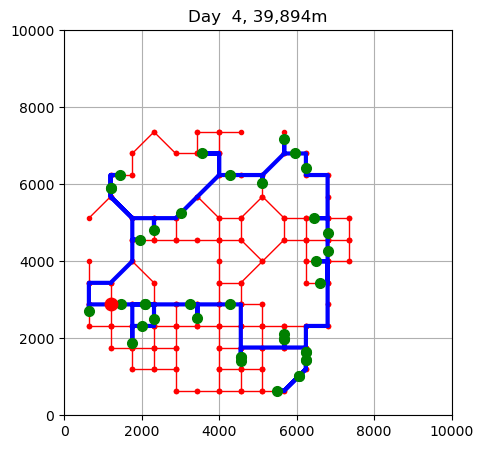

[ 4] 18:00:50.0 Parcel: 77 for customer 59 out for delivery
[ 4] 18:01:40.0 Parcel: 58 for customer 50 out for delivery
[ 4] 18:02:30.0 Parcel: 78 for customer 60 out for delivery
[ 4] 18:03:20.0 Parcel: 79 for customer 60 out for delivery
[ 4] 18:04:10.0 Parcel: 80 for customer 16 out for delivery
[ 4] 18:05:00.0 Parcel: 78 for customer 60 out for delivery
[ 4] 18:05:50.0 Parcel: 79 for customer 60 out for delivery
[ 4] 18:06:40.0 Parcel: 83 for customer 62 out for delivery
[ 4] 18:07:30.0 Parcel: 62 for customer 3 out for delivery
[ 4] 18:08:20.0 Parcel: 85 for customer 25 out for delivery
[ 4] 18:09:10.0 Parcel: 68 for customer 54 out for delivery
[ 4] 18:10:00.0 Parcel: 89 for customer 65 out for delivery
[ 4] 18:10:50.0 Parcel: 73 for customer 57 out for delivery
[ 4] 18:11:40.0 Parcel: 93 for customer 67 out for delivery
[ 4] 18:12:30.0 Parcel: 97 for customer 71 out for delivery
[ 4] 18:13:20.0 Parcel: 98 for customer 72 out for delivery
[ 4] 18:14:10.0 Parcel: 76 for customer 3

[ 4] 21:45:52.1 Parcel: 97 for customer 71 return from delivery
[ 4] 21:46:22.1 Parcel: 98 for customer 72 return from delivery
[ 4] 21:46:52.1 Parcel: 76 for customer 32 return from delivery
[ 4] 21:47:22.1 Parcel: 100 for customer 73 return from delivery
[ 4] 21:47:52.1 Parcel: 99 for customer 45 return from delivery
[ 4] 21:48:22.1 Parcel: 94 for customer 68 return from delivery
[ 4] 21:48:52.1 Parcel: 95 for customer 69 return from delivery
[ 4] 21:49:22.1 Parcel: 88 for customer 7 return from delivery
[ 4] 21:49:52.1 Parcel: 42 for customer 37 return from delivery
[ 4] 21:50:22.1 Parcel: 63 for customer 37 return from delivery
[ 4] 21:50:52.1 Parcel: 84 for customer 37 return from delivery
[ 4] 21:51:22.1 Parcel: 82 for customer 61 return from delivery
[ 4] 22:01:52.1 16 left over for next day
[ 4] 22:01:52.1 Driver goes home

[ 5] 12:00:00.0 Parcel: 101 for customer 74 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 101 for customer 74 arrived in delivery centre
[ 5] 12:00:00.0 Pa

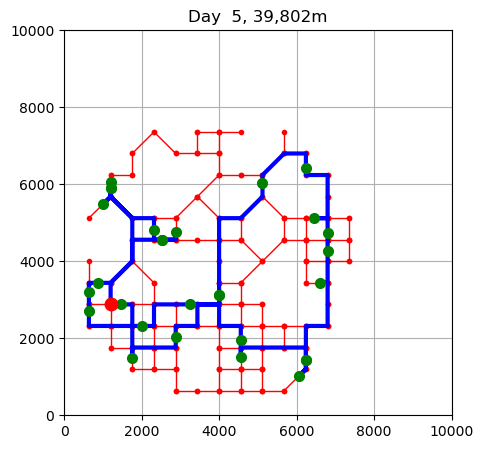

[ 5] 18:00:50.0 Parcel: 105 for customer 48 out for delivery
[ 5] 18:01:40.0 Parcel: 106 for customer 17 out for delivery
[ 5] 18:02:30.0 Parcel: 109 for customer 22 out for delivery
[ 5] 18:03:20.0 Parcel: 111 for customer 79 out for delivery
[ 5] 18:04:10.0 Parcel: 89 for customer 65 out for delivery
[ 5] 18:05:00.0 Parcel: 97 for customer 71 out for delivery
[ 5] 18:05:50.0 Parcel: 98 for customer 72 out for delivery
[ 5] 18:06:40.0 Parcel: 76 for customer 32 out for delivery
[ 5] 18:07:30.0 Parcel: 119 for customer 32 out for delivery
[ 5] 18:08:20.0 Parcel: 100 for customer 73 out for delivery
[ 5] 18:09:10.0 Parcel: 118 for customer 73 out for delivery
[ 5] 18:10:00.0 Parcel: 99 for customer 45 out for delivery
[ 5] 18:10:50.0 Parcel: 95 for customer 69 out for delivery
[ 5] 18:11:40.0 Parcel: 94 for customer 68 out for delivery
[ 5] 18:12:30.0 Parcel: 117 for customer 68 out for delivery
[ 5] 18:13:20.0 Parcel: 95 for customer 69 out for delivery
[ 5] 18:14:10.0 Parcel: 88 for c

[ 5] 21:34:37.4 Parcel: 117 for customer 68 return from delivery
[ 5] 21:35:07.4 Parcel: 111 for customer 79 return from delivery
[ 5] 21:35:37.4 Parcel: 82 for customer 61 return from delivery
[ 5] 21:36:07.4 Parcel: 77 for customer 59 return from delivery
[ 5] 21:36:37.4 Parcel: 110 for customer 78 return from delivery
[ 5] 21:37:07.4 Parcel: 108 for customer 77 return from delivery
[ 5] 21:37:37.4 Parcel: 104 for customer 15 return from delivery
[ 5] 21:48:07.4 15 left over for next day
[ 5] 21:48:07.4 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arr at delive

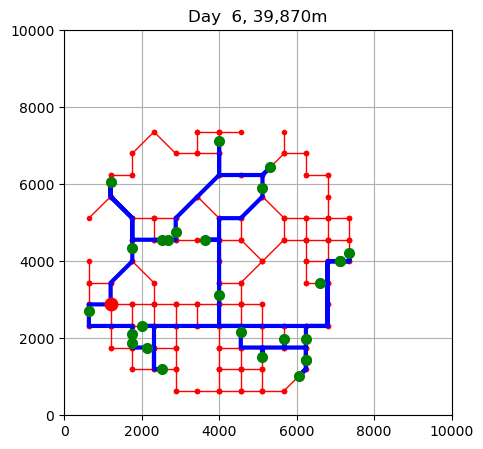

[ 6] 18:00:50.0 Parcel: 124 for customer 86 out for delivery
[ 6] 18:01:40.0 Parcel: 104 for customer 15 out for delivery
[ 6] 18:02:30.0 Parcel: 108 for customer 77 out for delivery
[ 6] 18:03:20.0 Parcel: 127 for customer 88 out for delivery
[ 6] 18:04:10.0 Parcel: 110 for customer 78 out for delivery
[ 6] 18:05:00.0 Parcel: 112 for customer 80 out for delivery
[ 6] 18:05:50.0 Parcel: 116 for customer 83 out for delivery
[ 6] 18:06:40.0 Parcel: 130 for customer 42 out for delivery
[ 6] 18:07:30.0 Parcel: 131 for customer 42 out for delivery
[ 6] 18:08:20.0 Parcel: 128 for customer 26 out for delivery
[ 6] 18:09:10.0 Parcel: 111 for customer 79 out for delivery
[ 6] 18:10:00.0 Parcel: 111 for customer 79 out for delivery
[ 6] 18:10:50.0 Parcel: 129 for customer 29 out for delivery
[ 6] 18:11:40.0 Parcel: 115 for customer 82 out for delivery
[ 6] 18:12:30.0 Parcel: 133 for customer 66 out for delivery
[ 6] 18:13:20.0 Parcel: 136 for customer 69 out for delivery
[ 6] 18:14:10.0 Parcel: 

[ 6] 21:31:57.9 Parcel: 131 for customer 42 return from delivery
[ 6] 21:32:27.9 Parcel: 128 for customer 26 return from delivery
[ 6] 21:32:57.9 Parcel: 133 for customer 66 return from delivery
[ 6] 21:33:27.9 Parcel: 126 for customer 87 return from delivery
[ 6] 21:33:57.9 Parcel: 122 for customer 49 return from delivery
[ 6] 21:44:27.9 13 left over for next day
[ 6] 21:44:27.9 Driver goes home

[ 7] 12:00:00.0 Parcel: 143 for customer 93 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 143 for customer 93 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 145 for customer 94 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 145 for customer 94 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 146 for customer 94 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 146 for customer 94 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 147 for customer 95 arr

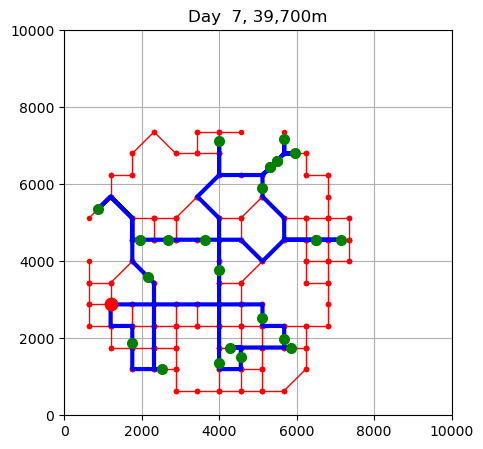

[ 7] 18:00:50.0 Parcel: 122 for customer 49 out for delivery
[ 7] 18:01:40.0 Parcel: 126 for customer 87 out for delivery
[ 7] 18:02:30.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:03:20.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:04:10.0 Parcel: 143 for customer 93 out for delivery
[ 7] 18:05:00.0 Parcel: 144 for customer 50 out for delivery
[ 7] 18:05:50.0 Parcel: 127 for customer 88 out for delivery
[ 7] 18:06:40.0 Parcel: 128 for customer 26 out for delivery
[ 7] 18:07:30.0 Parcel: 140 for customer 11 out for delivery
[ 7] 18:08:20.0 Parcel: 142 for customer 92 out for delivery
[ 7] 18:09:10.0 Parcel: 140 for customer 11 out for delivery
[ 7] 18:10:00.0 Parcel: 130 for customer 42 out for delivery
[ 7] 18:10:50.0 Parcel: 131 for customer 42 out for delivery
[ 7] 18:11:40.0 Parcel: 153 for customer 83 out for delivery
[ 7] 18:12:30.0 Parcel: 132 for customer 89 out for delivery
[ 7] 18:13:20.0 Parcel: 154 for customer 67 out for delivery
[ 7] 18:14:10.0 Parcel: 

[ 7] 21:21:30.9 Parcel: 140 for customer 11 return from delivery
[ 7] 21:22:00.9 Parcel: 134 for customer 57 return from delivery
[ 7] 21:22:30.9 Parcel: 147 for customer 95 return from delivery
[ 7] 21:23:00.9 Parcel: 149 for customer 96 return from delivery
[ 7] 21:33:30.9 11 left over for next day
[ 7] 21:33:30.9 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 161 for customer 101 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 161 for customer 101 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 162 for customer 36 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 162 for customer 36

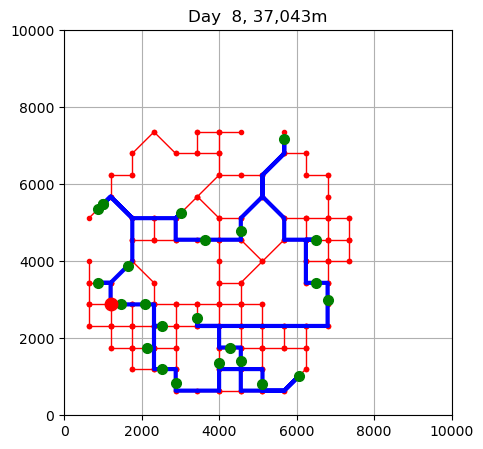

[ 8] 18:00:50.0 Parcel: 160 for customer 48 out for delivery
[ 8] 18:01:40.0 Parcel: 162 for customer 36 out for delivery
[ 8] 18:02:30.0 Parcel: 166 for customer 103 out for delivery
[ 8] 18:03:20.0 Parcel: 163 for customer 51 out for delivery
[ 8] 18:04:10.0 Parcel: 126 for customer 87 out for delivery
[ 8] 18:05:00.0 Parcel: 167 for customer 104 out for delivery
[ 8] 18:05:50.0 Parcel: 147 for customer 95 out for delivery
[ 8] 18:06:40.0 Parcel: 170 for customer 95 out for delivery
[ 8] 18:07:30.0 Parcel: 151 for customer 97 out for delivery
[ 8] 18:08:20.0 Parcel: 155 for customer 68 out for delivery
[ 8] 18:09:10.0 Parcel: 172 for customer 64 out for delivery
[ 8] 18:10:00.0 Parcel: 149 for customer 96 out for delivery
[ 8] 18:10:50.0 Parcel: 169 for customer 5 out for delivery
[ 8] 18:11:40.0 Parcel: 157 for customer 100 out for delivery
[ 8] 18:12:30.0 Parcel: 156 for customer 99 out for delivery
[ 8] 18:13:20.0 Parcel: 140 for customer 11 out for delivery
[ 8] 18:14:10.0 Parcel

[ 8] 21:12:12.9 Parcel: 128 for customer 26 return from delivery
[ 8] 21:12:42.9 Parcel: 159 for customer 76 return from delivery
[ 8] 21:23:12.9 13 left over for next day
[ 8] 21:23:12.9 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 180 for customer 1 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 180 for customer 1 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 181 for customer 101 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 181 for cu

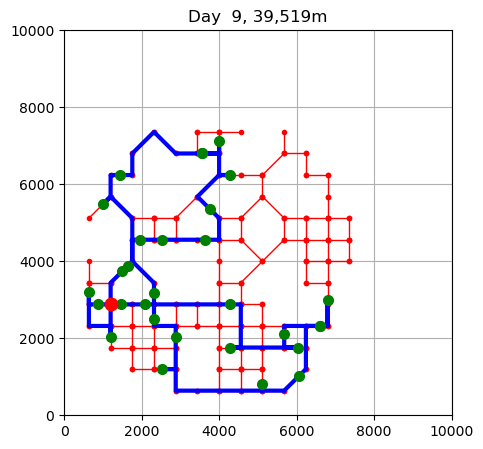

[ 9] 18:00:50.0 Parcel: 178 for customer 106 out for delivery
[ 9] 18:01:40.0 Parcel: 176 for customer 74 out for delivery
[ 9] 18:02:30.0 Parcel: 177 for customer 105 out for delivery
[ 9] 18:03:20.0 Parcel: 160 for customer 48 out for delivery
[ 9] 18:04:10.0 Parcel: 162 for customer 36 out for delivery
[ 9] 18:05:00.0 Parcel: 191 for customer 63 out for delivery
[ 9] 18:05:50.0 Parcel: 192 for customer 96 out for delivery
[ 9] 18:06:40.0 Parcel: 175 for customer 10 out for delivery
[ 9] 18:07:30.0 Parcel: 174 for customer 56 out for delivery
[ 9] 18:08:20.0 Parcel: 196 for customer 56 out for delivery
[ 9] 18:09:10.0 Parcel: 197 for customer 110 out for delivery
[ 9] 18:10:00.0 Parcel: 157 for customer 100 out for delivery
[ 9] 18:10:50.0 Parcel: 197 for customer 110 out for delivery
[ 9] 18:11:40.0 Parcel: 155 for customer 68 out for delivery
[ 9] 18:12:30.0 Parcel: 151 for customer 97 out for delivery
[ 9] 18:13:20.0 Parcel: 126 for customer 87 out for delivery
[ 9] 18:14:10.0 Par

[ 9] 21:34:03.6 Parcel: 157 for customer 100 return from delivery
[ 9] 21:34:33.6 Parcel: 164 for customer 102 return from delivery
[ 9] 21:35:03.6 Parcel: 165 for customer 102 return from delivery
[ 9] 21:35:33.6 Parcel: 186 for customer 77 return from delivery
[ 9] 21:36:03.6 Parcel: 128 for customer 26 return from delivery
[ 9] 21:36:33.6 Parcel: 190 for customer 54 return from delivery
[ 9] 21:37:03.6 Parcel: 171 for customer 80 return from delivery
[ 9] 21:37:33.6 Parcel: 159 for customer 76 return from delivery
[ 9] 21:48:03.6 15 left over for next day
[ 9] 21:48:03.6 Driver goes home
Simulating the delivery of 198 parcels over 10 days to 150 customers

[ 0] 12:00:00.0 Parcel:  0 for customer 0 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  0 for customer 0 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arr at delivery centre

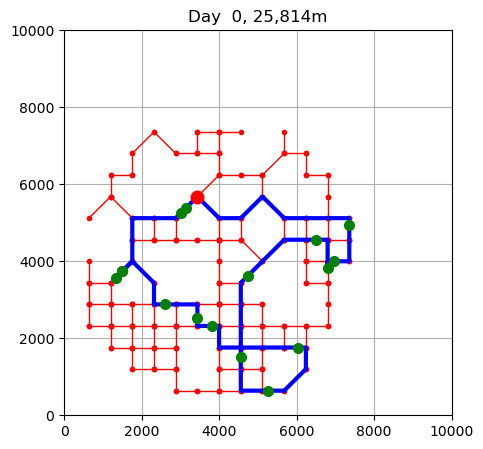

[ 0] 18:00:50.0 Parcel:  5 for customer 4 out for delivery
[ 0] 18:01:40.0 Parcel:  6 for customer 4 out for delivery
[ 0] 18:02:30.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:03:20.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:04:10.0 Parcel:  0 for customer 0 out for delivery
[ 0] 18:05:00.0 Parcel:  1 for customer 1 out for delivery
[ 0] 18:05:50.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:06:40.0 Parcel:  3 for customer 2 out for delivery
[ 0] 18:07:30.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:08:20.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:09:10.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:10:00.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:10:50.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:11:40.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:12:30.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:13:20.0 Parcel: 14 for customer 11 out for delivery
[ 0] 18:14:10.0 Parcel: 15 for customer 12 out for del

[ 1] 12:00:00.0 Parcel: 36 for customer 32 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 36 for customer 32 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


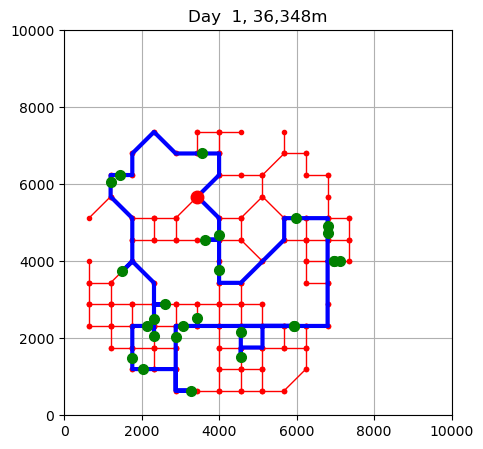

[ 1] 18:00:50.0 Parcel: 28 for customer 25 out for delivery
[ 1] 18:01:40.0 Parcel: 19 for customer 16 out for delivery
[ 1] 18:02:30.0 Parcel: 18 for customer 15 out for delivery
[ 1] 18:03:20.0 Parcel:  1 for customer 1 out for delivery
[ 1] 18:04:10.0 Parcel:  2 for customer 2 out for delivery
[ 1] 18:05:00.0 Parcel:  3 for customer 2 out for delivery
[ 1] 18:05:50.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:06:40.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:07:30.0 Parcel: 22 for customer 19 out for delivery
[ 1] 18:08:20.0 Parcel: 20 for customer 17 out for delivery
[ 1] 18:09:10.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:10:00.0 Parcel: 27 for customer 24 out for delivery
[ 1] 18:10:50.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:11:40.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:12:30.0 Parcel:  7 for customer 5 out for delivery
[ 1] 18:13:20.0 Parcel:  8 for customer 5 out for delivery
[ 1] 18:14:10.0 Parcel: 34 for customer 30 ou

[ 1] 21:16:08.2 Parcel: 26 for customer 23 return from delivery
[ 1] 21:16:38.2 Parcel: 33 for customer 29 return from delivery
[ 1] 21:17:08.2 Parcel: 34 for customer 30 return from delivery
[ 1] 21:17:38.2 Parcel: 16 for customer 13 return from delivery
[ 1] 21:18:08.2 Parcel: 38 for customer 34 return from delivery
[ 1] 21:18:38.2 Parcel: 16 for customer 13 return from delivery
[ 1] 21:19:08.2 Parcel: 37 for customer 33 return from delivery
[ 1] 21:29:38.2 10 left over for next day
[ 1] 21:29:38.2 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 

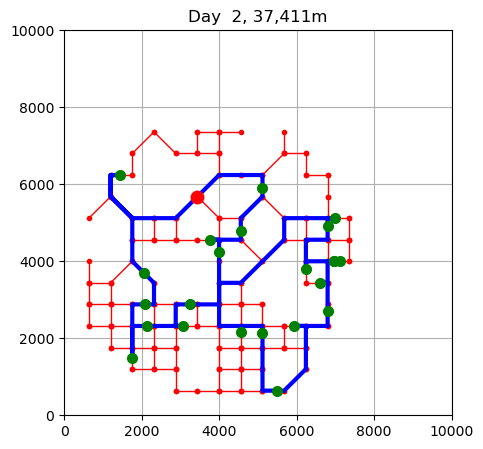

[ 2] 18:00:50.0 Parcel: 19 for customer 16 out for delivery
[ 2] 18:01:40.0 Parcel: 40 for customer 35 out for delivery
[ 2] 18:02:30.0 Parcel: 41 for customer 36 out for delivery
[ 2] 18:03:20.0 Parcel: 20 for customer 17 out for delivery
[ 2] 18:04:10.0 Parcel: 39 for customer 17 out for delivery
[ 2] 18:05:00.0 Parcel: 22 for customer 19 out for delivery
[ 2] 18:05:50.0 Parcel: 26 for customer 23 out for delivery
[ 2] 18:06:40.0 Parcel: 42 for customer 37 out for delivery
[ 2] 18:07:30.0 Parcel: 53 for customer 47 out for delivery
[ 2] 18:08:20.0 Parcel: 37 for customer 33 out for delivery
[ 2] 18:09:10.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:10:00.0 Parcel: 16 for customer 13 out for delivery
[ 2] 18:10:50.0 Parcel: 16 for customer 13 out for delivery
[ 2] 18:11:40.0 Parcel: 38 for customer 34 out for delivery
[ 2] 18:12:30.0 Parcel: 16 for customer 13 out for delivery
[ 2] 18:13:20.0 Parcel: 16 for customer 13 out for delivery
[ 2] 18:14:10.0 Parcel: 51 for customer 

[ 2] 21:25:55.7 10 left over for next day
[ 2] 21:25:55.7 Driver goes home

[ 3] 12:00:00.0 Parcel: 54 for customer 15 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 54 for customer 15 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 55 for customer 0 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 55 for customer 0 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 56 for customer 48 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 56 for customer 48 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 57 for customer 49 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 57 for customer 49 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 58 for customer 50 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 58 for customer 50 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 59 for customer 51 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 59 for customer 51 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 60 for customer 52 a

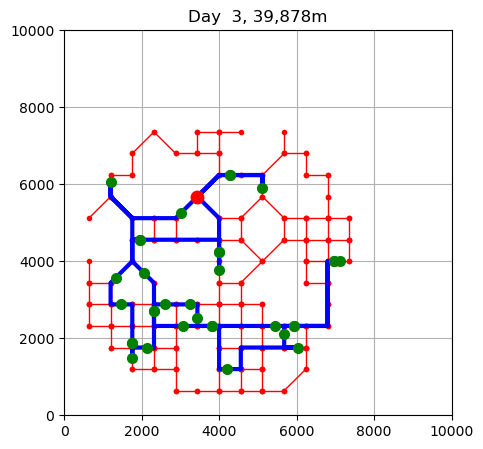

[ 3] 18:00:50.0 Parcel: 68 for customer 54 out for delivery
[ 3] 18:01:40.0 Parcel: 69 for customer 42 out for delivery
[ 3] 18:02:30.0 Parcel: 70 for customer 42 out for delivery
[ 3] 18:03:20.0 Parcel: 68 for customer 54 out for delivery
[ 3] 18:04:10.0 Parcel: 62 for customer 3 out for delivery
[ 3] 18:05:00.0 Parcel: 54 for customer 15 out for delivery
[ 3] 18:05:50.0 Parcel: 58 for customer 50 out for delivery
[ 3] 18:06:40.0 Parcel: 40 for customer 35 out for delivery
[ 3] 18:07:30.0 Parcel: 60 for customer 52 out for delivery
[ 3] 18:08:20.0 Parcel: 26 for customer 23 out for delivery
[ 3] 18:09:10.0 Parcel: 65 for customer 6 out for delivery
[ 3] 18:10:00.0 Parcel: 71 for customer 55 out for delivery
[ 3] 18:10:50.0 Parcel: 34 for customer 30 out for delivery
[ 3] 18:11:40.0 Parcel: 16 for customer 13 out for delivery
[ 3] 18:12:30.0 Parcel: 16 for customer 13 out for delivery
[ 3] 18:13:20.0 Parcel: 38 for customer 34 out for delivery
[ 3] 18:14:10.0 Parcel: 16 for customer 13

[ 3] 21:41:17.6 Parcel: 16 for customer 13 return from delivery
[ 3] 21:41:47.6 Parcel: 16 for customer 13 return from delivery
[ 3] 21:42:17.6 Parcel: 38 for customer 34 return from delivery
[ 3] 21:42:47.6 Parcel: 72 for customer 56 return from delivery
[ 3] 21:43:17.6 Parcel: 74 for customer 10 return from delivery
[ 3] 21:43:47.6 Parcel: 67 for customer 53 return from delivery
[ 3] 21:44:17.6 Parcel: 42 for customer 37 return from delivery
[ 3] 21:44:47.6 Parcel: 63 for customer 37 return from delivery
[ 3] 21:45:17.6 Parcel: 59 for customer 51 return from delivery
[ 3] 21:45:47.6 Parcel: 57 for customer 49 return from delivery
[ 3] 21:46:17.6 Parcel: 44 for customer 39 return from delivery
[ 3] 21:56:47.6 17 left over for next day
[ 3] 21:56:47.6 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Pa

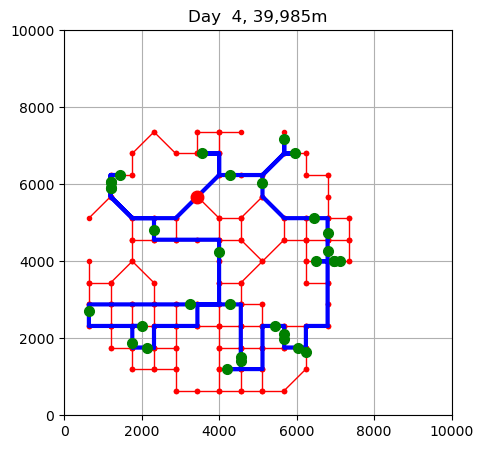

[ 4] 18:00:50.0 Parcel: 85 for customer 25 out for delivery
[ 4] 18:01:40.0 Parcel: 68 for customer 54 out for delivery
[ 4] 18:02:30.0 Parcel: 93 for customer 67 out for delivery
[ 4] 18:03:20.0 Parcel: 73 for customer 57 out for delivery
[ 4] 18:04:10.0 Parcel: 89 for customer 65 out for delivery
[ 4] 18:05:00.0 Parcel: 98 for customer 72 out for delivery
[ 4] 18:05:50.0 Parcel: 76 for customer 32 out for delivery
[ 4] 18:06:40.0 Parcel: 100 for customer 73 out for delivery
[ 4] 18:07:30.0 Parcel: 16 for customer 13 out for delivery
[ 4] 18:08:20.0 Parcel: 16 for customer 13 out for delivery
[ 4] 18:09:10.0 Parcel: 38 for customer 34 out for delivery
[ 4] 18:10:00.0 Parcel: 16 for customer 13 out for delivery
[ 4] 18:10:50.0 Parcel: 16 for customer 13 out for delivery
[ 4] 18:11:40.0 Parcel: 75 for customer 58 out for delivery
[ 4] 18:12:30.0 Parcel: 96 for customer 70 out for delivery
[ 4] 18:13:20.0 Parcel: 74 for customer 10 out for delivery
[ 4] 18:14:10.0 Parcel: 91 for customer

[ 4] 21:41:07.1 Parcel: 76 for customer 32 return from delivery
[ 4] 21:41:37.1 Parcel: 100 for customer 73 return from delivery
[ 4] 21:42:07.1 Parcel: 38 for customer 34 return from delivery
[ 4] 21:42:37.1 Parcel: 96 for customer 70 return from delivery
[ 4] 21:43:07.1 Parcel: 72 for customer 56 return from delivery
[ 4] 21:43:37.1 Parcel: 92 for customer 56 return from delivery
[ 4] 21:44:07.1 Parcel: 87 for customer 64 return from delivery
[ 4] 21:44:37.1 Parcel: 88 for customer 7 return from delivery
[ 4] 21:45:07.1 Parcel: 86 for customer 63 return from delivery
[ 4] 21:45:37.1 Parcel: 59 for customer 51 return from delivery
[ 4] 21:46:07.1 Parcel: 57 for customer 49 return from delivery
[ 4] 21:46:37.1 Parcel: 81 for customer 49 return from delivery
[ 4] 21:47:07.1 Parcel: 78 for customer 60 return from delivery
[ 4] 21:47:37.1 Parcel: 79 for customer 60 return from delivery
[ 4] 21:58:07.1 21 left over for next day
[ 4] 21:58:07.1 Driver goes home

[ 5] 12:00:00.0 Parcel: 101 

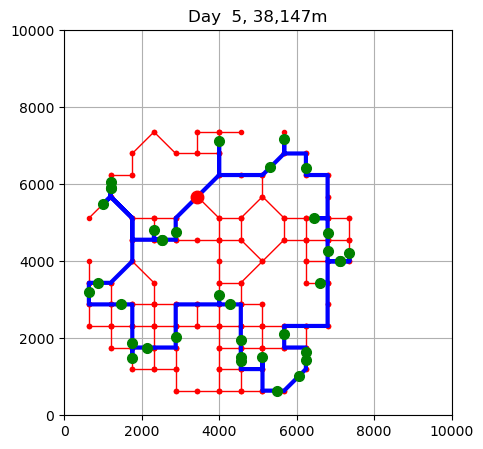

[ 5] 18:00:50.0 Parcel: 110 for customer 78 out for delivery
[ 5] 18:01:40.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:02:30.0 Parcel: 107 for customer 62 out for delivery
[ 5] 18:03:20.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:04:10.0 Parcel: 103 for customer 76 out for delivery
[ 5] 18:05:00.0 Parcel: 78 for customer 60 out for delivery
[ 5] 18:05:50.0 Parcel: 79 for customer 60 out for delivery
[ 5] 18:06:40.0 Parcel: 104 for customer 15 out for delivery
[ 5] 18:07:30.0 Parcel: 78 for customer 60 out for delivery
[ 5] 18:08:20.0 Parcel: 79 for customer 60 out for delivery
[ 5] 18:09:10.0 Parcel: 102 for customer 75 out for delivery
[ 5] 18:10:00.0 Parcel: 101 for customer 74 out for delivery
[ 5] 18:10:50.0 Parcel: 105 for customer 48 out for delivery
[ 5] 18:11:40.0 Parcel: 57 for customer 49 out for delivery
[ 5] 18:12:30.0 Parcel: 81 for customer 49 out for delivery
[ 5] 18:13:20.0 Parcel: 106 for customer 17 out for delivery
[ 5] 18:14:10.0 Parcel: 59 for

[ 5] 21:39:04.4 Parcel: 78 for customer 60 return from delivery
[ 5] 21:39:34.4 Parcel: 79 for customer 60 return from delivery
[ 5] 21:40:04.4 Parcel: 106 for customer 17 return from delivery
[ 5] 21:40:34.4 Parcel: 115 for customer 82 return from delivery
[ 5] 21:41:04.4 Parcel: 94 for customer 68 return from delivery
[ 5] 21:41:34.4 Parcel: 117 for customer 68 return from delivery
[ 5] 21:42:04.4 Parcel: 95 for customer 69 return from delivery
[ 5] 21:42:34.4 Parcel: 38 for customer 34 return from delivery
[ 5] 21:43:04.4 Parcel: 120 for customer 34 return from delivery
[ 5] 21:43:34.4 Parcel: 38 for customer 34 return from delivery
[ 5] 21:44:04.4 Parcel: 120 for customer 34 return from delivery
[ 5] 21:44:34.4 Parcel: 100 for customer 73 return from delivery
[ 5] 21:45:04.4 Parcel: 118 for customer 73 return from delivery
[ 5] 21:45:34.4 Parcel: 76 for customer 32 return from delivery
[ 5] 21:46:04.4 Parcel: 119 for customer 32 return from delivery
[ 5] 21:46:34.4 Parcel: 116 for 

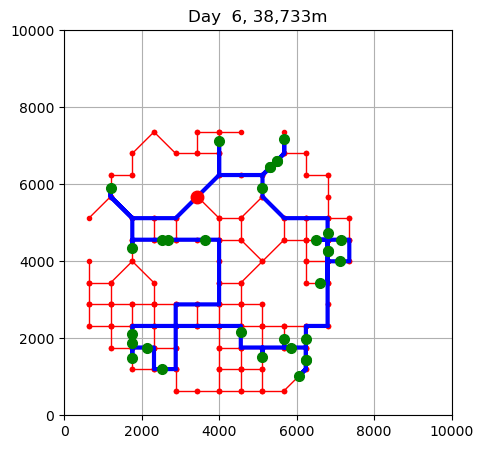

[ 6] 18:00:50.0 Parcel: 112 for customer 80 out for delivery
[ 6] 18:01:40.0 Parcel: 116 for customer 83 out for delivery
[ 6] 18:02:30.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:03:20.0 Parcel: 134 for customer 57 out for delivery
[ 6] 18:04:10.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:05:00.0 Parcel: 116 for customer 83 out for delivery
[ 6] 18:05:50.0 Parcel: 130 for customer 42 out for delivery
[ 6] 18:06:40.0 Parcel: 131 for customer 42 out for delivery
[ 6] 18:07:30.0 Parcel: 76 for customer 32 out for delivery
[ 6] 18:08:20.0 Parcel: 119 for customer 32 out for delivery
[ 6] 18:09:10.0 Parcel: 142 for customer 92 out for delivery
[ 6] 18:10:00.0 Parcel: 38 for customer 34 out for delivery
[ 6] 18:10:50.0 Parcel: 120 for customer 34 out for delivery
[ 6] 18:11:40.0 Parcel: 38 for customer 34 out for delivery
[ 6] 18:12:30.0 Parcel: 120 for customer 34 out for delivery
[ 6] 18:13:20.0 Parcel: 141 for customer 45 out for delivery
[ 6] 18:14:10.0 Parcel: 100

[ 6] 21:42:59.6 Parcel: 118 for customer 73 return from delivery
[ 6] 21:43:29.6 Parcel: 139 for customer 91 return from delivery
[ 6] 21:43:59.6 Parcel: 135 for customer 90 return from delivery
[ 6] 21:44:29.6 Parcel: 115 for customer 82 return from delivery
[ 6] 21:44:59.6 Parcel: 125 for customer 51 return from delivery
[ 6] 21:45:29.6 Parcel: 128 for customer 26 return from delivery
[ 6] 21:45:59.6 Parcel: 127 for customer 88 return from delivery
[ 6] 21:56:29.6 9 left over for next day
[ 6] 21:56:29.6 Driver goes home

[ 7] 12:00:00.0 Parcel: 143 for customer 93 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 143 for customer 93 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 145 for customer 94 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 145 for customer 94 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 146 for customer 94 arr at deliv

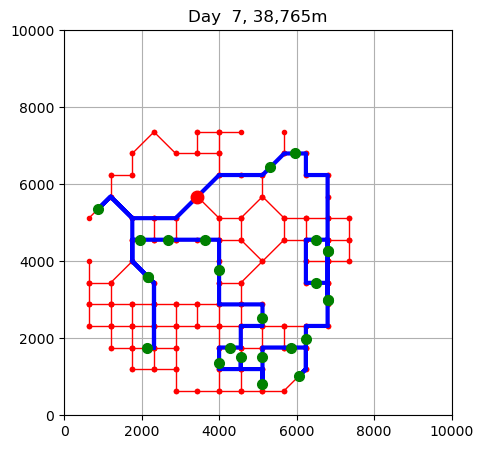

[ 7] 18:00:50.0 Parcel: 143 for customer 93 out for delivery
[ 7] 18:01:40.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:02:30.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:03:20.0 Parcel: 125 for customer 51 out for delivery
[ 7] 18:04:10.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:05:00.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:05:50.0 Parcel: 144 for customer 50 out for delivery
[ 7] 18:06:40.0 Parcel: 127 for customer 88 out for delivery
[ 7] 18:07:30.0 Parcel: 128 for customer 26 out for delivery
[ 7] 18:08:20.0 Parcel: 148 for customer 27 out for delivery
[ 7] 18:09:10.0 Parcel: 152 for customer 98 out for delivery
[ 7] 18:10:00.0 Parcel: 149 for customer 96 out for delivery
[ 7] 18:10:50.0 Parcel: 147 for customer 95 out for delivery
[ 7] 18:11:40.0 Parcel: 150 for customer 7 out for delivery
[ 7] 18:12:30.0 Parcel: 151 for customer 97 out for delivery
[ 7] 18:13:20.0 Parcel: 115 for customer 82 out for delivery
[ 7] 18:14:10.0 Parcel: 1

[ 7] 21:20:38.8 Parcel: 149 for customer 96 return from delivery
[ 7] 21:21:08.8 Parcel: 150 for customer 7 return from delivery
[ 7] 21:21:38.8 Parcel: 155 for customer 68 return from delivery
[ 7] 21:22:08.8 Parcel: 153 for customer 83 return from delivery
[ 7] 21:32:38.8 10 left over for next day
[ 7] 21:32:38.8 Driver goes home

[ 8] 12:00:00.0 Parcel: 158 for customer 75 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 158 for customer 75 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 159 for customer 76 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 160 for customer 48 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 161 for customer 101 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 161 for customer 101 arrived in delivery centre
[ 8] 12:00:00.0 Parcel: 162 for customer 36 arr at delivery centre
[ 8] 12:00:00.0 Parcel: 162 for customer 36 

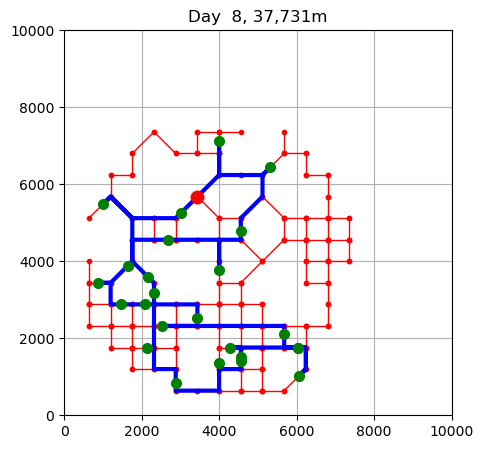

[ 8] 18:00:50.0 Parcel: 168 for customer 3 out for delivery
[ 8] 18:01:40.0 Parcel: 159 for customer 76 out for delivery
[ 8] 18:02:30.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:03:20.0 Parcel: 158 for customer 75 out for delivery
[ 8] 18:04:10.0 Parcel: 160 for customer 48 out for delivery
[ 8] 18:05:00.0 Parcel: 162 for customer 36 out for delivery
[ 8] 18:05:50.0 Parcel: 163 for customer 51 out for delivery
[ 8] 18:06:40.0 Parcel: 167 for customer 104 out for delivery
[ 8] 18:07:30.0 Parcel: 170 for customer 95 out for delivery
[ 8] 18:08:20.0 Parcel: 172 for customer 64 out for delivery
[ 8] 18:09:10.0 Parcel: 150 for customer 7 out for delivery
[ 8] 18:10:00.0 Parcel: 149 for customer 96 out for delivery
[ 8] 18:10:50.0 Parcel: 175 for customer 10 out for delivery
[ 8] 18:11:40.0 Parcel: 155 for customer 68 out for delivery
[ 8] 18:12:30.0 Parcel: 175 for customer 10 out for delivery
[ 8] 18:13:20.0 Parcel: 174 for customer 56 out for delivery
[ 8] 18:14:10.0 Parcel: 

[ 8] 21:19:45.2 Parcel: 155 for customer 68 return from delivery
[ 8] 21:20:15.2 Parcel: 174 for customer 56 return from delivery
[ 8] 21:20:45.2 Parcel: 127 for customer 88 return from delivery
[ 8] 21:31:15.2 7 left over for next day
[ 8] 21:31:15.2 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 177 for customer 105 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 178 for customer 106 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 179 for customer 16 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 180 for customer 1 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 180 for customer 1 arrived in delivery centre
[ 9] 12:00:00.0 Parcel: 181 for custom

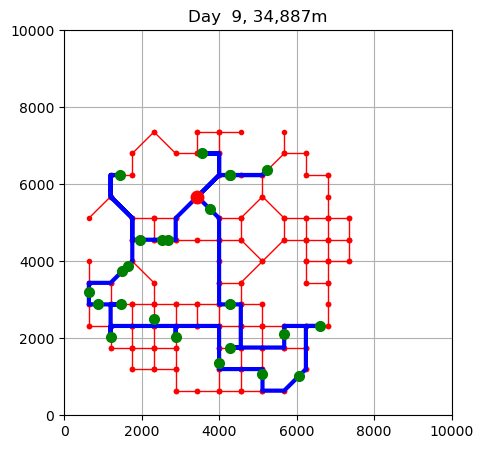

[ 9] 18:00:50.0 Parcel: 188 for customer 25 out for delivery
[ 9] 18:01:40.0 Parcel: 190 for customer 54 out for delivery
[ 9] 18:02:30.0 Parcel: 194 for customer 109 out for delivery
[ 9] 18:03:20.0 Parcel: 195 for customer 109 out for delivery
[ 9] 18:04:10.0 Parcel: 190 for customer 54 out for delivery
[ 9] 18:05:00.0 Parcel: 127 for customer 88 out for delivery
[ 9] 18:05:50.0 Parcel: 186 for customer 77 out for delivery
[ 9] 18:06:40.0 Parcel: 184 for customer 50 out for delivery
[ 9] 18:07:30.0 Parcel: 179 for customer 16 out for delivery
[ 9] 18:08:20.0 Parcel: 161 for customer 101 out for delivery
[ 9] 18:09:10.0 Parcel: 181 for customer 101 out for delivery
[ 9] 18:10:00.0 Parcel: 182 for customer 101 out for delivery
[ 9] 18:10:50.0 Parcel: 183 for customer 101 out for delivery
[ 9] 18:11:40.0 Parcel: 180 for customer 1 out for delivery
[ 9] 18:12:30.0 Parcel: 176 for customer 74 out for delivery
[ 9] 18:13:20.0 Parcel: 177 for customer 105 out for delivery
[ 9] 18:14:10.0 Pa

[ 9] 21:05:18.8 Parcel: 187 for customer 22 return from delivery
[ 9] 21:05:48.8 Parcel: 193 for customer 108 return from delivery
[ 9] 21:06:18.8 Parcel: 197 for customer 110 return from delivery
[ 9] 21:16:48.8 6 left over for next day
[ 9] 21:16:48.8 Driver goes home
Simulating the delivery of 198 parcels over 10 days to 150 customers

[ 0] 12:00:00.0 Parcel:  0 for customer 0 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  0 for customer 0 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  1 for customer 1 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  2 for customer 2 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  3 for customer 2 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  3 for customer 2 arrived in delivery centre
[ 0] 12:00:00.0 Parcel:  4 for customer 3 arr at delivery centre
[ 0] 12:00:00.0 Parcel:  4 for customer 3 arrived in deliv

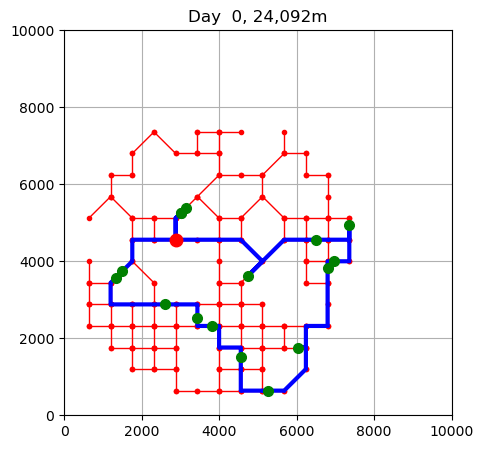

[ 0] 18:00:50.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:01:40.0 Parcel:  5 for customer 4 out for delivery
[ 0] 18:02:30.0 Parcel:  6 for customer 4 out for delivery
[ 0] 18:03:20.0 Parcel:  4 for customer 3 out for delivery
[ 0] 18:04:10.0 Parcel: 11 for customer 8 out for delivery
[ 0] 18:05:00.0 Parcel: 14 for customer 11 out for delivery
[ 0] 18:05:50.0 Parcel: 17 for customer 14 out for delivery
[ 0] 18:06:40.0 Parcel: 16 for customer 13 out for delivery
[ 0] 18:07:30.0 Parcel: 15 for customer 12 out for delivery
[ 0] 18:08:20.0 Parcel: 13 for customer 10 out for delivery
[ 0] 18:09:10.0 Parcel: 12 for customer 9 out for delivery
[ 0] 18:10:00.0 Parcel: 10 for customer 7 out for delivery
[ 0] 18:10:50.0 Parcel:  9 for customer 6 out for delivery
[ 0] 18:11:40.0 Parcel:  7 for customer 5 out for delivery
[ 0] 18:12:30.0 Parcel:  8 for customer 5 out for delivery
[ 0] 18:13:20.0 Parcel:  2 for customer 2 out for delivery
[ 0] 18:14:10.0 Parcel:  3 for customer 2 out for d

[ 1] 12:00:00.0 Parcel: 35 for customer 31 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 35 for customer 31 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 36 for customer 32 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 36 for customer 32 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 37 for customer 33 arrived in delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arr at delivery centre
[ 1] 12:00:00.0 Parcel: 38 for customer 34 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


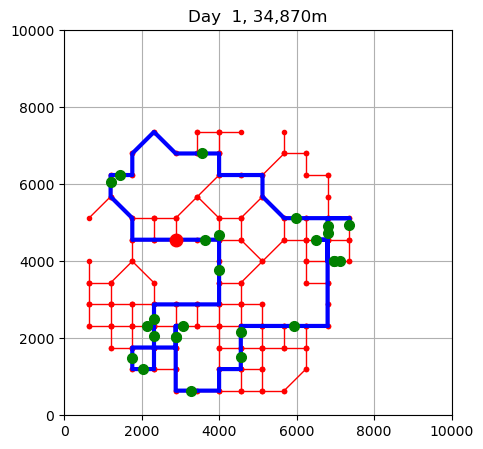

[ 1] 18:00:50.0 Parcel: 29 for customer 26 out for delivery
[ 1] 18:01:40.0 Parcel: 31 for customer 28 out for delivery
[ 1] 18:02:30.0 Parcel: 30 for customer 27 out for delivery
[ 1] 18:03:20.0 Parcel: 24 for customer 21 out for delivery
[ 1] 18:04:10.0 Parcel: 22 for customer 19 out for delivery
[ 1] 18:05:00.0 Parcel: 23 for customer 20 out for delivery
[ 1] 18:05:50.0 Parcel: 21 for customer 18 out for delivery
[ 1] 18:06:40.0 Parcel: 20 for customer 17 out for delivery
[ 1] 18:07:30.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:08:20.0 Parcel: 26 for customer 23 out for delivery
[ 1] 18:09:10.0 Parcel: 25 for customer 22 out for delivery
[ 1] 18:10:00.0 Parcel: 27 for customer 24 out for delivery
[ 1] 18:10:50.0 Parcel: 10 for customer 7 out for delivery
[ 1] 18:11:40.0 Parcel: 32 for customer 7 out for delivery
[ 1] 18:12:30.0 Parcel: 33 for customer 29 out for delivery
[ 1] 18:13:20.0 Parcel: 34 for customer 30 out for delivery
[ 1] 18:14:10.0 Parcel: 14 for customer 11

[ 1] 21:02:27.8 Parcel: 20 for customer 17 return from delivery
[ 1] 21:02:57.8 Parcel: 10 for customer 7 return from delivery
[ 1] 21:03:27.8 Parcel: 32 for customer 7 return from delivery
[ 1] 21:03:57.8 Parcel: 16 for customer 13 return from delivery
[ 1] 21:04:27.8 Parcel: 19 for customer 16 return from delivery
[ 1] 21:14:57.8 7 left over for next day
[ 1] 21:14:57.8 Driver goes home

[ 2] 12:00:00.0 Parcel: 39 for customer 17 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 39 for customer 17 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 40 for customer 35 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 41 for customer 36 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arr at delivery centre
[ 2] 12:00:00.0 Parcel: 42 for customer 37 arrived in delivery centre
[ 2] 12:00:00.0 Parcel: 43 for customer 38 arr at delivery cent

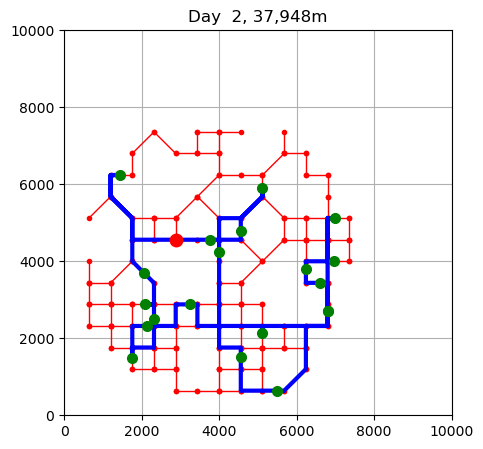

[ 2] 18:00:50.0 Parcel: 19 for customer 16 out for delivery
[ 2] 18:01:40.0 Parcel: 40 for customer 35 out for delivery
[ 2] 18:02:30.0 Parcel: 41 for customer 36 out for delivery
[ 2] 18:03:20.0 Parcel: 24 for customer 21 out for delivery
[ 2] 18:04:10.0 Parcel: 20 for customer 17 out for delivery
[ 2] 18:05:00.0 Parcel: 39 for customer 17 out for delivery
[ 2] 18:05:50.0 Parcel: 22 for customer 19 out for delivery
[ 2] 18:06:40.0 Parcel: 42 for customer 37 out for delivery
[ 2] 18:07:30.0 Parcel: 10 for customer 7 out for delivery
[ 2] 18:08:20.0 Parcel: 32 for customer 7 out for delivery
[ 2] 18:09:10.0 Parcel: 49 for customer 43 out for delivery
[ 2] 18:10:00.0 Parcel: 52 for customer 46 out for delivery
[ 2] 18:10:50.0 Parcel: 53 for customer 47 out for delivery
[ 2] 18:11:40.0 Parcel: 16 for customer 13 out for delivery
[ 2] 18:12:30.0 Parcel: 50 for customer 44 out for delivery
[ 2] 18:13:20.0 Parcel: 51 for customer 45 out for delivery
[ 2] 18:14:10.0 Parcel: 52 for customer 46

[ 3] 12:00:00.0 Parcel: 63 for customer 37 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 63 for customer 37 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 64 for customer 5 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 65 for customer 6 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 66 for customer 27 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 67 for customer 53 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 67 for customer 53 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 68 for customer 54 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 68 for customer 54 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 69 for customer 42 arr at delivery centre
[ 3] 12:00:00.0 Parcel: 69 for customer 42 arrived in delivery centre
[ 3] 12:00:00.0 Parcel: 70 for customer 42 arr at de

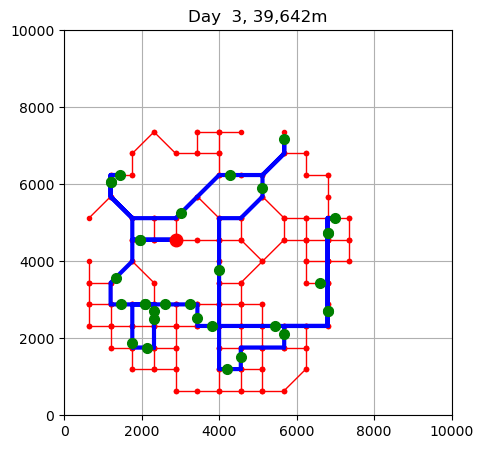

[ 3] 18:00:50.0 Parcel: 58 for customer 50 out for delivery
[ 3] 18:01:40.0 Parcel: 54 for customer 15 out for delivery
[ 3] 18:02:30.0 Parcel: 19 for customer 16 out for delivery
[ 3] 18:03:20.0 Parcel: 54 for customer 15 out for delivery
[ 3] 18:04:10.0 Parcel: 62 for customer 3 out for delivery
[ 3] 18:05:00.0 Parcel: 68 for customer 54 out for delivery
[ 3] 18:05:50.0 Parcel: 73 for customer 57 out for delivery
[ 3] 18:06:40.0 Parcel: 48 for customer 42 out for delivery
[ 3] 18:07:30.0 Parcel: 69 for customer 42 out for delivery
[ 3] 18:08:20.0 Parcel: 70 for customer 42 out for delivery
[ 3] 18:09:10.0 Parcel: 66 for customer 27 out for delivery
[ 3] 18:10:00.0 Parcel: 71 for customer 55 out for delivery
[ 3] 18:10:50.0 Parcel: 52 for customer 46 out for delivery
[ 3] 18:11:40.0 Parcel: 76 for customer 32 out for delivery
[ 3] 18:12:30.0 Parcel: 53 for customer 47 out for delivery
[ 3] 18:13:20.0 Parcel: 76 for customer 32 out for delivery
[ 3] 18:14:10.0 Parcel: 51 for customer 4

[ 3] 21:35:36.7 Parcel: 53 for customer 47 return from delivery
[ 3] 21:36:06.7 Parcel: 51 for customer 45 return from delivery
[ 3] 21:36:36.7 Parcel: 10 for customer 7 return from delivery
[ 3] 21:37:06.7 Parcel: 32 for customer 7 return from delivery
[ 3] 21:37:36.7 Parcel: 67 for customer 53 return from delivery
[ 3] 21:38:06.7 Parcel: 42 for customer 37 return from delivery
[ 3] 21:38:36.7 Parcel: 63 for customer 37 return from delivery
[ 3] 21:39:06.7 Parcel: 57 for customer 49 return from delivery
[ 3] 21:49:36.7 13 left over for next day
[ 3] 21:49:36.7 Driver goes home

[ 4] 12:00:00.0 Parcel: 77 for customer 59 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 77 for customer 59 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 78 for customer 60 arrived in delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arr at delivery centre
[ 4] 12:00:00.0 Parcel: 79 for customer 60 arrived in delivery centre
[ 4] 1

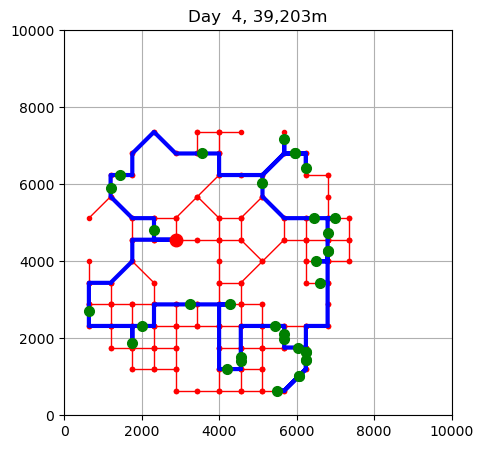

[ 4] 18:00:50.0 Parcel: 77 for customer 59 out for delivery
[ 4] 18:01:40.0 Parcel: 57 for customer 49 out for delivery
[ 4] 18:02:30.0 Parcel: 81 for customer 49 out for delivery
[ 4] 18:03:20.0 Parcel: 82 for customer 61 out for delivery
[ 4] 18:04:10.0 Parcel: 42 for customer 37 out for delivery
[ 4] 18:05:00.0 Parcel: 63 for customer 37 out for delivery
[ 4] 18:05:50.0 Parcel: 84 for customer 37 out for delivery
[ 4] 18:06:40.0 Parcel: 86 for customer 63 out for delivery
[ 4] 18:07:30.0 Parcel: 67 for customer 53 out for delivery
[ 4] 18:08:20.0 Parcel: 87 for customer 64 out for delivery
[ 4] 18:09:10.0 Parcel: 10 for customer 7 out for delivery
[ 4] 18:10:00.0 Parcel: 32 for customer 7 out for delivery
[ 4] 18:10:50.0 Parcel: 88 for customer 7 out for delivery
[ 4] 18:11:40.0 Parcel: 71 for customer 55 out for delivery
[ 4] 18:12:30.0 Parcel: 92 for customer 56 out for delivery
[ 4] 18:13:20.0 Parcel: 91 for customer 66 out for delivery
[ 4] 18:14:10.0 Parcel: 74 for customer 10 

[ 4] 21:38:07.6 Parcel: 10 for customer 7 return from delivery
[ 4] 21:38:37.6 Parcel: 32 for customer 7 return from delivery
[ 4] 21:39:07.6 Parcel: 88 for customer 7 return from delivery
[ 4] 21:39:37.6 Parcel: 71 for customer 55 return from delivery
[ 4] 21:40:07.6 Parcel: 51 for customer 45 return from delivery
[ 4] 21:40:37.6 Parcel: 99 for customer 45 return from delivery
[ 4] 21:41:07.6 Parcel: 75 for customer 58 return from delivery
[ 4] 21:41:37.6 Parcel: 89 for customer 65 return from delivery
[ 4] 21:42:07.6 Parcel: 73 for customer 57 return from delivery
[ 4] 21:42:37.6 Parcel: 80 for customer 16 return from delivery
[ 4] 21:53:07.6 13 left over for next day
[ 4] 21:53:07.6 Driver goes home

[ 5] 12:00:00.0 Parcel: 101 for customer 74 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 101 for customer 74 arrived in delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arr at delivery centre
[ 5] 12:00:00.0 Parcel: 102 for customer 75 arrived in delivery centre
[ 5] 12:00:

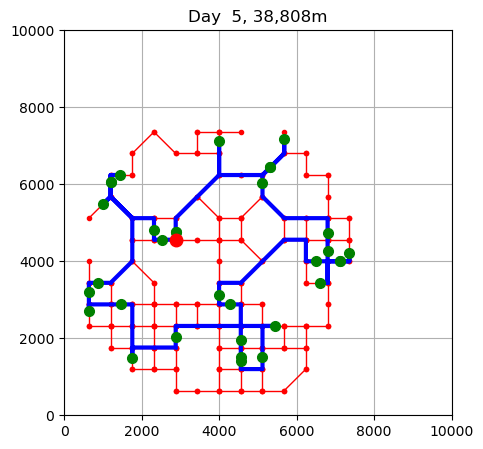

[ 5] 18:00:50.0 Parcel: 110 for customer 78 out for delivery
[ 5] 18:01:40.0 Parcel: 108 for customer 77 out for delivery
[ 5] 18:02:30.0 Parcel: 107 for customer 62 out for delivery
[ 5] 18:03:20.0 Parcel: 104 for customer 15 out for delivery
[ 5] 18:04:10.0 Parcel: 80 for customer 16 out for delivery
[ 5] 18:05:00.0 Parcel: 104 for customer 15 out for delivery
[ 5] 18:05:50.0 Parcel: 103 for customer 76 out for delivery
[ 5] 18:06:40.0 Parcel: 102 for customer 75 out for delivery
[ 5] 18:07:30.0 Parcel: 101 for customer 74 out for delivery
[ 5] 18:08:20.0 Parcel: 77 for customer 59 out for delivery
[ 5] 18:09:10.0 Parcel: 105 for customer 48 out for delivery
[ 5] 18:10:00.0 Parcel: 106 for customer 17 out for delivery
[ 5] 18:10:50.0 Parcel: 109 for customer 22 out for delivery
[ 5] 18:11:40.0 Parcel: 71 for customer 55 out for delivery
[ 5] 18:12:30.0 Parcel: 115 for customer 82 out for delivery
[ 5] 18:13:20.0 Parcel: 87 for customer 64 out for delivery
[ 5] 18:14:10.0 Parcel: 10 f

[ 5] 21:30:19.3 Parcel: 121 for customer 84 return from delivery
[ 5] 21:30:49.3 Parcel: 120 for customer 34 return from delivery
[ 5] 21:31:19.3 Parcel: 118 for customer 73 return from delivery
[ 5] 21:31:49.3 Parcel: 73 for customer 57 return from delivery
[ 5] 21:32:19.3 Parcel: 116 for customer 83 return from delivery
[ 5] 21:42:49.3 8 left over for next day
[ 5] 21:42:49.3 Driver goes home

[ 6] 12:00:00.0 Parcel: 122 for customer 49 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 122 for customer 49 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 123 for customer 85 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 124 for customer 86 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arr at delivery centre
[ 6] 12:00:00.0 Parcel: 125 for customer 51 arrived in delivery centre
[ 6] 12:00:00.0 Parcel: 126 for customer 87 arr a

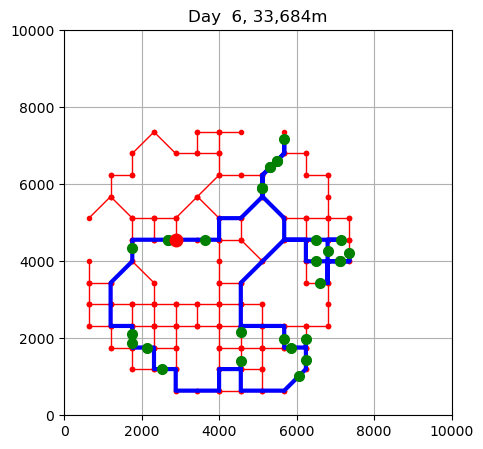

[ 6] 18:00:50.0 Parcel: 127 for customer 88 out for delivery
[ 6] 18:01:40.0 Parcel: 128 for customer 26 out for delivery
[ 6] 18:02:30.0 Parcel: 130 for customer 42 out for delivery
[ 6] 18:03:20.0 Parcel: 131 for customer 42 out for delivery
[ 6] 18:04:10.0 Parcel: 116 for customer 83 out for delivery
[ 6] 18:05:00.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:05:50.0 Parcel: 73 for customer 57 out for delivery
[ 6] 18:06:40.0 Parcel: 134 for customer 57 out for delivery
[ 6] 18:07:30.0 Parcel: 132 for customer 89 out for delivery
[ 6] 18:08:20.0 Parcel: 116 for customer 83 out for delivery
[ 6] 18:09:10.0 Parcel: 130 for customer 42 out for delivery
[ 6] 18:10:00.0 Parcel: 131 for customer 42 out for delivery
[ 6] 18:10:50.0 Parcel: 75 for customer 58 out for delivery
[ 6] 18:11:40.0 Parcel: 141 for customer 45 out for delivery
[ 6] 18:12:30.0 Parcel: 120 for customer 34 out for delivery
[ 6] 18:13:20.0 Parcel: 121 for customer 84 out for delivery
[ 6] 18:14:10.0 Parcel: 12

[ 6] 21:11:08.3 Parcel: 131 for customer 42 return from delivery
[ 6] 21:11:38.3 Parcel: 141 for customer 45 return from delivery
[ 6] 21:12:08.3 Parcel: 120 for customer 34 return from delivery
[ 6] 21:12:38.3 Parcel: 118 for customer 73 return from delivery
[ 6] 21:13:08.3 Parcel: 142 for customer 92 return from delivery
[ 6] 21:13:38.3 Parcel: 140 for customer 11 return from delivery
[ 6] 21:14:08.3 Parcel: 136 for customer 69 return from delivery
[ 6] 21:14:38.3 Parcel: 137 for customer 69 return from delivery
[ 6] 21:15:08.3 Parcel: 138 for customer 69 return from delivery
[ 6] 21:15:38.3 Parcel: 87 for customer 64 return from delivery
[ 6] 21:16:08.3 Parcel: 127 for customer 88 return from delivery
[ 6] 21:26:38.3 15 left over for next day
[ 6] 21:26:38.3 Driver goes home

[ 7] 12:00:00.0 Parcel: 143 for customer 93 arr at delivery centre
[ 7] 12:00:00.0 Parcel: 143 for customer 93 arrived in delivery centre
[ 7] 12:00:00.0 Parcel: 144 for customer 50 arr at delivery centre
[ 7] 

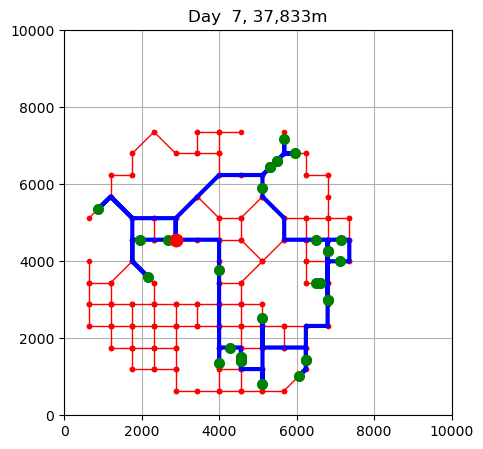

[ 7] 18:00:50.0 Parcel: 143 for customer 93 out for delivery
[ 7] 18:01:40.0 Parcel: 145 for customer 94 out for delivery
[ 7] 18:02:30.0 Parcel: 146 for customer 94 out for delivery
[ 7] 18:03:20.0 Parcel: 144 for customer 50 out for delivery
[ 7] 18:04:10.0 Parcel: 127 for customer 88 out for delivery
[ 7] 18:05:00.0 Parcel: 148 for customer 27 out for delivery
[ 7] 18:05:50.0 Parcel: 147 for customer 95 out for delivery
[ 7] 18:06:40.0 Parcel: 149 for customer 96 out for delivery
[ 7] 18:07:30.0 Parcel: 150 for customer 7 out for delivery
[ 7] 18:08:20.0 Parcel: 87 for customer 64 out for delivery
[ 7] 18:09:10.0 Parcel: 150 for customer 7 out for delivery
[ 7] 18:10:00.0 Parcel: 87 for customer 64 out for delivery
[ 7] 18:10:50.0 Parcel: 151 for customer 97 out for delivery
[ 7] 18:11:40.0 Parcel: 152 for customer 98 out for delivery
[ 7] 18:12:30.0 Parcel: 136 for customer 69 out for delivery
[ 7] 18:13:20.0 Parcel: 137 for customer 69 out for delivery
[ 7] 18:14:10.0 Parcel: 138 

[ 7] 21:30:51.3 Parcel: 149 for customer 96 return from delivery
[ 7] 21:31:21.3 Parcel: 150 for customer 7 return from delivery
[ 7] 21:31:51.3 Parcel: 151 for customer 97 return from delivery
[ 7] 21:32:21.3 Parcel: 136 for customer 69 return from delivery
[ 7] 21:32:51.3 Parcel: 137 for customer 69 return from delivery
[ 7] 21:33:21.3 Parcel: 138 for customer 69 return from delivery
[ 7] 21:33:51.3 Parcel: 136 for customer 69 return from delivery
[ 7] 21:34:21.3 Parcel: 137 for customer 69 return from delivery
[ 7] 21:34:51.3 Parcel: 138 for customer 69 return from delivery
[ 7] 21:35:21.3 Parcel: 118 for customer 73 return from delivery
[ 7] 21:35:51.3 Parcel: 141 for customer 45 return from delivery
[ 7] 21:36:21.3 Parcel: 130 for customer 42 return from delivery
[ 7] 21:36:51.3 Parcel: 131 for customer 42 return from delivery
[ 7] 21:37:21.3 Parcel: 132 for customer 89 return from delivery
[ 7] 21:47:51.3 17 left over for next day
[ 7] 21:47:51.3 Driver goes home

[ 8] 12:00:00.0

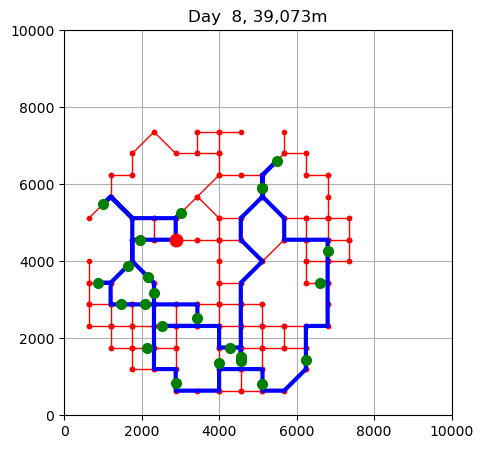

[ 8] 18:00:50.0 Parcel: 168 for customer 3 out for delivery
[ 8] 18:01:40.0 Parcel: 159 for customer 76 out for delivery
[ 8] 18:02:30.0 Parcel: 161 for customer 101 out for delivery
[ 8] 18:03:20.0 Parcel: 158 for customer 75 out for delivery
[ 8] 18:04:10.0 Parcel: 160 for customer 48 out for delivery
[ 8] 18:05:00.0 Parcel: 162 for customer 36 out for delivery
[ 8] 18:05:50.0 Parcel: 163 for customer 51 out for delivery
[ 8] 18:06:40.0 Parcel: 167 for customer 104 out for delivery
[ 8] 18:07:30.0 Parcel: 170 for customer 95 out for delivery
[ 8] 18:08:20.0 Parcel: 151 for customer 97 out for delivery
[ 8] 18:09:10.0 Parcel: 136 for customer 69 out for delivery
[ 8] 18:10:00.0 Parcel: 137 for customer 69 out for delivery
[ 8] 18:10:50.0 Parcel: 138 for customer 69 out for delivery
[ 8] 18:11:40.0 Parcel: 136 for customer 69 out for delivery
[ 8] 18:12:30.0 Parcel: 137 for customer 69 out for delivery
[ 8] 18:13:20.0 Parcel: 138 for customer 69 out for delivery
[ 8] 18:14:10.0 Parcel:

[ 8] 21:28:33.10 Parcel: 136 for customer 69 return from delivery
[ 8] 21:29:03.10 Parcel: 137 for customer 69 return from delivery
[ 8] 21:29:33.10 Parcel: 138 for customer 69 return from delivery
[ 8] 21:30:03.10 Parcel: 136 for customer 69 return from delivery
[ 8] 21:30:33.10 Parcel: 137 for customer 69 return from delivery
[ 8] 21:31:03.10 Parcel: 138 for customer 69 return from delivery
[ 8] 21:31:33.10 Parcel: 172 for customer 64 return from delivery
[ 8] 21:32:03.10 Parcel: 149 for customer 96 return from delivery
[ 8] 21:32:33.10 Parcel: 164 for customer 102 return from delivery
[ 8] 21:33:03.10 Parcel: 165 for customer 102 return from delivery
[ 8] 21:33:33.10 Parcel: 145 for customer 94 return from delivery
[ 8] 21:34:03.10 Parcel: 146 for customer 94 return from delivery
[ 8] 21:44:33.10 19 left over for next day
[ 8] 21:44:33.10 Driver goes home

[ 9] 12:00:00.0 Parcel: 176 for customer 74 arr at delivery centre
[ 9] 12:00:00.0 Parcel: 176 for customer 74 arrived in delive

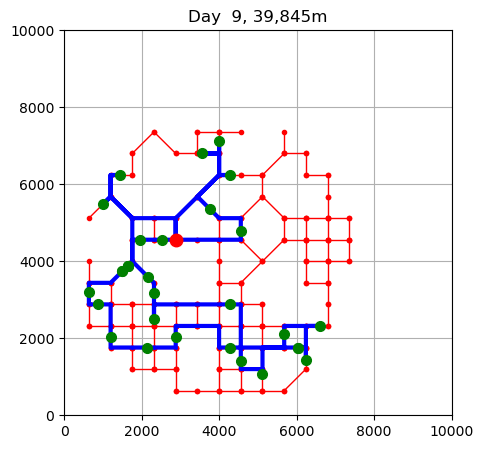

[ 9] 18:00:50.0 Parcel: 179 for customer 16 out for delivery
[ 9] 18:01:40.0 Parcel: 159 for customer 76 out for delivery
[ 9] 18:02:30.0 Parcel: 161 for customer 101 out for delivery
[ 9] 18:03:20.0 Parcel: 181 for customer 101 out for delivery
[ 9] 18:04:10.0 Parcel: 182 for customer 101 out for delivery
[ 9] 18:05:00.0 Parcel: 183 for customer 101 out for delivery
[ 9] 18:05:50.0 Parcel: 180 for customer 1 out for delivery
[ 9] 18:06:40.0 Parcel: 176 for customer 74 out for delivery
[ 9] 18:07:30.0 Parcel: 177 for customer 105 out for delivery
[ 9] 18:08:20.0 Parcel: 178 for customer 106 out for delivery
[ 9] 18:09:10.0 Parcel: 163 for customer 51 out for delivery
[ 9] 18:10:00.0 Parcel: 187 for customer 22 out for delivery
[ 9] 18:10:50.0 Parcel: 149 for customer 96 out for delivery
[ 9] 18:11:40.0 Parcel: 192 for customer 96 out for delivery
[ 9] 18:12:30.0 Parcel: 175 for customer 10 out for delivery
[ 9] 18:13:20.0 Parcel: 136 for customer 69 out for delivery
[ 9] 18:14:10.0 Par

[ 9] 21:51:53.9 Parcel: 176 for customer 74 return from delivery
[ 9] 21:52:23.9 Parcel: 177 for customer 105 return from delivery
[ 9] 21:52:53.9 Parcel: 187 for customer 22 return from delivery
[ 9] 21:53:23.9 Parcel: 149 for customer 96 return from delivery
[ 9] 21:53:53.9 Parcel: 192 for customer 96 return from delivery
[ 9] 21:54:23.9 Parcel: 175 for customer 10 return from delivery
[ 9] 21:54:53.9 Parcel: 145 for customer 94 return from delivery
[ 9] 21:55:23.9 Parcel: 146 for customer 94 return from delivery
[ 9] 21:55:53.9 Parcel: 184 for customer 50 return from delivery
[ 9] 21:56:23.9 Parcel: 190 for customer 54 return from delivery
[ 9] 21:56:53.9 Parcel: 188 for customer 25 return from delivery
[ 9] 22:07:23.9 19 left over for next day
[ 9] 22:07:23.9 Driver goes home


In [53]:
# Initializing an empty list to store simulation results for different warehouse locations.
rec_diff_warehouses_h = []

# Iterating through each warehouse location in the list of warehouse locations W.
for w in W:
    # Setting the random seed to ensure reproducibility.
    random.seed(seed)
    
    # Calling the simulation function with specified parameters
    # Parameters: Map geometry (M), current warehouse location (w), customer locations (C),
    #             simulation duration (days=10), parcels per day and customer (p=0.15),
    #             bike range limit (limit=40000), logging enabled (log=True),
    #             plotting enabled (plot=True), and heuristic enabled (heuristic=True)
    rec_diff_warehouses_h.append(simulation(M, w, C, days=10, p=0.15, limit=40000, log=True, plot=True, heuristic=True))

According to the above simulation, the author has found the best warehouse. In the subsequent sections the author will be running the simulation for longer time periods to observe the change in the best warehouse location.

### 5.6 Best warehouse location

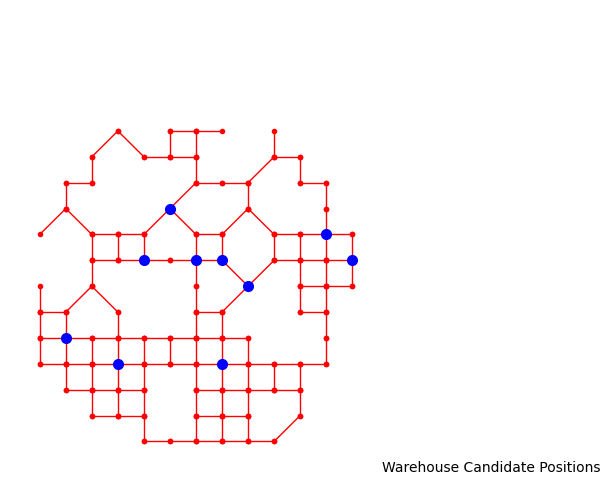

Simulate Delivery from Warehouse (6800,5120)
Simulating the delivery of 449 parcels over 20 days to 150 customers


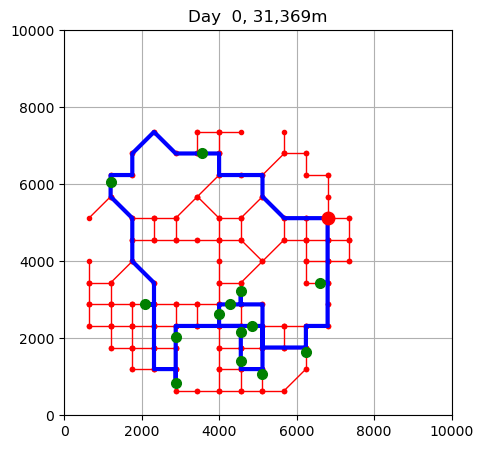

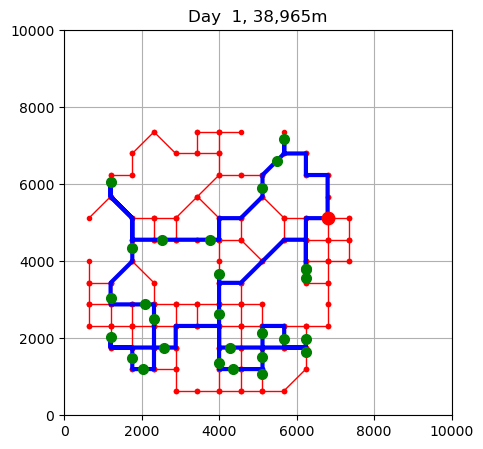

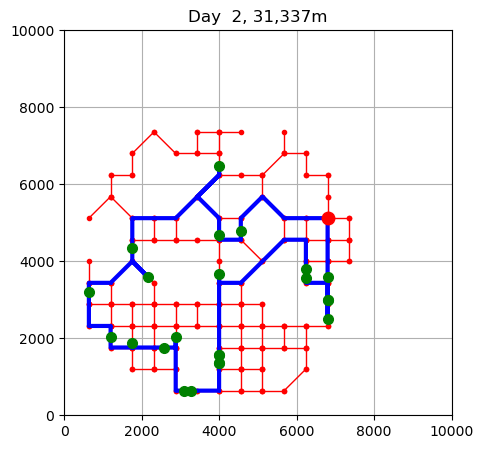

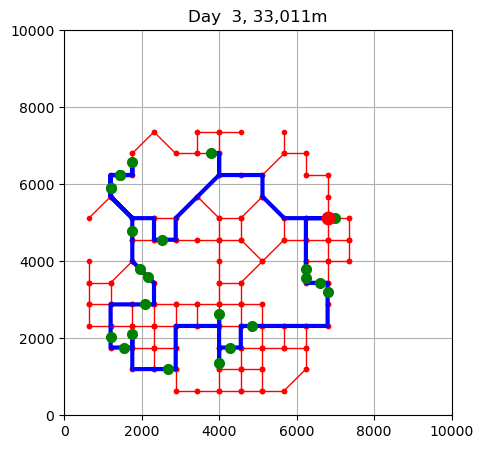

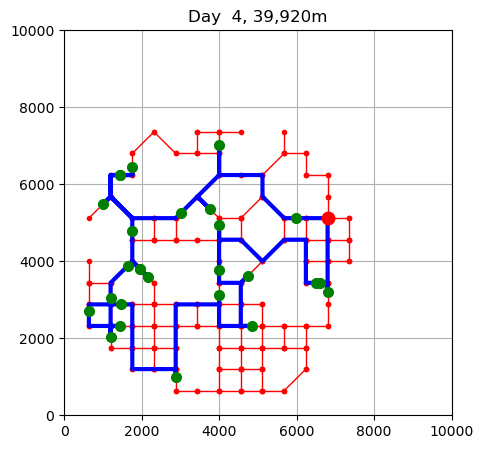

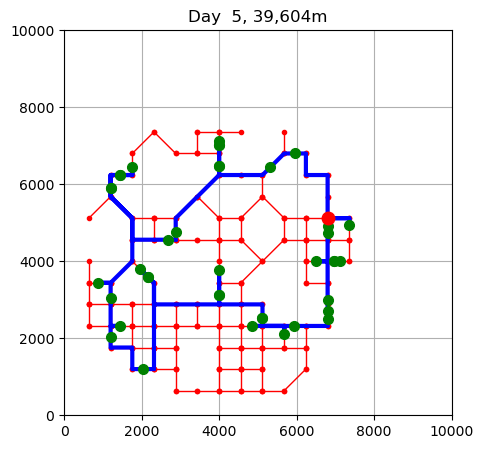

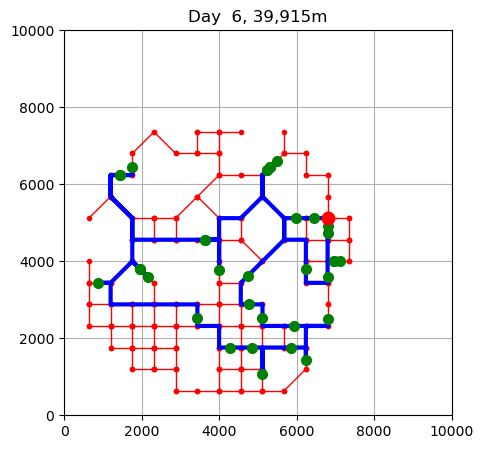

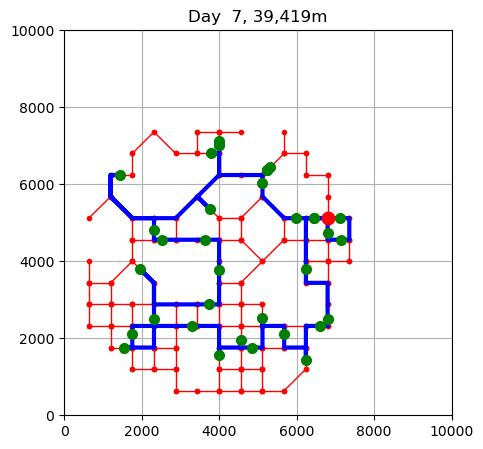

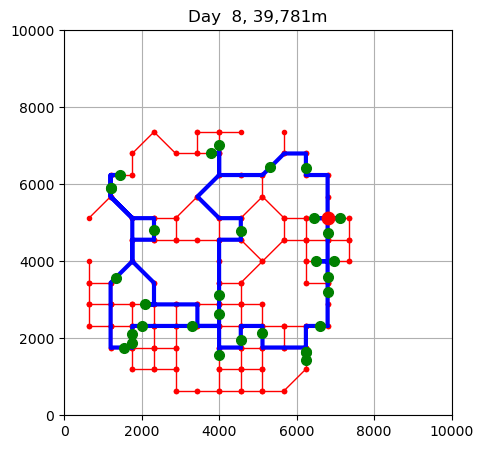

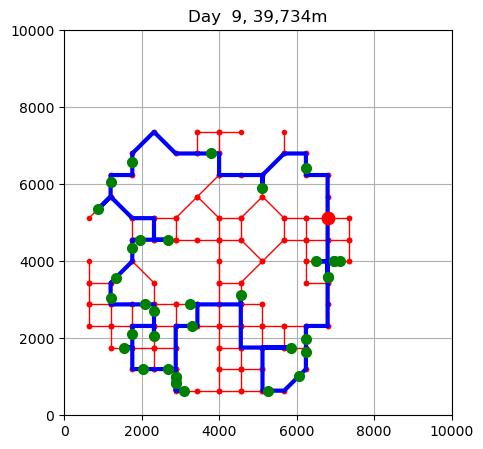

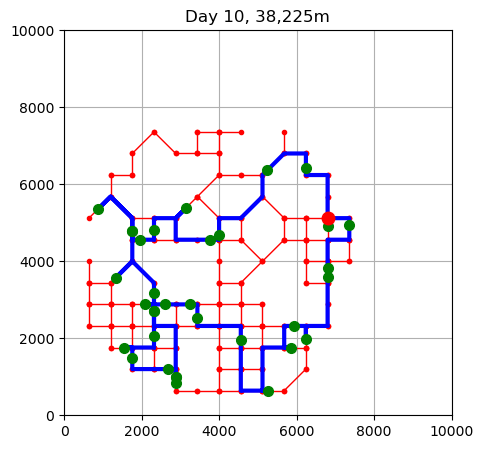

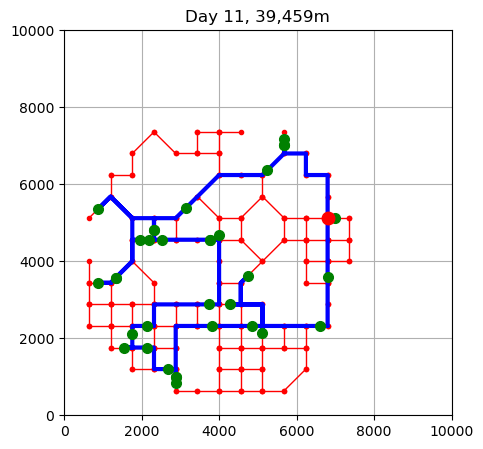

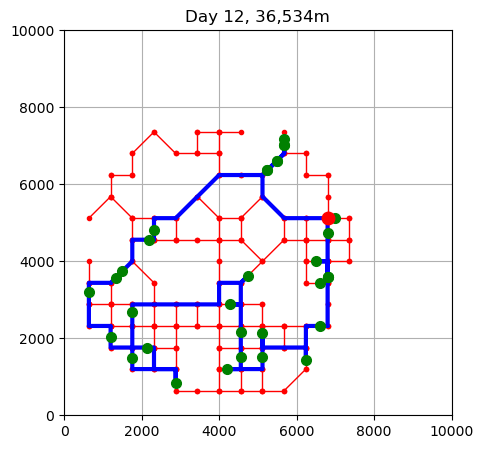

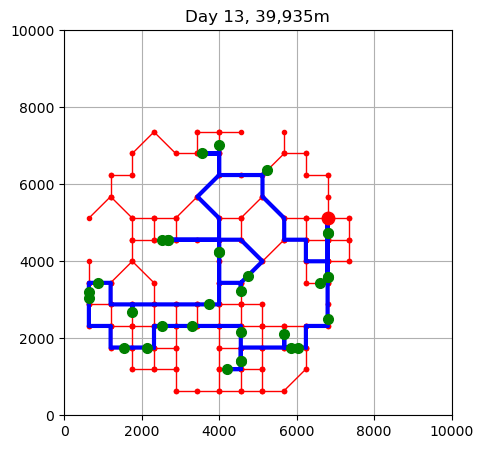

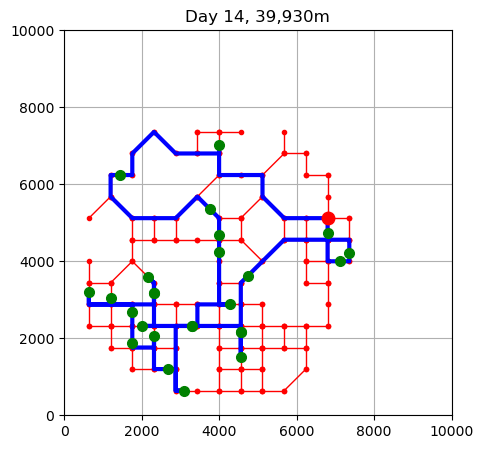

In [ ]:
def formatLocation(w):
    """
    Function to format a warehouse location into a string.
    
    Args:
    - w: Tuple containing the coordinates of the warehouse location.
    
    Returns:
    - String: Formatted representation of the warehouse location.
    """
    return f"({w[0]:4d},{w[1]:4d})"

def monteCarlo(M, W, C, days, p, limit, seed, log=False, plot=False, heuristic=False):
    """
    Function to perform Monte Carlo simulation to find the best warehouse location.
    
    Args:
    - M: Map geometry.
    - W: List of candidate warehouse locations.
    - C: List of customer locations.
    - days: Duration of simulation in days.
    - p: Parcels per day and customer.
    - limit: Bike range limit.
    - seed: Random seed for reproducibility.
    - log: Boolean indicating whether to enable logging (default=False).
    - plot: Boolean indicating whether to enable plotting (default=False).
    - heuristic: Boolean indicating whether to use heuristic optimization (default=False).
    
    Returns:
    - recBest: List of recorder objects for the best warehouse location.
    - wBest: List of the best warehouse locations.
    - minCost: Minimum cost achieved.
    - simulationTime: Total time taken for simulation.
    """
    start = time.time()
    
    # Plotting the candidate warehouse positions.
    plotMap(M, T=W, styleT='bo', msT=7, text="Warehouse Candidate Positions")
    
    # Initializing variables to track best warehouse location and cost.
    minCost = float('inf')
    
    # Iterating through each warehouse location.
    for w in W:
        title = "Simulate Delivery from Warehouse " + formatLocation(w)
        print(title)
        
        # Setting the random seed.
        random.seed(seed)
        
        # Running the simulation for the current warehouse location.
        rec = simulation(M, w, C, days=days, p=0.15, limit=limit, log=log, plot=plot, heuristic=heuristic)
        
        # Saving the simulation results.
        filename = "recorder/rec_w=" + formatLocation(w) + ".pickled"
        directory = os.path.dirname(filename)
        if not os.path.exists(directory):
            os.makedirs(directory)
        with open(filename, 'wb') as f:
            pickle.dump(rec, f)
        
        # Comparing the cost to find the best warehouse.
        c = rec.daily.cost.mean()
        if c < minCost:
            minCost = c
            print(f"  improved position:   {formatLocation(w):s} cost={minCost:7.2f}")
            wBest = [w]
            recBest = [rec]
        elif c == minCost:
            print(f"  equivalent position: {formatLocation(w):s} cost={minCost:7.2f}")
            wBest.append(w)
            recBest.append(rec)
    
    # Plotting the best warehouse location.
    plotMap(M, T=wBest, styleT='bo', msT=7, text="Best Warehouse Position")
    end = time.time()
    
    # Calculating total simulation time.
    simulationTime = end - start
        
    return recBest, wBest, minCost, simulationTime

# Running Monte Carlo simulation to find the best warehouse location.
recBest, wBest, minCost, simulationTime = monteCarlo(M, W, C, days=20, p=0.15, limit=40000,plot=True, heuristic=True, seed=seed)

# This code performs a Monte Carlo simulation to find the best warehouse location by iterating through each:
# candidate warehouse location, running simulations, and comparing the costs.
# It then saves the simulation results and plots the best warehouse location.

The best warehouse location is (2880,4560) with an operational cost of 114.78 euros per day.

In [ ]:
print("Time for simulating best warehouse locations : "+str("%.2f"%(simulationTime/60))+" minutes")

In [ ]:
# Best warehouse location.
wBest

In [ ]:
# The minimum delivery time recorded in the daily data of the best warehouse location.
recBest[0].daily.time.min()

In [ ]:
recBest

## 6 Results

### 6.1 Analysis

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the histogram of working time for each simulation.
    rec.histWorkingTime()
# The code loops through the recorded data from different simulations.
# It generates histograms to visualize the distribution of working time for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the working time for each simulation.
    rec.plotWorkingTime()
# The code iterates through the recorded data from different simulations
# It generates plots to visualize the working time for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the histogram of tour lengths for each simulation.
    rec.histTourLength()
# The code iterates through the recorded data from different simulations.
# It generates histograms to visualize the distribution of tour lengths for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the tour lengths for each simulation.
    rec.plotTourLength()
# The code iterates through the recorded data from different simulations.
# It generates plots to visualize the tour lengths for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the histogram of leftover parcels for each simulation.
    rec.histLeftOver()
# The code iterates through the recorded data from different simulations.
# It generates histograms to visualize the distribution of leftover parcels for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the left-over parcels for each simulation.
    rec.plotLeftOver()
# The code iterates through the recorded data from different simulations.
# It generates plots to visualize the distribution of left-over parcels for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Displaying a table showing parcel delay information for each simulation.
    rec.tableParcelDelay()
# The code iterates through the recorded data from different simulations. 
# It displays a table showing parcel delay information for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Displaying a bar plot showing parcel delay information for each simulation.
    rec.barplotParcelDelay()
# The code iterates through the recorded data from different simulations.
# It displays a bar plot showing parcel delay information for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Displaying a plot showing parcel delay information for each simulation.
    rec.plotParcelDelay()
# The code iterates through the recorded data from different simulations.
# It displays a plot showing parcel delay information for each simulation.

### 6.2 F-Test

Reading all recorder files and then create a dataframe of cost related data for ANOVA test.

In [ ]:
os.listdir('recorder')

In [ ]:
# Specifying the folder containing pickle files.
folder_path = 'recorder'

# Initializing an empty list to store the loaded data.
loaded_data = []

# Looping through all files in the folder.
for filename in os.listdir(folder_path):
    # Reading all Data except for best Warehouse data.
    for j in wBest:
        if formatLocation(j) not in filename:
            file_path = os.path.join(folder_path, filename)
            # Opening the pickle file and load the data.
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                loaded_data.append(data)
loaded_data

Null Hypothesis (H0): The mean cost of the chosen warehouse is not significantly different from the mean costs of other warehouses. Alternative Hypothesis (H1): The mean cost of the chosen warehouse is significantly different from the mean costs of other warehouses.

In [ ]:
# Assuming best_warehouse_cost is a series or list containing the costs of the best warehouse.
best_warehouse_costs=[]
for rec in recBest:
    best_warehouse_costs.append(rec.daily.cost)

other_warehouse_costs=[]
for rec in loaded_data:
    other_warehouse_costs.append(rec.daily.cost)

# Performing the F-test for each warehouse candidate.
alpha = 0.05  # significance level.
for i, candidate_costs in enumerate(best_warehouse_costs, start=1):
    f_statistic, p_value = f_oneway(candidate_costs, *other_warehouse_costs)
    print(p_value)
    # Interpretion of the results.
    if p_value < alpha:
        print(f"Reject null hypothesis for warehouse candidate {i}. Variances are significantly different.")
    else:
        print(f"Fail to reject null hypothesis for warehouse candidate {i}. Variances are not significantly different.")

## 7 Run Multiple Larger Simulation

### 7.1 Multiple Simulation Function

In [ ]:
def multiSimulation(seeds,        # Seed values for simulation runs.
                    M, W, C,      # Geometry data.
                    days=50,      # Run simulation for number of days.
                    p=0.2,        # Parcels per day and customer.
                    limit=30000,  # Bike range limit.
                    q=0.1,        # Probability that the customer is not at home. 
                    patience=60): # Max wait time for customer answering door.
    for seed in seeds:
        random.seed(seed)
        filename = f"rec days={days:d} p={p:2.2f} limit={limit:d} " + \
                   f"q={q:2.2f} patience={patience:d} seed={seed:d}"
        print(filename)
        rec = simulation(M, W, C, 
                         days=days, p=p, limit=limit, q=q, patience=patience, 
                         heuristic=True)
        with open('res/'+filename, 'wb') as f:
            pickle.dump(rec, f)
        print()

# This function 'multiSimulation' performs multiple simulations with different seed values and saves the results to files using pickle.
# Each file is named based on the simulation parameters and the seed value used for that simulation.

In [ ]:
def loadSimulations(seeds,        # Seed values for simulation runs.   
                    days=50,      # Run simulation for number of days.
                    p=0.2,        # Parcels per day and customer. 
                    limit=30000,  # Bike range limit.
                    q=0.1,        # Probability that the customer is not at home. 
                    patience=60): # Max wait time for customer answering door.
    recs = []
    for seed in seeds:
        random.seed(seed)
        filename = f"rec days={days:d} p={p:2.2f} limit={limit:d} " + \
                   f"q={q:2.2f} patience={patience:d} seed={seed:d}"
        print(filename)
        with open('res/'+filename, 'rb') as f:
            rec = pickle.load(f)
            recs.append(rec)
    return recs

# This function 'loadSimulations' loads simulation results from files generated by 'multiSimulation'.
# It takes a list of seed values and returns a list of recorder objects containing simulation data.
# Each recorder object corresponds to a simulation run with a specific seed value.

### 7.2 Running Simulations

In [ ]:
with open('customer_data.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [ ]:
# Specifying the directory path.
directory = 'res/'

# Checking if the directory exists.
if not os.path.exists(directory):
    # If the directory does not exist, creating a new directory.
    os.makedirs(directory)

In [ ]:
multiSimulation(range(10), M, wBest[0], C, limit=40000,p=0.15)

# This function will run multiple simulations with different seed values and save the results to files.
# Each simulation will use the same parameters but with different random seeds.
# This ensures that each simulation run is independent.

### 7.3 Combine Simulation

In [ ]:
# Loading the simulation results for 10 different seeds.
recs = loadSimulations(range(10), limit=40000, p=0.15)

In [ ]:
# Combining the simulation results from multiple recorders.
rec = combineRecorders(recs)

### 7.4 Analysis

In [ ]:
# Visualize the distribution of working time across simulations
rec.histWorkingTime()

In [ ]:
rec.plotWorkingTime()

In [ ]:
# Visualize the distribution of tour lengths across simulations
rec.histTourLength()

In [ ]:
# Visualize the distribution of leftover parcels across simulations
rec.histLeftOver()

In [ ]:
# Plot the trend of leftover parcels over time across simulations
rec.plotLeftOver()

In [ ]:
# Display a table summarizing parcel delay statistics
rec.tableParcelDelay()

In [ ]:
# Create a bar plot to visualize parcel delay statistics
rec.barplotParcelDelay()

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the histogram of working time for each simulation.
    rec.histWorkingTime()
# The code loops through the recorded data from different simulations.
# It generates histograms to visualize the distribution of working time for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the working time for each simulation.
    rec.plotWorkingTime()
# The code iterates through the recorded data from different simulations
# It generates plots to visualize the working time for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the histogram of tour lengths for each simulation.
    rec.histTourLength()
# The code iterates through the recorded data from different simulations.
# It generates histograms to visualize the distribution of tour lengths for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the tour lengths for each simulation.
    rec.plotTourLength()
# The code iterates through the recorded data from different simulations.
# It generates plots to visualize the tour lengths for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the histogram of leftover parcels for each simulation.
    rec.histLeftOver()
# The code iterates through the recorded data from different simulations.
# It generates histograms to visualize the distribution of leftover parcels for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Plotting the left-over parcels for each simulation.
    rec.plotLeftOver()
# The code iterates through the recorded data from different simulations.
# It generates plots to visualize the distribution of left-over parcels for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Displaying a table showing parcel delay information for each simulation.
    rec.tableParcelDelay()
# The code iterates through the recorded data from different simulations. 
# It displays a table showing parcel delay information for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Displaying a bar plot showing parcel delay information for each simulation.
    rec.barplotParcelDelay()
# The code iterates through the recorded data from different simulations.
# It displays a bar plot showing parcel delay information for each simulation.

In [ ]:
# Iterating over the list of recorded data from simulations conducted at different warehouse locations.
for rec in recBest:
    # Displaying a plot showing parcel delay information for each simulation.
    rec.plotParcelDelay()
# The code iterates through the recorded data from different simulations.
# It displays a plot showing parcel delay information for each simulation.

### 7.5 ANOVA Test

In [ ]:
# Checkong normality of residuals using Shapiro-Wilk test.
residuals = rec.daily['cost'] - rec.daily['cost'].mean()
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue)

In [ ]:
# Extracting the cost values from each Recorder object.
costs = [rec.daily.cost.values for rec in recs]

# Performing the ANOVA.
f_statistic, p_value = stats.f_oneway(*costs)
print("ANOVA p-value:", p_value)
